In [97]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, cohen_kappa_score
import numpy as np
import torch.nn.functional as F

# Load the dataset
newsgroups_data = fetch_20newsgroups(subset='all')
vectorizer = TfidfVectorizer(max_features=2000)
X = vectorizer.fit_transform(newsgroups_data.data).toarray()
y = newsgroups_data.target

# Convert to tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# Define a custom dataset
class NewsGroupsDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create the full dataset
full_dataset = NewsGroupsDataset(X_tensor, y_tensor)

def create_class_subset(dataset, classes):
    indices = [i for i, label in enumerate(dataset.y) if label in classes]
    subset_X = dataset.X[indices]
    subset_y = dataset.y[indices]
    return NewsGroupsDataset(subset_X, subset_y)

# Define topic groups
group_1 = list(range(5))      # Topics 0-4
group_2 = list(range(5, 10))  # Topics 5-9
group_3 = list(range(10, 15)) # Topics 10-14
group_4 = list(range(15, 20)) # Topics 15-19

# Create datasets for each group
dataset_1 = create_class_subset(full_dataset, group_1)
dataset_2 = create_class_subset(full_dataset, group_2)
dataset_3 = create_class_subset(full_dataset, group_3)
dataset_4 = create_class_subset(full_dataset, group_4)

# Function to split dataset into train, validation, and test
def split_dataset(dataset, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    total_len = len(dataset)
    train_len = int(train_ratio * total_len)
    val_len = int(val_ratio * total_len)
    test_len = total_len - train_len - val_len
    return random_split(dataset, [train_len, val_len, test_len])

# Split each dataset into train, validation, and test sets
train_dataset_1, val_dataset_1, test_dataset_1 = split_dataset(dataset_1)
train_dataset_2, val_dataset_2, test_dataset_2 = split_dataset(dataset_2)
train_dataset_3, val_dataset_3, test_dataset_3 = split_dataset(dataset_3)
train_dataset_4, val_dataset_4, test_dataset_4 = split_dataset(dataset_4)

In [98]:
batch_size = 32
# Group 1
train_loader_1 = DataLoader(train_dataset_1, batch_size=batch_size, shuffle=True)
val_loader_1 = DataLoader(val_dataset_1, batch_size=batch_size, shuffle=False)
test_loader_1 = DataLoader(test_dataset_1, batch_size=batch_size, shuffle=False)

# Group 2
train_loader_2 = DataLoader(train_dataset_2, batch_size=batch_size, shuffle=True)
val_loader_2 = DataLoader(val_dataset_2, batch_size=batch_size, shuffle=False)
test_loader_2 = DataLoader(test_dataset_2, batch_size=batch_size, shuffle=False)

# Group 3
train_loader_3 = DataLoader(train_dataset_3, batch_size=batch_size, shuffle=True)
val_loader_3 = DataLoader(val_dataset_3, batch_size=batch_size, shuffle=False)
test_loader_3 = DataLoader(test_dataset_3, batch_size=batch_size, shuffle=False)

# Group 4
train_loader_4 = DataLoader(train_dataset_4, batch_size=batch_size, shuffle=True)
val_loader_4 = DataLoader(val_dataset_4, batch_size=batch_size, shuffle=False)
test_loader_4 = DataLoader(test_dataset_4, batch_size=batch_size, shuffle=False)

In [99]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.special import rel_entr
import pandas as pd

# 1. List topics in each group
topics_group_1 = [newsgroups_data.target_names[i] for i in group_1]
topics_group_2 = [newsgroups_data.target_names[i] for i in group_2]
topics_group_3 = [newsgroups_data.target_names[i] for i in group_3]
topics_group_4 = [newsgroups_data.target_names[i] for i in group_4]

print("Group 1 Topics:", topics_group_1)
print("Group 2 Topics:", topics_group_2)
print("Group 3 Topics:", topics_group_3)
print("Group 4 Topics:", topics_group_4)

# 2. Calculate mean TF-IDF vectors for each group
def compute_mean_tfidf(dataset):
    tfidf_vectors = dataset.X.numpy()
    return tfidf_vectors.mean(axis=0)

mean_tfidf_1 = compute_mean_tfidf(dataset_1)
mean_tfidf_2 = compute_mean_tfidf(dataset_2)
mean_tfidf_3 = compute_mean_tfidf(dataset_3)
mean_tfidf_4 = compute_mean_tfidf(dataset_4)

# Combine mean vectors for comparison
mean_tfidf_groups = {
    "Group 1": mean_tfidf_1,
    "Group 2": mean_tfidf_2,
    "Group 3": mean_tfidf_3,
    "Group 4": mean_tfidf_4
}

# 3. Compute Cosine Similarity Between Groups
cosine_similarities = pd.DataFrame(index=mean_tfidf_groups.keys(), columns=mean_tfidf_groups.keys())

for group_a, vec_a in mean_tfidf_groups.items():
    for group_b, vec_b in mean_tfidf_groups.items():
        similarity = cosine_similarity([vec_a], [vec_b])[0][0]
        cosine_similarities.loc[group_a, group_b] = similarity

print("\nCosine Similarities Between Groups:")
print(cosine_similarities)

# 4. Compute KL Divergence Between Groups
kl_divergences = pd.DataFrame(index=mean_tfidf_groups.keys(), columns=mean_tfidf_groups.keys())

for group_a, vec_a in mean_tfidf_groups.items():
    for group_b, vec_b in mean_tfidf_groups.items():
        # Normalize vectors to sum to 1 (treat them as probability distributions)
        vec_a_norm = vec_a / vec_a.sum()
        vec_b_norm = vec_b / vec_b.sum()
        # Compute KL divergence
        kl_div = sum(rel_entr(vec_a_norm, vec_b_norm))  # KL divergence
        kl_divergences.loc[group_a, group_b] = kl_div

print("\nKL Divergences Between Groups:")
print(kl_divergences)


Group 1 Topics: ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware']
Group 2 Topics: ['comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball']
Group 3 Topics: ['rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space']
Group 4 Topics: ['soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']

Cosine Similarities Between Groups:
          Group 1   Group 2   Group 3   Group 4
Group 1       1.0  0.938926  0.929589  0.888675
Group 2  0.938926       1.0   0.94916  0.903098
Group 3  0.929589   0.94916       1.0  0.939794
Group 4  0.888675  0.903098  0.939794       1.0

KL Divergences Between Groups:
        Group 1 Group 2 Group 3 Group 4
Group 1     0.0     inf     inf     inf
Group 2     inf     0.0     inf     inf
Group 3     inf     inf     0.0     inf
Group 4     inf     inf     inf     0.0


In [100]:
class NewsNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NewsNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)  # Initially set output_dim for the first set of classes

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def expand_output(self, new_output_dim):
        # Expand the output layer to accommodate more classes
        self.fc3 = nn.Linear(self.fc3.in_features, new_output_dim)

input_dim = 2000
hidden_dim = 256
output_dim = 20  # Number of classes in the dataset


In [101]:
class OnlineEWC:
    def __init__(self, model, dataloader):
        """
        Online EWC implementation.
        Args:
            model: Neural network model.
            dataloader: DataLoader for the current task.
        """
        self.model = model
        self.dataloader = dataloader
        self.fisher_matrix = {}
        self.optimal_params = {}

    def update_fisher_matrix(self):
        """
        Update the Fisher matrix using the online method.
        """
        self.model.eval()
        fisher_diagonal = {n: torch.zeros_like(p) for n, p in self.model.named_parameters() if p.requires_grad}
        
        for i, (data, target) in enumerate(self.dataloader, 1):
            self.model.zero_grad()
            output = self.model(data)
            loss = F.nll_loss(F.log_softmax(output, dim=1), target)
            loss.backward()

            # Update Fisher diagonal iteratively
            for n, p in self.model.named_parameters():
                if p.grad is not None:
                    fisher_diagonal[n] += (p.grad ** 2 - fisher_diagonal[n]) / i
        
        # Update Fisher matrix with the new Fisher diagonal values
        for n in fisher_diagonal:
            if n in self.fisher_matrix:
                self.fisher_matrix[n] += fisher_diagonal[n]
            else:
                self.fisher_matrix[n] = fisher_diagonal[n]

    def store_optimal_params(self):
        """
        Store a copy of the model's current parameters as the optimal parameters for the current task.
        """
        self.optimal_params = {n: p.clone().detach() for n, p in self.model.named_parameters() if p.requires_grad}

    def penalty(self, model):
        """
        Calculate the EWC penalty based on the Fisher matrix and optimal parameters.
        """
        penalty = 0.0
        for n, p in model.named_parameters():
            if p.requires_grad and n in self.fisher_matrix:
                penalty += (self.fisher_matrix[n] * (p - self.optimal_params[n]) ** 2).sum()
        return penalty


In [102]:
def train_with_ewc(model, optimizer, dataloaders, ewc=None, lambda_ewc=0.1, epochs=5):
    """
    Train the model with or without EWC penalty.
    
    Args:
        model: Neural network model to train.
        optimizer: Optimizer for training.
        dataloaders: Dictionary containing 'train' and optionally 'val' dataloaders.
        ewc: Instance of the EWC class, or None if not using EWC.
        lambda_ewc: Importance of the EWC penalty (default is 0.1).
        epochs: Number of epochs to train.
    """
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        
        for inputs, targets in dataloaders['train']:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Add EWC penalty if applicable
            if ewc is not None:
                ewc_penalty = ewc.penalty(model)
                loss += lambda_ewc * ewc_penalty
            
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(dataloaders['train'])}")


In [103]:
def evaluate(model, test_loader, criterion, current_classes):
    """
    Evaluate the model on the given test_loader.

    Args:
        model: The neural network being evaluated.
        test_loader: DataLoader containing the test dataset.
        criterion: Loss function.
        current_classes: List of class indices relevant to the current task.

    Returns:
        Tuple containing accuracy, precision, recall, and kappa score.
    """
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    correct = 0
    total = 0

    all_targets = []
    all_preds = []

    with torch.no_grad():
        for data, targets in test_loader:
            # Forward pass
            outputs = model(data)

            # Dynamically mask irrelevant outputs (only keep current task classes)
            outputs = outputs[:, current_classes]

            # Adjust targets to align with the current task's class indices
            task_targets = torch.tensor(
                [current_classes.index(t.item()) for t in targets if t.item() in current_classes]
            )

            # Compute loss
            loss = criterion(outputs, task_targets)
            total_loss += loss.item()

            # Get predictions
            _, preds = torch.max(outputs, 1)
            correct += (preds == task_targets).sum().item()
            total += task_targets.size(0)

            # Append to lists for metric computation
            all_targets.extend(task_targets.numpy())
            all_preds.extend(preds.numpy())

    # Compute evaluation metrics
    accuracy = correct / total if total > 0 else 0.0
    precision = precision_score(all_targets, all_preds, average="macro", zero_division=0)
    recall = recall_score(all_targets, all_preds, average="macro", zero_division=0)
    kappa = cohen_kappa_score(all_targets, all_preds)

    return accuracy, precision, recall, kappa


In [104]:
def evaluate_old(model, loader, criterion):
    model.eval()
    total_loss = 0
    all_targets = []
    all_predictions = []
    with torch.no_grad():
        for data, target in loader:  # Get data, target, and task_id
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()
            predictions = torch.argmax(output, dim=1)
            all_targets.extend(target.numpy())
            all_predictions.extend(predictions.numpy())

    accuracy = accuracy_score(all_targets, all_predictions)
    precision = precision_score(all_targets, all_predictions, average='weighted', zero_division=0)
    recall = recall_score(all_targets, all_predictions, average='weighted', zero_division=0)
    kappa = cohen_kappa_score(all_targets, all_predictions)

    return accuracy, precision, recall, kappa

In [105]:
epoch_stats_nov = epoch_stats

In [ ]:
# Initialize the first model, optimizer, and loss function
input_dim = 2000
hidden_dim = 256
learning_rate = 0.0001
num_runs = 10
epochs = 50

import json

results = {
    "untrained_A": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "initial_A": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "B_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "A_after_B_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "C_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "D_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "A_after_C_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "B_after_C_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "B_no_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "A_after_B_no_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "C_no_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "D_no_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "A_after_C_no_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "B_after_C_no_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "A_after_D_no_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "B_after_D_no_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "A_after_D_no_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "A_after_D_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "B_after_D_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "A_after_D_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "C_after_D_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "C_after_D_no_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    
    
}

results_val = {
    "initial_A": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "B_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "A_after_B_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "C_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "D_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "A_after_C_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "B_after_C_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "B_no_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "A_after_B_no_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "C_no_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "D_no_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "A_after_C_no_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "B_after_C_no_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "A_after_D_no_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "B_after_D_no_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "A_after_D_no_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "A_after_D_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "B_after_D_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "A_after_D_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "C_after_D_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "C_after_D_no_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
}

# Store per-epoch values for charting the training of Task 2 and Task 3
epoch_stats = {
    "Initial": {"accuracy": [], "loss": []},
    "ewc": {
        "A_during_A": [], "A_during_A_val": [], "A_during_B":[], "A_during_B_val": [], "D_during_B":[], "D_during_B_val": [],"C_during_D":[], "C_during_D_val": [],
        "B_during_C": [], "A_during_C": [], "A_during_C_val": [], "B_during_C_val": [], "D_during_C_val": [], "D_during_C": [],"D_during_A": [], "D_during_A_val": [],
        "task_B": [], "task_C": [], "val_task_C": [],"val_task_B": [],"task_A": [], "val_task_A": [],"C_during_A": [],"C_during_A_val": [],"C_during_B": [],
        "C_during_B_val": [],"B_during_A": [],"B_during_A_val": [],"B_during_D": [],"B_during_D_val": [],"A_during_D": [],"A_during_D_val": [],"task_D": [], "val_task_D": []
    },
    "no_ewc": {
        "A_during_A": [], "A_during_A_val": [], "A_during_B":[], "A_during_B_val": [], "D_during_B":[], "D_during_B_val": [],"C_during_D":[], "C_during_D_val": [],
        "B_during_C": [], "A_during_C": [], "A_during_C_val": [], "B_during_C_val": [], "D_during_C_val": [], "D_during_C": [],"D_during_A": [], "D_during_A_val": [],
        "task_B": [], "task_C": [], "val_task_C": [],"val_task_B": [],"task_A": [], "val_task_A": [],"C_during_A": [],"C_during_A_val": [],"C_during_B": [],
        "C_during_B_val": [],"B_during_A": [],"B_during_A_val": [],"B_during_D": [],"B_during_D_val": [],"A_during_D": [],"A_during_D_val": [],"task_D": [], "val_task_D": []
    }
}

for run in range(num_runs):
    print(f"Run {run + 1}/{num_runs}")

    # Initial model with output for the first 5 classes
    model = NewsNet(input_dim=2000, hidden_dim=hidden_dim, output_dim=5)
    # Expand output to handle all classes
    total_classes = len(group_1) + len(group_2) + len(group_3) + len(group_4)
    model.expand_output(total_classes)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    task_A_during_B_ewc_run = []
    task_A_during_B_no_ewc_run = []
    task_A_during_C_ewc_run = []
    task_A_during_C_no_ewc_run = []
    task_B_during_C_ewc_run = []
    task_B_during_C_no_ewc_run = []

    task_B_during_D_ewc_run = []
    task_B_during_D_no_ewc_run = []

    task_A_during_D_ewc_run = []
    task_A_during_D_no_ewc_run = []

    task_C_during_D_ewc_run = []
    task_C_during_D_no_ewc_run = []
    
    val_task_A_during_B_ewc_run = []
    val_task_A_during_B_no_ewc_run = []
    val_task_A_during_C_ewc_run = []
    val_task_A_during_C_no_ewc_run = []
    val_task_B_during_C_ewc_run = []
    val_task_B_during_C_no_ewc_run = []

    val_task_A_during_D_ewc_run = []
    val_task_A_during_D_no_ewc_run = []

    val_task_B_during_D_ewc_run = []
    val_task_B_during_D_no_ewc_run = []

    val_task_C_during_D_ewc_run = []
    val_task_C_during_D_no_ewc_run = []

    task_C_during_D_ewc_run_val = []
    
    task_A_ewc_run = []
    task_A_no_ewc_run = []
    
    val_task_A_ewc_run = []
    val_task_A_no_ewc_run = []
    
    task_B_ewc_run = []
    task_B_no_ewc_run = []
    
    val_task_B_ewc_run = []
    val_task_B_no_ewc_run = []
    
    task_C_ewc_run = []
    task_C_no_ewc_run = []
    
    val_task_C_ewc_run = []
    val_task_C_no_ewc_run = []

    task_D_ewc_run = []
    task_D_no_ewc_run = []
    
    val_task_D_ewc_run = []
    val_task_D_no_ewc_run = []

    task_A_during_B_ewc_run = []
    task_A_during_B_no_ewc_run = []
    task_A_during_C_ewc_run = []
    task_A_during_C_no_ewc_run = []
    task_B_during_C_ewc_run = []
    task_B_during_C_no_ewc_run = []

    task_B_during_D_ewc_run = []
    task_B_during_D_no_ewc_run = []

    task_A_during_D_ewc_run = []
    task_A_during_D_no_ewc_run = []

    task_C_during_D_ewc_run = []
    task_C_during_D_no_ewc_run = []
    
    val_task_A_during_B_ewc_run = []
    val_task_A_during_B_no_ewc_run = []
    val_task_A_during_C_ewc_run = []
    val_task_A_during_C_no_ewc_run = []
    val_task_B_during_C_ewc_run = []
    val_task_B_during_C_no_ewc_run = []

    val_task_A_during_D_ewc_run = []
    val_task_A_during_D_no_ewc_run = []

    val_task_B_during_D_ewc_run = []
    val_task_B_during_D_no_ewc_run = []

    val_task_C_during_D_ewc_run = []
    val_task_C_during_D_no_ewc_run = []
    
    task_A_ewc_run = []
    task_A_no_ewc_run = []
    
    val_task_A_ewc_run = []
    val_task_A_no_ewc_run = []
    
    task_B_ewc_run = []
    task_B_no_ewc_run = []
    
    val_task_B_ewc_run = []
    val_task_B_no_ewc_run = []
    
    task_C_ewc_run = []
    task_C_no_ewc_run = []
    
    val_task_C_ewc_run = []
    val_task_C_no_ewc_run = []

    task_D_ewc_run = []
    task_D_no_ewc_run = []
    
    val_task_D_ewc_run = []
    val_task_D_no_ewc_run = []

    task_D_during_A_ewc_run = []
    task_D_during_A_ewc_run_val = []

    task_C_during_A_ewc_run = []
    task_C_during_A_ewc_run_val = []

    task_B_during_A_ewc_run = []
    task_B_during_A_ewc_run_val = []

    task_D_during_B_ewc_run = []
    task_D_during_B_ewc_run_val = []

    task_C_during_B_ewc_run = []
    task_C_during_B_ewc_run_val = []

    task_D_during_C_ewc_run = []
    task_D_during_C_ewc_run_val = []


    task_D_during_A_no_ewc_run = []
    task_D_during_A_no_ewc_run_val = []

    task_C_during_A_no_ewc_run = []
    task_C_during_A_no_ewc_run_val = []

    task_B_during_A_no_ewc_run = []
    task_B_during_A_no_ewc_run_val = []

    task_D_during_B_no_ewc_run = []
    task_D_during_B_no_ewc_run_val = []

    task_C_during_B_no_ewc_run = []
    task_C_during_B_no_ewc_run_val = []

    task_D_during_C_no_ewc_run = []
    task_D_during_C_no_ewc_run_val = []

    initial_classes = list(range(0, len(group_1)))
    subsequent_classes = list(range(len(group_1), len(group_1) + len(group_2)))
    final_classes = list(range(len(group_1)+ len(group_2), len(group_1) + len(group_2) + len(group_3)))
    last_classes = list(range(len(group_1)+ len(group_2)+ len(group_3), len(group_1) + len(group_2) + len(group_3)+ len(group_4)))

    # EWC METHOD
    
    # Train on class group 1 and compute Fisher information for EWC
    ewc = OnlineEWC(model, train_loader_1)
    for epoch in range(epochs):
        train_with_ewc(model, optimizer, {'train': train_loader_1, 'val': val_loader_1}, ewc=None, lambda_ewc=0, epochs=1)

        # Track performance on Task B
        accuracy_taskA, _, _, _ = evaluate(model, test_loader_1, criterion,initial_classes)
        print(f"Epoch {epoch + 1} - Task A performance during Task A (with EWC): {accuracy_taskA:.4f}")
        task_A_ewc_run.append(accuracy_taskA)
    
        # Track performance on Task B
        val_accuracy_taskA, _, _, _ = evaluate(model, val_loader_1, criterion,initial_classes)
        print(f"Epoch {epoch + 1} - Task A performance during Task A - validation set (with EWC): {val_accuracy_taskA:.4f}")
        val_task_A_ewc_run.append(val_accuracy_taskA)

        # Track performance on Task B
        accuracy_taskB_during_A, _, _, _ = evaluate(model, test_loader_2, criterion,subsequent_classes)
        print(f"Epoch {epoch + 1} - Task B durin gA(with EWC): {accuracy_taskB_during_A:.4f}")
        task_B_during_A_ewc_run.append(accuracy_taskB_during_A)
    
        # Track performance on Task B
        accuracy_taskB_during_A_val, _, _, _ = evaluate(model, val_loader_2, criterion,subsequent_classes)
        print(f"Epoch {epoch + 1} - Task B during A - validation set (with EWC): {accuracy_taskB_during_A_val:.4f}")
        task_B_during_A_ewc_run_val.append(accuracy_taskB_during_A_val)

        # Track performance on Task B
        accuracy_taskC_during_A, _, _, _ = evaluate(model, test_loader_3, criterion,final_classes)
        print(f"Epoch {epoch + 1} - Task C during A (with EWC): {accuracy_taskC_during_A:.4f}")
        task_C_during_A_ewc_run.append(accuracy_taskC_during_A)
    
        # Track performance on Task B
        accuracy_taskC_during_A_val, _, _, _ = evaluate(model, val_loader_3, criterion,final_classes)
        print(f"Epoch {epoch + 1} - Task C during A - validation set (with EWC): {accuracy_taskC_during_A_val:.4f}")
        task_C_during_A_ewc_run_val.append(accuracy_taskC_during_A_val)

        # Track performance on Task B
        accuracy_taskD_during_A, _, _, _ = evaluate(model, test_loader_4, criterion,last_classes)
        print(f"Epoch {epoch + 1} - Task D during A (with EWC): {accuracy_taskD_during_A:.4f}")
        task_D_during_A_ewc_run.append(accuracy_taskD_during_A)
    
        # Track performance on Task B
        accuracy_taskD_during_A_val, _, _, _ = evaluate(model, val_loader_4, criterion,last_classes)
        print(f"Epoch {epoch + 1} - Task D during A - validation set (with EWC): {accuracy_taskD_during_A_val:.4f}")
        task_D_during_A_ewc_run_val.append(accuracy_taskD_during_A_val)
    
    epoch_stats["ewc"]["A_during_A"].append(task_A_ewc_run)
    epoch_stats["ewc"]["A_during_A_val"].append(val_task_A_ewc_run)

    epoch_stats["ewc"]["B_during_A"].append(task_B_during_A_ewc_run)
    epoch_stats["ewc"]["B_during_A_val"].append(task_B_during_A_ewc_run_val)

    epoch_stats["ewc"]["C_during_A"].append(task_C_during_A_ewc_run)
    epoch_stats["ewc"]["C_during_A_val"].append(task_C_during_A_ewc_run_val)

    epoch_stats["ewc"]["D_during_A"].append(task_D_during_A_ewc_run)
    epoch_stats["ewc"]["D_during_A_val"].append(task_D_during_A_ewc_run_val)
    
    # Step 2: Evaluate Task A trained
    # Evaluate initial performance on Task A
    accuracy_taskA_initial, precision_taskA_initial, recall_taskA_initial, kappa_taskA_initial = evaluate(model, test_loader_1, criterion,initial_classes)
    print(f"Task A - Initial: Accuracy: {accuracy_taskA_initial:.4f}, Precision: {precision_taskA_initial:.4f}, Recall: {recall_taskA_initial:.4f}, Cohen's Kappa: {kappa_taskA_initial:.4f}")
    results["initial_A"]["accuracy"].append(accuracy_taskA_initial)
    results["initial_A"]["precision"].append(precision_taskA_initial)
    results["initial_A"]["recall"].append(recall_taskA_initial)
    results["initial_A"]["kappa"].append(kappa_taskA_initial)
    
    accuracy_taskA_initial_val, precision_taskA_initial_val, recall_taskA_initial_val, kappa_taskA_initial_val = evaluate(model, val_loader_1, criterion,initial_classes)
    print(f"Task A - Initial: Accuracy: {accuracy_taskA_initial_val:.4f}, Precision: {precision_taskA_initial_val:.4f}, Recall: {recall_taskA_initial_val:.4f}, Cohen's Kappa: {kappa_taskA_initial_val:.4f}")
    results_val["initial_A"]["accuracy"].append(accuracy_taskA_initial_val)
    results_val["initial_A"]["precision"].append(precision_taskA_initial_val)
    results_val["initial_A"]["recall"].append(recall_taskA_initial_val)
    results_val["initial_A"]["kappa"].append(kappa_taskA_initial_val)
    
    # Expand the model's output layer to accommodate the next group of classes
    #model_ewc.expand_output(new_output_dim=10)  # Expand to handle 10 classes
    
    # Initialize EWC
    ewc.update_fisher_matrix()
    ewc.store_optimal_params()
    
    # Train on class group 2 with EWC
    for epoch in range(epochs):
        train_with_ewc(model, optimizer, {'train': train_loader_2, 'val': val_loader_2}, ewc=ewc, lambda_ewc=150, epochs=1)

        # Track performance on Task B
        accuracy_taskB, _, _, _ = evaluate(model, test_loader_2, criterion,subsequent_classes)
        print(f"Epoch {epoch + 1} - Task B (with EWC): {accuracy_taskB:.4f}")
        task_B_ewc_run.append(accuracy_taskB)
    
        # Track performance on Task B
        val_accuracy_taskB, _, _, _ = evaluate(model, val_loader_2, criterion,subsequent_classes)
        print(f"Epoch {epoch + 1} - Task B - validation set (with EWC): {val_accuracy_taskB:.4f}")
        val_task_B_ewc_run.append(val_accuracy_taskB)
    
        # Track performance on Task A while training on Task B
        accuracy_taskA_during_B_ewc, _, _, _ = evaluate(model, test_loader_1, criterion,initial_classes)
        print(f"Epoch {epoch + 1} - Task A performance during Task B (with EWC): {accuracy_taskA_during_B_ewc:.4f}")
        task_A_during_B_ewc_run.append(accuracy_taskA_during_B_ewc)
    
        # Track performance on Task A while training on Task B
        val_accuracy_taskA_during_B_ewc, _, _, _ = evaluate(model, val_loader_1, criterion,initial_classes)
        print(f"Epoch {epoch + 1} - Task A performance during Task B - validation set (with EWC): {val_accuracy_taskA_during_B_ewc:.4f}")
        val_task_A_during_B_ewc_run.append(val_accuracy_taskA_during_B_ewc)

        # Track performance on Task B
        accuracy_taskC_during_B, _, _, _ = evaluate(model, test_loader_3, criterion,final_classes)
        print(f"Epoch {epoch + 1} - Task C during B (with EWC): {accuracy_taskC_during_B:.4f}")
        task_C_during_B_ewc_run.append(accuracy_taskC_during_B)
    
        # Track performance on Task B
        accuracy_taskC_during_B_val, _, _, _ = evaluate(model, val_loader_3, criterion,final_classes)
        print(f"Epoch {epoch + 1} - Task C during B - validation set (with EWC): {accuracy_taskC_during_B_val:.4f}")
        task_C_during_B_ewc_run_val.append(accuracy_taskC_during_B_val)

        # Track performance on Task B
        accuracy_taskD_during_B, _, _, _ = evaluate(model, test_loader_4, criterion,last_classes)
        print(f"Epoch {epoch + 1} - Task D during A (with EWC): {accuracy_taskD_during_B:.4f}")
        task_D_during_B_ewc_run.append(accuracy_taskD_during_B)
    
        # Track performance on Task B
        accuracy_taskD_during_B_val, _, _, _ = evaluate(model, val_loader_4, criterion,last_classes)
        print(f"Epoch {epoch + 1} - Task D during A - validation set (with EWC): {accuracy_taskD_during_B_val:.4f}")
        task_D_during_B_ewc_run_val.append(accuracy_taskD_during_B_val)
        
    epoch_stats["ewc"]["A_during_B"].append(task_A_during_B_ewc_run)
    epoch_stats["ewc"]["A_during_B_val"].append(val_task_A_during_B_ewc_run)
    epoch_stats["ewc"]["task_B"].append(task_B_ewc_run)
    epoch_stats["ewc"]["val_task_B"].append(val_task_B_ewc_run)

    epoch_stats["ewc"]["C_during_B"].append(task_C_during_B_ewc_run)
    epoch_stats["ewc"]["C_during_B_val"].append(task_C_during_B_ewc_run_val)

    epoch_stats["ewc"]["D_during_B"].append(task_D_during_B_ewc_run)
    epoch_stats["ewc"]["D_during_B_val"].append(task_D_during_B_ewc_run_val)
    
    # Evaluate on Task B
    accuracy_taskB_ewc, precision_taskB_ewc, recall_taskB_ewc, kappa_taskB_ewc = evaluate(model, test_loader_2, criterion,subsequent_classes)
    print(f"Task B with EWC: Accuracy: {accuracy_taskB_ewc:.4f}, Precision: {precision_taskB_ewc:.4f}, Recall: {recall_taskB_ewc:.4f}, Kappa: {kappa_taskB_ewc:.4f}")
    results["B_ewc"]["accuracy"].append(accuracy_taskB_ewc)
    results["B_ewc"]["precision"].append(precision_taskB_ewc)
    results["B_ewc"]["recall"].append(recall_taskB_ewc)
    results["B_ewc"]["kappa"].append(kappa_taskB_ewc)
    
    # Evaluate on Task B
    accuracy_taskB_ewc_val, precision_taskB_ew_val, recall_taskB_ew_val, kappa_taskB_ew_val = evaluate(model, val_loader_2, criterion,subsequent_classes)
    print(f"Task B with ew_val: Accuracy: {accuracy_taskB_ewc_val:.4f}, Precision: {precision_taskB_ew_val:.4f}, Recall: {recall_taskB_ew_val:.4f}, Kappa: {kappa_taskB_ew_val:.4f}")
    results_val["B_ewc"]["accuracy"].append(accuracy_taskB_ewc_val)
    results_val["B_ewc"]["precision"].append(precision_taskB_ew_val)
    results_val["B_ewc"]["recall"].append(recall_taskB_ew_val)
    results_val["B_ewc"]["kappa"].append(kappa_taskB_ew_val)
    
    # Evaluate performance on Task A after training on Task B with EWC
    accuracy_taskA_after_B_ewc, precision_taskA_after_B_ewc, recall_taskA_after_B_ewc, kappa_taskA_after_B_ewc = evaluate(model, test_loader_1, criterion,initial_classes)
    print(f"Task A after Task B with EWC: Accuracy: {accuracy_taskA_after_B_ewc:.4f}, Precision: {precision_taskA_after_B_ewc:.4f}, Recall: {recall_taskA_after_B_ewc:.4f}, Cohen's Kappa: {kappa_taskA_after_B_ewc:.4f}")
    results["A_after_B_ewc"]["accuracy"].append(accuracy_taskA_after_B_ewc)
    results["A_after_B_ewc"]["precision"].append(precision_taskA_after_B_ewc)
    results["A_after_B_ewc"]["recall"].append(recall_taskA_after_B_ewc)
    results["A_after_B_ewc"]["kappa"].append(kappa_taskA_after_B_ewc)
    
    # Evaluate performance on Task A after training on Task B with EWC
    accuracy_taskA_after_B_ewc_val, precision_taskA_after_B_ewc_val, recall_taskA_after_B_ewc_val, kappa_taskA_after_B_ewc_val = evaluate(model, val_loader_1, criterion,initial_classes)
    print(f"Task A after Task B with ewc_val: Accuracy: {accuracy_taskA_after_B_ewc_val:.4f}, Precision: {precision_taskA_after_B_ewc_val:.4f}, Recall: {recall_taskA_after_B_ewc_val:.4f}, Cohen's Kappa: {kappa_taskA_after_B_ewc_val:.4f}")
    results_val["A_after_B_ewc"]["accuracy"].append(accuracy_taskA_after_B_ewc_val)
    results_val["A_after_B_ewc"]["precision"].append(precision_taskA_after_B_ewc_val)
    results_val["A_after_B_ewc"]["recall"].append(recall_taskA_after_B_ewc_val)
    results_val["A_after_B_ewc"]["kappa"].append(kappa_taskA_after_B_ewc_val)


    # Continue with final classes
    ewc.update_fisher_matrix()
    ewc.store_optimal_params()
    
    # Expand the model's output layer to accommodate the third group of classes
    #model_ewc.expand_output(new_output_dim=15)  # Expand to handle 15 classes

    for epoch in range(epochs):
        # Train on class group 3 with EWC
        train_with_ewc(model, optimizer, {'train': train_loader_3, 'val': val_loader_3}, ewc=ewc, lambda_ewc=150, epochs=1)

        #Track performance on Task B
        accuracy_taskC, _, _, _ = evaluate(model, test_loader_3, criterion,final_classes)
        print(f"Epoch {epoch + 1} - Task C (with EWC): {accuracy_taskC:.4f}")
        task_C_ewc_run.append(accuracy_taskC)
    
        # Track performance on Task B
        val_accuracy_taskC, _, _, _ = evaluate(model, val_loader_3, criterion,final_classes)
        print(f"Epoch {epoch + 1} - Task C - validation set (with EWC): {val_accuracy_taskC:.4f}")
        val_task_C_ewc_run.append(val_accuracy_taskC)
    
        # Track performance on Task A while training on Task C
        accuracy_taskA_during_C_ewc, _, _, _ = evaluate(model, test_loader_1, criterion,initial_classes)
        accuracy_taskA_during_C_ewc_val, _, _, _ = evaluate(model, val_loader_1, criterion,initial_classes)
        print(f"Epoch {epoch + 1} - Task A performance during Task C (with EWC): {accuracy_taskA_during_C_ewc:.4f}")
        print(f"Epoch {epoch + 1} - Task A performance during Task C (with EWC) - validation: {accuracy_taskA_during_C_ewc_val:.4f}")
        task_A_during_C_ewc_run.append(accuracy_taskA_during_C_ewc)
        val_task_A_during_C_ewc_run.append(accuracy_taskA_during_C_ewc_val)
    
        # Track performance on Task B while training on Task C
        accuracy_taskB_during_C_ewc, _, _, _ = evaluate(model, test_loader_2, criterion,subsequent_classes)
        accuracy_taskB_during_C_ewc_val, _, _, _ = evaluate(model, val_loader_2, criterion,subsequent_classes)
        print(f"Epoch {epoch + 1} - Task B performance during Task C (with EWC): {accuracy_taskB_during_C_ewc:.4f}")
        print(f"Epoch {epoch + 1} - Task B performance during Task C (with EWC) - validation: {accuracy_taskB_during_C_ewc_val:.4f}")
        task_B_during_C_ewc_run.append(accuracy_taskB_during_C_ewc)
        val_task_B_during_C_ewc_run.append(accuracy_taskB_during_C_ewc_val)

        # Track performance on Task B
        accuracy_taskD_during_C, _, _, _ = evaluate(model, test_loader_4, criterion,last_classes)
        print(f"Epoch {epoch + 1} - Task D during A (with EWC): {accuracy_taskD_during_C:.4f}")
        task_D_during_C_ewc_run.append(accuracy_taskD_during_C)
    
        # Track performance on Task B
        accuracy_taskD_during_C_val, _, _, _ = evaluate(model, val_loader_4, criterion,last_classes)
        print(f"Epoch {epoch + 1} - Task D during A - validation set (with EWC): {accuracy_taskD_during_C_val:.4f}")
        task_D_during_C_ewc_run_val.append(accuracy_taskD_during_C_val)
        
    epoch_stats["ewc"]["A_during_C"].append(task_A_during_C_ewc_run)
    epoch_stats["ewc"]["B_during_C"].append(task_B_during_C_ewc_run)
    epoch_stats["ewc"]["A_during_C_val"].append(val_task_A_during_C_ewc_run)
    epoch_stats["ewc"]["B_during_C_val"].append(val_task_B_during_C_ewc_run)
    epoch_stats["ewc"]["D_during_C"].append(task_D_during_C_ewc_run)
    epoch_stats["ewc"]["D_during_C_val"].append(task_D_during_C_ewc_run_val)
    
    epoch_stats["ewc"]["task_C"].append(task_C_ewc_run)
    epoch_stats["ewc"]["val_task_C"].append(val_task_C_ewc_run)
    
    # Evaluate on Task C
    accuracy_taskC_ewc, precision_taskC_ewc, recall_taskC_ewc, kappa_taskC_ewc = evaluate(model, test_loader_3, criterion,final_classes)
    print(f"Task C with EWC: Accuracy: {accuracy_taskC_ewc:.4f}, Precision: {precision_taskC_ewc:.4f}, Recall: {recall_taskC_ewc:.4f}, Kappa: {kappa_taskC_ewc:.4f}")
    results["C_ewc"]["accuracy"].append(accuracy_taskC_ewc)
    results["C_ewc"]["precision"].append(precision_taskC_ewc)
    results["C_ewc"]["recall"].append(recall_taskC_ewc)
    results["C_ewc"]["kappa"].append(kappa_taskC_ewc)
    
    accuracy_taskC_ewc_val, precision_taskC_ewc_val, recall_taskC_ewc_val, kappa_taskC_ewc_val = evaluate(model, val_loader_3, criterion,final_classes)
    print(f"Task C with ewc_val: Accuracy validation: {accuracy_taskC_ewc_val:.4f}, Precision: {precision_taskC_ewc_val:.4f}, Recall: {recall_taskC_ewc_val:.4f}, Kappa: {kappa_taskC_ewc_val:.4f}")
    results_val["C_ewc"]["accuracy"].append(accuracy_taskC_ewc_val)
    results_val["C_ewc"]["precision"].append(precision_taskC_ewc_val)
    results_val["C_ewc"]["recall"].append(recall_taskC_ewc_val)
    results_val["C_ewc"]["kappa"].append(kappa_taskC_ewc_val)
    
    # Evaluate performance on Task A after training on Task C with EWC
    accuracy_taskA_after_c_ewc, precision_taskA_after_c_ewc, recall_taskA_after_c_ewc, kappa_taskA_after_c_ewc = evaluate(model, test_loader_1, criterion,initial_classes)
    print(f"Task A after Task C with EWC: Accuracy: {accuracy_taskA_after_c_ewc:.4f}, Precision: {precision_taskA_after_c_ewc:.4f}, Recall: {recall_taskA_after_c_ewc:.4f}, Cohen's Kappa: {kappa_taskA_after_c_ewc:.4f}")
    results["A_after_C_ewc"]["accuracy"].append(accuracy_taskA_after_c_ewc)
    results["A_after_C_ewc"]["precision"].append(precision_taskA_after_c_ewc)
    results["A_after_C_ewc"]["recall"].append(recall_taskA_after_c_ewc)
    results["A_after_C_ewc"]["kappa"].append(kappa_taskA_after_c_ewc)
    
    accuracy_taskA_after_c_ewc_val, precision_taskA_after_c_ewc_val, recall_taskA_after_c_ewc_val, kappa_taskA_after_c_ewc_val = evaluate(model, val_loader_1, criterion,initial_classes)
    print(f"Task A after Task C with ewc_val validation: Accuracy: {accuracy_taskA_after_c_ewc_val:.4f}, Precision: {precision_taskA_after_c_ewc_val:.4f}, Recall: {recall_taskA_after_c_ewc_val:.4f}, Cohen's Kappa: {kappa_taskA_after_c_ewc_val:.4f}")
    results_val["A_after_C_ewc"]["accuracy"].append(accuracy_taskA_after_c_ewc_val)
    results_val["A_after_C_ewc"]["precision"].append(precision_taskA_after_c_ewc_val)
    results_val["A_after_C_ewc"]["recall"].append(recall_taskA_after_c_ewc_val)
    results_val["A_after_C_ewc"]["kappa"].append(kappa_taskA_after_c_ewc_val)
    
    # Evaluate performance on Task B after training on Task C with EWC
    accuracy_taskB_after_C_ewc, precision_taskB_after_C_ewc, recall_taskB_after_C_ewc, kappa_taskB_after_C_ewc = evaluate(model, test_loader_2, criterion,subsequent_classes)
    print(f"Task B after Task C with EWC: Accuracy: {accuracy_taskB_after_C_ewc:.4f}, Precision: {precision_taskB_after_C_ewc:.4f}, Recall: {recall_taskB_after_C_ewc:.4f}, Cohen's Kappa: {kappa_taskB_after_C_ewc:.4f}")
    results["B_after_C_ewc"]["accuracy"].append(accuracy_taskB_after_C_ewc)
    results["B_after_C_ewc"]["precision"].append(precision_taskB_after_C_ewc)
    results["B_after_C_ewc"]["recall"].append(recall_taskB_after_C_ewc)
    results["B_after_C_ewc"]["kappa"].append(kappa_taskB_after_C_ewc)
    
    # Evaluate performance on Task B after training on Task C with EWC
    accuracy_taskB_after_C_ewc_val, precision_taskB_after_C_ewc_val, recall_taskB_after_C_ewc_val, kappa_taskB_after_C_ewc_val = evaluate(model, val_loader_2, criterion,subsequent_classes)
    print(f"Task B after Task C with ewc_val validation: Accuracy: {accuracy_taskB_after_C_ewc_val:.4f}, Precision: {precision_taskB_after_C_ewc_val:.4f}, Recall: {recall_taskB_after_C_ewc_val:.4f}, Cohen's Kappa: {kappa_taskB_after_C_ewc_val:.4f}")
    results_val["B_after_C_ewc"]["accuracy"].append(accuracy_taskB_after_C_ewc_val)
    results_val["B_after_C_ewc"]["precision"].append(precision_taskB_after_C_ewc_val)
    results_val["B_after_C_ewc"]["recall"].append(recall_taskB_after_C_ewc_val)
    results_val["B_after_C_ewc"]["kappa"].append(kappa_taskB_after_C_ewc_val)

    
    # Expand the model's output layer to accommodate the fourth group of classes
    #model_ewc.expand_output(new_output_dim=20)  # Expand to handle 20 classes
    
    # Continue with final classes
    ewc.update_fisher_matrix()
    ewc.store_optimal_params()
    
    for epoch in range(epochs):
        # Train on class group 4 with EWC
        train_with_ewc(model, optimizer, {'train': train_loader_4, 'val': val_loader_4}, ewc=ewc, lambda_ewc=500, epochs=1)

        #Track performance on Task B
        accuracy_taskD, _, _, _ = evaluate(model, test_loader_4, criterion,last_classes)
        print(f"Epoch {epoch + 1} - Task D (with EWC): {accuracy_taskD:.4f}")
        task_D_ewc_run.append(accuracy_taskD)
    
        # Track performance on Task B
        val_accuracy_taskD, _, _, _ = evaluate(model, val_loader_4, criterion,last_classes)
        print(f"Epoch {epoch + 1} - Task D - validation set (with EWC): {val_accuracy_taskD:.4f}")
        val_task_D_ewc_run.append(val_accuracy_taskD)
    
        # Track performance on Task A while training on Task C
        accuracy_taskA_during_D_ewc, _, _, _ = evaluate(model, test_loader_1, criterion,initial_classes)
        accuracy_taskA_during_D_ewc_val, _, _, _ = evaluate(model, val_loader_1, criterion,initial_classes)
        print(f"Epoch {epoch + 1} - Task A performance during Task C (with EWC): {accuracy_taskA_during_D_ewc:.4f}")
        print(f"Epoch {epoch + 1} - Task A performance during Task C (with EWC) - validation: {accuracy_taskA_during_D_ewc_val:.4f}")
        task_A_during_D_ewc_run.append(accuracy_taskA_during_D_ewc)
        val_task_A_during_D_ewc_run.append(accuracy_taskA_during_D_ewc_val)
    
        # Track performance on Task B while training on Task C
        accuracy_taskB_during_D_ewc, _, _, _ = evaluate(model, test_loader_2, criterion,subsequent_classes)
        accuracy_taskB_during_D_ewc_val, _, _, _ = evaluate(model, val_loader_2, criterion,subsequent_classes)
        print(f"Epoch {epoch + 1} - Task B performance during Task C (with EWC): {accuracy_taskB_during_D_ewc:.4f}")
        print(f"Epoch {epoch + 1} - Task B performance during Task C (with EWC) - validation: {accuracy_taskB_during_D_ewc_val:.4f}")
        task_B_during_D_ewc_run.append(accuracy_taskB_during_D_ewc)
        val_task_B_during_D_ewc_run.append(accuracy_taskB_during_D_ewc_val)

        # Track performance on Task B
        accuracy_taskC_during_D, _, _, _ = evaluate(model, test_loader_3, criterion,final_classes)
        print(f"Epoch {epoch + 1} - Task D during A (with EWC): {accuracy_taskC_during_D:.4f}")
        task_C_during_D_ewc_run.append(accuracy_taskC_during_D)
    
        # Track performance on Task B
        accuracy_taskC_during_D_val, _, _, _ = evaluate(model, val_loader_3, criterion,final_classes)
        print(f"Epoch {epoch + 1} - Task D during A - validation set (with EWC): {accuracy_taskC_during_D_val:.4f}")
        task_C_during_D_ewc_run_val.append(accuracy_taskC_during_D_val)
        
    epoch_stats["ewc"]["A_during_D"].append(task_A_during_D_ewc_run)
    epoch_stats["ewc"]["B_during_D"].append(task_B_during_D_ewc_run)
    epoch_stats["ewc"]["A_during_D_val"].append(val_task_A_during_D_ewc_run)
    epoch_stats["ewc"]["B_during_D_val"].append(val_task_B_during_D_ewc_run)
    epoch_stats["ewc"]["C_during_D"].append(task_C_during_D_ewc_run)
    epoch_stats["ewc"]["C_during_D_val"].append(task_C_during_D_ewc_run_val)
    
    epoch_stats["ewc"]["task_D"].append(task_D_ewc_run)
    epoch_stats["ewc"]["val_task_D"].append(val_task_D_ewc_run)
    
    # Evaluate on Task D
    accuracy_taskD_ewc, precision_taskD_ewc, recall_taskD_ewc, kappa_taskD_ewc = evaluate(model, test_loader_4, criterion,last_classes)
    print(f"Task C with ewc: Accuracy: {accuracy_taskD_ewc:.4f}, Precision: {precision_taskD_ewc:.4f}, Recall: {recall_taskD_ewc:.4f}, Kappa: {kappa_taskD_ewc:.4f}")
    results["D_ewc"]["accuracy"].append(accuracy_taskD_ewc)
    results["D_ewc"]["precision"].append(precision_taskD_ewc)
    results["D_ewc"]["recall"].append(recall_taskD_ewc)
    results["D_ewc"]["kappa"].append(kappa_taskD_ewc)
    
    accuracy_taskD_ewc_val, precision_taskD_ewc_val, recall_taskD_ewc_val, kappa_taskD_ewc_val = evaluate(model, val_loader_4, criterion,last_classes)
    print(f"Task C with ewc_val: Accuracy validation: {accuracy_taskD_ewc_val:.4f}, Precision: {precision_taskD_ewc_val:.4f}, Recall: {recall_taskD_ewc_val:.4f}, Kappa: {kappa_taskD_ewc_val:.4f}")
    results_val["C_ewc"]["accuracy"].append(accuracy_taskD_ewc_val)
    results_val["C_ewc"]["precision"].append(precision_taskD_ewc_val)
    results_val["C_ewc"]["recall"].append(recall_taskD_ewc_val)
    results_val["C_ewc"]["kappa"].append(kappa_taskD_ewc_val)
    
    # Evaluate performance on Task A after training on Task D with ewc
    accuracy_taskA_after_D_ewc, precision_taskA_after_D_ewc, recall_taskA_after_D_ewc, kappa_taskA_after_D_ewc = evaluate(model, test_loader_1, criterion,initial_classes)
    print(f"Task A after Task D with ewc: Accuracy: {accuracy_taskA_after_D_ewc:.4f}, Precision: {precision_taskA_after_D_ewc:.4f}, Recall: {recall_taskA_after_D_ewc:.4f}, Cohen's Kappa: {kappa_taskA_after_D_ewc:.4f}")
    results["A_after_D_ewc"]["accuracy"].append(accuracy_taskA_after_D_ewc)
    results["A_after_D_ewc"]["precision"].append(precision_taskA_after_D_ewc)
    results["A_after_D_ewc"]["recall"].append(recall_taskA_after_D_ewc)
    results["A_after_D_ewc"]["kappa"].append(kappa_taskA_after_D_ewc)
    
    accuracy_taskA_after_D_ewc_val, precision_taskA_after_D_ewc_val, recall_taskA_after_D_ewc_val, kappa_taskA_after_D_ewc_val = evaluate(model, test_loader_1, criterion,initial_classes)
    print(f"Task A after Task D with ewc_val validation: Accuracy: {accuracy_taskA_after_D_ewc_val:.4f}, Precision: {precision_taskA_after_D_ewc_val:.4f}, Recall: {recall_taskA_after_D_ewc_val:.4f}, Cohen's Kappa: {kappa_taskA_after_D_ewc_val:.4f}")
    results_val["A_after_D_ewc"]["accuracy"].append(accuracy_taskA_after_D_ewc_val)
    results_val["A_after_D_ewc"]["precision"].append(precision_taskA_after_D_ewc_val)
    results_val["A_after_D_ewc"]["recall"].append(recall_taskA_after_D_ewc_val)
    results_val["A_after_D_ewc"]["kappa"].append(kappa_taskA_after_D_ewc_val)
    
    # Evaluate performance on Task B after training on Task D with ewc
    accuracy_taskB_after_D_ewc, precision_taskB_after_D_ewc, recall_taskB_after_D_ewc, kappa_taskB_after_D_ewc = evaluate(model, test_loader_2, criterion,subsequent_classes)
    print(f"Task B after Task D with ewc: Accuracy: {accuracy_taskB_after_D_ewc:.4f}, Precision: {precision_taskB_after_D_ewc:.4f}, Recall: {recall_taskB_after_D_ewc:.4f}, Cohen's Kappa: {kappa_taskB_after_D_ewc:.4f}")
    results["B_after_D_ewc"]["accuracy"].append(accuracy_taskB_after_D_ewc)
    results["B_after_D_ewc"]["precision"].append(precision_taskB_after_D_ewc)
    results["B_after_D_ewc"]["recall"].append(recall_taskB_after_D_ewc)
    results["B_after_D_ewc"]["kappa"].append(kappa_taskB_after_D_ewc)
    
    # Evaluate performance on Task B after training on Task D with ewc
    accuracy_taskB_after_D_ewc_val, precision_taskB_after_D_ewc_val, recall_taskB_after_D_ewc_val, kappa_taskB_after_D_ewc_val = evaluate(model, test_loader_2, criterion,subsequent_classes)
    print(f"Task B after Task D with ewc_val validation: Accuracy: {accuracy_taskB_after_D_ewc_val:.4f}, Precision: {precision_taskB_after_D_ewc_val:.4f}, Recall: {recall_taskB_after_D_ewc_val:.4f}, Cohen's Kappa: {kappa_taskB_after_D_ewc_val:.4f}")
    results_val["B_after_D_ewc"]["accuracy"].append(accuracy_taskB_after_D_ewc_val)
    results_val["B_after_D_ewc"]["precision"].append(precision_taskB_after_D_ewc_val)
    results_val["B_after_D_ewc"]["recall"].append(recall_taskB_after_D_ewc_val)
    results_val["B_after_D_ewc"]["kappa"].append(kappa_taskB_after_D_ewc_val)

    # Evaluate performance on Task C after training on Task D with ewc
    accuracy_taskC_after_D_ewc, precision_taskC_after_D_ewc, recall_taskC_after_D_ewc, kappa_taskC_after_D_ewc = evaluate(model, test_loader_3, criterion,final_classes)
    print(f"Task C after Task D with ewc: Accuracy: {accuracy_taskC_after_D_ewc:.4f}, Precision: {precision_taskC_after_D_ewc:.4f}, Recall: {recall_taskC_after_D_ewc:.4f}, Cohen's Kappa: {kappa_taskC_after_D_ewc:.4f}")
    results["C_after_D_ewc"]["accuracy"].append(accuracy_taskC_after_D_ewc)
    results["C_after_D_ewc"]["precision"].append(precision_taskC_after_D_ewc)
    results["C_after_D_ewc"]["recall"].append(recall_taskC_after_D_ewc)
    results["C_after_D_ewc"]["kappa"].append(kappa_taskC_after_D_ewc)
    
    # Evaluate performance on Task C after training on Task D with ewc
    accuracy_taskC_after_D_ewc_val, precision_taskC_after_D_ewc_val, recall_taskC_after_D_ewc_val, kappa_taskC_after_D_ewc_val = evaluate(model, test_loader_3, criterion,final_classes)
    print(f"Task C after Task D with ewc_val validation: Accuracy: {accuracy_taskC_after_D_ewc_val:.4f}, Precision: {precision_taskC_after_D_ewc_val:.4f}, Recall: {recall_taskC_after_D_ewc_val:.4f}, Cohen's Kappa: {kappa_taskC_after_D_ewc_val:.4f}")
    results_val["C_after_D_ewc"]["accuracy"].append(accuracy_taskC_after_D_ewc_val)
    results_val["C_after_D_ewc"]["precision"].append(precision_taskC_after_D_ewc_val)
    results_val["C_after_D_ewc"]["recall"].append(recall_taskC_after_D_ewc_val)
    results_val["C_after_D_ewc"]["kappa"].append(kappa_taskC_after_D_ewc_val)


    # NO EWC

    # model_no_ewc = NewsNet(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=5)
    # optimizer = optim.Adam(model_no_ewc.parameters(), lr=learning_rate)
    # criterion = nn.CrossEntropyLoss()
    # # Expand output to handle all classes
    # total_classes = len(group_1) + len(group_2) + len(group_3) + len(group_4)
    # model_no_ewc.expand_output(total_classes)

    # # Train on class group 1 and compute Fisher information for EWC
    
    # for epoch in range(epochs):
    #     train_with_ewc(model_no_ewc, optimizer, {'train': train_loader_1, 'val': val_loader_1}, ewc=None, lambda_ewc=0, epochs=1)

    #     # Track performance on Task B
    #     accuracy_taskA, _, _, _ = evaluate(model_no_ewc, test_loader_1, criterion,initial_classes)
    #     print(f"Epoch {epoch + 1} - Task A performance during Task A (with no_ewc): {accuracy_taskA:.4f}")
    #     task_A_no_ewc_run.append(accuracy_taskA)
    
    #     # Track performance on Task B
    #     val_accuracy_taskA, _, _, _ = evaluate(model_no_ewc, val_loader_1, criterion,initial_classes)
    #     print(f"Epoch {epoch + 1} - Task A performance during Task A - validation set (with no_ewc): {val_accuracy_taskA:.4f}")
    #     val_task_A_no_ewc_run.append(val_accuracy_taskA)

    #     # Track performance on Task B
    #     accuracy_taskB_during_A, _, _, _ = evaluate(model_no_ewc, test_loader_2, criterion,subsequent_classes)
    #     print(f"Epoch {epoch + 1} - Task B durin gA(with no_ewc): {accuracy_taskB_during_A:.4f}")
    #     task_B_during_A_no_ewc_run.append(accuracy_taskB_during_A)
    
    #     # Track performance on Task B
    #     accuracy_taskB_during_A_val, _, _, _ = evaluate(model_no_ewc, val_loader_2, criterion,subsequent_classes)
    #     print(f"Epoch {epoch + 1} - Task B during A - validation set (with no_ewc): {accuracy_taskB_during_A_val:.4f}")
    #     task_B_during_A_no_ewc_run_val.append(accuracy_taskB_during_A_val)

    #     # Track performance on Task B
    #     accuracy_taskC_during_A, _, _, _ = evaluate(model_no_ewc, test_loader_3, criterion,final_classes)
    #     print(f"Epoch {epoch + 1} - Task C during A (with no_ewc): {accuracy_taskC_during_A:.4f}")
    #     task_C_during_A_no_ewc_run.append(accuracy_taskC_during_A)
    
    #     # Track performance on Task B
    #     accuracy_taskC_during_A_val, _, _, _ = evaluate(model_no_ewc, val_loader_3, criterion,final_classes)
    #     print(f"Epoch {epoch + 1} - Task C during A - validation set (with no_ewc): {accuracy_taskC_during_A_val:.4f}")
    #     task_C_during_A_no_ewc_run_val.append(accuracy_taskC_during_A_val)

    #     # Track performance on Task B
    #     accuracy_taskD_during_A, _, _, _ = evaluate(model_no_ewc, test_loader_4, criterion,last_classes)
    #     print(f"Epoch {epoch + 1} - Task D during A (with no_ewc): {accuracy_taskD_during_A:.4f}")
    #     task_D_during_A_no_ewc_run.append(accuracy_taskD_during_A)
    
    #     # Track performance on Task B
    #     accuracy_taskD_during_A_val, _, _, _ = evaluate(model_no_ewc, val_loader_4, criterion,last_classes)
    #     print(f"Epoch {epoch + 1} - Task D during A - validation set (with no_ewc): {accuracy_taskD_during_A_val:.4f}")
    #     task_D_during_A_no_ewc_run_val.append(accuracy_taskD_during_A_val)
    
    # epoch_stats["no_ewc"]["A_during_A"].append(task_A_no_ewc_run)
    # epoch_stats["no_ewc"]["A_during_A_val"].append(val_task_A_no_ewc_run)

    # epoch_stats["no_ewc"]["B_during_A"].append(task_B_during_A_no_ewc_run)
    # epoch_stats["no_ewc"]["B_during_A_val"].append(task_B_during_A_no_ewc_run_val)

    # epoch_stats["no_ewc"]["C_during_A"].append(task_C_during_A_no_ewc_run)
    # epoch_stats["no_ewc"]["C_during_A_val"].append(task_C_during_A_no_ewc_run_val)

    # epoch_stats["no_ewc"]["D_during_A"].append(task_D_during_A_no_ewc_run)
    # epoch_stats["no_ewc"]["D_during_A_val"].append(task_D_during_A_no_ewc_run_val)
    
    # # Step 2: Evaluate Task A trained
    # # Evaluate initial performance on Task A
    # accuracy_taskA_initial, precision_taskA_initial, recall_taskA_initial, kappa_taskA_initial = evaluate(model_no_ewc, test_loader_1, criterion,initial_classes)
    # print(f"Task A - Initial: Accuracy: {accuracy_taskA_initial:.4f}, Precision: {precision_taskA_initial:.4f}, Recall: {recall_taskA_initial:.4f}, Cohen's Kappa: {kappa_taskA_initial:.4f}")
    # results["initial_A"]["accuracy"].append(accuracy_taskA_initial)
    # results["initial_A"]["precision"].append(precision_taskA_initial)
    # results["initial_A"]["recall"].append(recall_taskA_initial)
    # results["initial_A"]["kappa"].append(kappa_taskA_initial)
    
    # accuracy_taskA_initial_val, precision_taskA_initial_val, recall_taskA_initial_val, kappa_taskA_initial_val = evaluate(model_no_ewc, val_loader_1, criterion,initial_classes)
    # print(f"Task A - Initial: Accuracy: {accuracy_taskA_initial_val:.4f}, Precision: {precision_taskA_initial_val:.4f}, Recall: {recall_taskA_initial_val:.4f}, Cohen's Kappa: {kappa_taskA_initial_val:.4f}")
    # results_val["initial_A"]["accuracy"].append(accuracy_taskA_initial_val)
    # results_val["initial_A"]["precision"].append(precision_taskA_initial_val)
    # results_val["initial_A"]["recall"].append(recall_taskA_initial_val)
    # results_val["initial_A"]["kappa"].append(kappa_taskA_initial_val)
    
    # # Expand the model_no_ewc's output layer to accommodate the next group of classes
    # #model_no_ewc.expand_output(new_output_dim=10)  # Expand to handle 10 classes
    
    
    # # Train on class group 2 with no_ewc
    # for epoch in range(epochs):
    #     train_with_ewc(model_no_ewc, optimizer, {'train': train_loader_2, 'val': val_loader_2}, ewc=None, lambda_ewc=0, epochs=1)

    #     # Track performance on Task B
    #     accuracy_taskB, _, _, _ = evaluate(model_no_ewc, test_loader_2, criterion,subsequent_classes)
    #     print(f"Epoch {epoch + 1} - Task B (with no_ewc): {accuracy_taskB:.4f}")
    #     task_B_no_ewc_run.append(accuracy_taskB)
    
    #     # Track performance on Task B
    #     val_accuracy_taskB, _, _, _ = evaluate(model_no_ewc, val_loader_2, criterion,subsequent_classes)
    #     print(f"Epoch {epoch + 1} - Task B - validation set (with no_ewc): {val_accuracy_taskB:.4f}")
    #     val_task_B_no_ewc_run.append(val_accuracy_taskB)
    
    #     # Track performance on Task A while training on Task B
    #     accuracy_taskA_during_B_no_ewc, _, _, _ = evaluate(model_no_ewc, test_loader_1, criterion,initial_classes)
    #     print(f"Epoch {epoch + 1} - Task A performance during Task B (with no_ewc): {accuracy_taskA_during_B_no_ewc:.4f}")
    #     task_A_during_B_no_ewc_run.append(accuracy_taskA_during_B_no_ewc)
    
    #     # Track performance on Task A while training on Task B
    #     val_accuracy_taskA_during_B_no_ewc, _, _, _ = evaluate(model_no_ewc, val_loader_1, criterion,initial_classes)
    #     print(f"Epoch {epoch + 1} - Task A performance during Task B - validation set (with no_ewc): {val_accuracy_taskA_during_B_no_ewc:.4f}")
    #     val_task_A_during_B_no_ewc_run.append(val_accuracy_taskA_during_B_no_ewc)

    #     # Track performance on Task B
    #     accuracy_taskC_during_B, _, _, _ = evaluate(model_no_ewc, test_loader_3, criterion,final_classes)
    #     print(f"Epoch {epoch + 1} - Task C during B (with no_ewc): {accuracy_taskC_during_B:.4f}")
    #     task_C_during_B_no_ewc_run.append(accuracy_taskC_during_B)
    
    #     # Track performance on Task B
    #     accuracy_taskC_during_B_val, _, _, _ = evaluate(model_no_ewc, val_loader_3, criterion,final_classes)
    #     print(f"Epoch {epoch + 1} - Task C during B - validation set (with no_ewc): {accuracy_taskC_during_B_val:.4f}")
    #     task_C_during_B_no_ewc_run_val.append(accuracy_taskC_during_B_val)

    #     # Track performance on Task B
    #     accuracy_taskD_during_B, _, _, _ = evaluate(model_no_ewc, test_loader_4, criterion,last_classes)
    #     print(f"Epoch {epoch + 1} - Task D during A (with no_ewc): {accuracy_taskD_during_B:.4f}")
    #     task_D_during_B_no_ewc_run.append(accuracy_taskD_during_B)
    
    #     # Track performance on Task B
    #     accuracy_taskD_during_B_val, _, _, _ = evaluate(model_no_ewc, val_loader_4, criterion,last_classes)
    #     print(f"Epoch {epoch + 1} - Task D during A - validation set (with no_ewc): {accuracy_taskD_during_B_val:.4f}")
    #     task_D_during_B_no_ewc_run_val.append(accuracy_taskD_during_B_val)
        
    # epoch_stats["no_ewc"]["A_during_B"].append(task_A_during_B_no_ewc_run)
    # epoch_stats["no_ewc"]["A_during_B_val"].append(val_task_A_during_B_no_ewc_run)
    # epoch_stats["no_ewc"]["task_B"].append(task_B_no_ewc_run)
    # epoch_stats["no_ewc"]["val_task_B"].append(val_task_B_no_ewc_run)

    # epoch_stats["no_ewc"]["C_during_B"].append(task_C_during_B_no_ewc_run)
    # epoch_stats["no_ewc"]["C_during_B_val"].append(task_C_during_B_no_ewc_run_val)

    # epoch_stats["no_ewc"]["D_during_B"].append(task_D_during_B_no_ewc_run)
    # epoch_stats["no_ewc"]["D_during_B_val"].append(task_D_during_B_no_ewc_run_val)
    
    # # Evaluate on Task B
    # accuracy_taskB_no_ewc, precision_taskB_no_ewc, recall_taskB_no_ewc, kappa_taskB_no_ewc = evaluate(model_no_ewc, test_loader_2, criterion,subsequent_classes)
    # print(f"Task B with no_ewc: Accuracy: {accuracy_taskB_no_ewc:.4f}, Precision: {precision_taskB_no_ewc:.4f}, Recall: {recall_taskB_no_ewc:.4f}, Kappa: {kappa_taskB_no_ewc:.4f}")
    # results["B_no_ewc"]["accuracy"].append(accuracy_taskB_no_ewc)
    # results["B_no_ewc"]["precision"].append(precision_taskB_no_ewc)
    # results["B_no_ewc"]["recall"].append(recall_taskB_no_ewc)
    # results["B_no_ewc"]["kappa"].append(kappa_taskB_no_ewc)
    
    # # Evaluate on Task B
    # accuracy_taskB_no_ewc_val, precision_taskB_ew_val, recall_taskB_ew_val, kappa_taskB_ew_val = evaluate(model_no_ewc, val_loader_2, criterion,subsequent_classes)
    # print(f"Task B with ew_val: Accuracy: {accuracy_taskB_no_ewc_val:.4f}, Precision: {precision_taskB_ew_val:.4f}, Recall: {recall_taskB_ew_val:.4f}, Kappa: {kappa_taskB_ew_val:.4f}")
    # results_val["B_no_ewc"]["accuracy"].append(accuracy_taskB_no_ewc_val)
    # results_val["B_no_ewc"]["precision"].append(precision_taskB_ew_val)
    # results_val["B_no_ewc"]["recall"].append(recall_taskB_ew_val)
    # results_val["B_no_ewc"]["kappa"].append(kappa_taskB_ew_val)
    
    # # Evaluate performance on Task A after training on Task B with no_ewc
    # accuracy_taskA_after_B_no_ewc, precision_taskA_after_B_no_ewc, recall_taskA_after_B_no_ewc, kappa_taskA_after_B_no_ewc = evaluate(model_no_ewc, test_loader_1, criterion,initial_classes)
    # print(f"Task A after Task B with no_ewc: Accuracy: {accuracy_taskA_after_B_no_ewc:.4f}, Precision: {precision_taskA_after_B_no_ewc:.4f}, Recall: {recall_taskA_after_B_no_ewc:.4f}, Cohen's Kappa: {kappa_taskA_after_B_no_ewc:.4f}")
    # results["A_after_B_no_ewc"]["accuracy"].append(accuracy_taskA_after_B_no_ewc)
    # results["A_after_B_no_ewc"]["precision"].append(precision_taskA_after_B_no_ewc)
    # results["A_after_B_no_ewc"]["recall"].append(recall_taskA_after_B_no_ewc)
    # results["A_after_B_no_ewc"]["kappa"].append(kappa_taskA_after_B_no_ewc)
    
    # # Evaluate performance on Task A after training on Task B with no_ewc
    # accuracy_taskA_after_B_no_ewc_val, precision_taskA_after_B_no_ewc_val, recall_taskA_after_B_no_ewc_val, kappa_taskA_after_B_no_ewc_val = evaluate(model_no_ewc, val_loader_1, criterion,initial_classes)
    # print(f"Task A after Task B with no_ewc_val: Accuracy: {accuracy_taskA_after_B_no_ewc_val:.4f}, Precision: {precision_taskA_after_B_no_ewc_val:.4f}, Recall: {recall_taskA_after_B_no_ewc_val:.4f}, Cohen's Kappa: {kappa_taskA_after_B_no_ewc_val:.4f}")
    # results_val["A_after_B_no_ewc"]["accuracy"].append(accuracy_taskA_after_B_no_ewc_val)
    # results_val["A_after_B_no_ewc"]["precision"].append(precision_taskA_after_B_no_ewc_val)
    # results_val["A_after_B_no_ewc"]["recall"].append(recall_taskA_after_B_no_ewc_val)
    # results_val["A_after_B_no_ewc"]["kappa"].append(kappa_taskA_after_B_no_ewc_val)

    
    # # Expand the model_no_ewc's output layer to accommodate the third group of classes
    # #model_no_ewc.expand_output(new_output_dim=15)  # Expand to handle 15 classes

    # for epoch in range(epochs):
    #     # Train on class group 3 with no_ewc
    #     train_with_ewc(model_no_ewc, optimizer, {'train': train_loader_3, 'val': val_loader_3}, ewc=None, lambda_ewc=0, epochs=1)

    #     #Track performance on Task B
    #     accuracy_taskC, _, _, _ = evaluate(model_no_ewc, test_loader_3, criterion,final_classes)
    #     print(f"Epoch {epoch + 1} - Task C (with no_ewc): {accuracy_taskC:.4f}")
    #     task_C_no_ewc_run.append(accuracy_taskC)
    
    #     # Track performance on Task B
    #     val_accuracy_taskC, _, _, _ = evaluate(model_no_ewc, val_loader_3, criterion,final_classes)
    #     print(f"Epoch {epoch + 1} - Task C - validation set (with no_ewc): {val_accuracy_taskC:.4f}")
    #     val_task_C_no_ewc_run.append(val_accuracy_taskC)
    
    #     # Track performance on Task A while training on Task C
    #     accuracy_taskA_during_C_no_ewc, _, _, _ = evaluate(model_no_ewc, test_loader_1, criterion,initial_classes)
    #     accuracy_taskA_during_C_no_ewc_val, _, _, _ = evaluate(model_no_ewc, val_loader_1, criterion,initial_classes)
    #     print(f"Epoch {epoch + 1} - Task A performance during Task C (with no_ewc): {accuracy_taskA_during_C_no_ewc:.4f}")
    #     print(f"Epoch {epoch + 1} - Task A performance during Task C (with no_ewc) - validation: {accuracy_taskA_during_C_no_ewc_val:.4f}")
    #     task_A_during_C_no_ewc_run.append(accuracy_taskA_during_C_no_ewc)
    #     val_task_A_during_C_no_ewc_run.append(accuracy_taskA_during_C_no_ewc_val)
    
    #     # Track performance on Task B while training on Task C
    #     accuracy_taskB_during_C_no_ewc, _, _, _ = evaluate(model_no_ewc, test_loader_2, criterion,subsequent_classes)
    #     accuracy_taskB_during_C_no_ewc_val, _, _, _ = evaluate(model_no_ewc, val_loader_2, criterion,subsequent_classes)
    #     print(f"Epoch {epoch + 1} - Task B performance during Task C (with no_ewc): {accuracy_taskB_during_C_no_ewc:.4f}")
    #     print(f"Epoch {epoch + 1} - Task B performance during Task C (with no_ewc) - validation: {accuracy_taskB_during_C_no_ewc_val:.4f}")
    #     task_B_during_C_no_ewc_run.append(accuracy_taskB_during_C_no_ewc)
    #     val_task_B_during_C_no_ewc_run.append(accuracy_taskB_during_C_no_ewc_val)

    #     # Track performance on Task B
    #     accuracy_taskD_during_C, _, _, _ = evaluate(model_no_ewc, test_loader_4, criterion,last_classes)
    #     print(f"Epoch {epoch + 1} - Task D during A (with no_ewc): {accuracy_taskD_during_C:.4f}")
    #     task_D_during_C_no_ewc_run.append(accuracy_taskD_during_C)
    
    #     # Track performance on Task B
    #     accuracy_taskD_during_C_val, _, _, _ = evaluate(model_no_ewc, val_loader_4, criterion,last_classes)
    #     print(f"Epoch {epoch + 1} - Task D during A - validation set (with no_ewc): {accuracy_taskD_during_C_val:.4f}")
    #     task_D_during_C_no_ewc_run_val.append(accuracy_taskD_during_C_val)
        
    # epoch_stats["no_ewc"]["A_during_C"].append(task_A_during_C_no_ewc_run)
    # epoch_stats["no_ewc"]["B_during_C"].append(task_B_during_C_no_ewc_run)
    # epoch_stats["no_ewc"]["A_during_C_val"].append(val_task_A_during_C_no_ewc_run)
    # epoch_stats["no_ewc"]["B_during_C_val"].append(val_task_B_during_C_no_ewc_run)
    # epoch_stats["no_ewc"]["D_during_C"].append(task_D_during_C_no_ewc_run)
    # epoch_stats["no_ewc"]["D_during_C_val"].append(task_D_during_C_no_ewc_run_val)
    
    # epoch_stats["no_ewc"]["task_C"].append(task_C_no_ewc_run)
    # epoch_stats["no_ewc"]["val_task_C"].append(val_task_C_no_ewc_run)
    
    # # Evaluate on Task C
    # accuracy_taskC_no_ewc, precision_taskC_no_ewc, recall_taskC_no_ewc, kappa_taskC_no_ewc = evaluate(model_no_ewc, test_loader_3, criterion,final_classes)
    # print(f"Task C with no_ewc: Accuracy: {accuracy_taskC_no_ewc:.4f}, Precision: {precision_taskC_no_ewc:.4f}, Recall: {recall_taskC_no_ewc:.4f}, Kappa: {kappa_taskC_no_ewc:.4f}")
    # results["C_no_ewc"]["accuracy"].append(accuracy_taskC_no_ewc)
    # results["C_no_ewc"]["precision"].append(precision_taskC_no_ewc)
    # results["C_no_ewc"]["recall"].append(recall_taskC_no_ewc)
    # results["C_no_ewc"]["kappa"].append(kappa_taskC_no_ewc)
    
    # accuracy_taskC_no_ewc_val, precision_taskC_no_ewc_val, recall_taskC_no_ewc_val, kappa_taskC_no_ewc_val = evaluate(model_no_ewc, val_loader_3, criterion,final_classes)
    # print(f"Task C with no_ewc_val: Accuracy validation: {accuracy_taskC_no_ewc_val:.4f}, Precision: {precision_taskC_no_ewc_val:.4f}, Recall: {recall_taskC_no_ewc_val:.4f}, Kappa: {kappa_taskC_no_ewc_val:.4f}")
    # results_val["C_no_ewc"]["accuracy"].append(accuracy_taskC_no_ewc_val)
    # results_val["C_no_ewc"]["precision"].append(precision_taskC_no_ewc_val)
    # results_val["C_no_ewc"]["recall"].append(recall_taskC_no_ewc_val)
    # results_val["C_no_ewc"]["kappa"].append(kappa_taskC_no_ewc_val)
    
    # # Evaluate performance on Task A after training on Task C with no_ewc
    # accuracy_taskA_after_c_no_ewc, precision_taskA_after_c_no_ewc, recall_taskA_after_c_no_ewc, kappa_taskA_after_c_no_ewc = evaluate(model_no_ewc, test_loader_1, criterion,initial_classes)
    # print(f"Task A after Task C with no_ewc: Accuracy: {accuracy_taskA_after_c_no_ewc:.4f}, Precision: {precision_taskA_after_c_no_ewc:.4f}, Recall: {recall_taskA_after_c_no_ewc:.4f}, Cohen's Kappa: {kappa_taskA_after_c_no_ewc:.4f}")
    # results["A_after_C_no_ewc"]["accuracy"].append(accuracy_taskA_after_c_no_ewc)
    # results["A_after_C_no_ewc"]["precision"].append(precision_taskA_after_c_no_ewc)
    # results["A_after_C_no_ewc"]["recall"].append(recall_taskA_after_c_no_ewc)
    # results["A_after_C_no_ewc"]["kappa"].append(kappa_taskA_after_c_no_ewc)
    
    # accuracy_taskA_after_c_no_ewc_val, precision_taskA_after_c_no_ewc_val, recall_taskA_after_c_no_ewc_val, kappa_taskA_after_c_no_ewc_val = evaluate(model_no_ewc, val_loader_1, criterion,initial_classes)
    # print(f"Task A after Task C with no_ewc_val validation: Accuracy: {accuracy_taskA_after_c_no_ewc_val:.4f}, Precision: {precision_taskA_after_c_no_ewc_val:.4f}, Recall: {recall_taskA_after_c_no_ewc_val:.4f}, Cohen's Kappa: {kappa_taskA_after_c_no_ewc_val:.4f}")
    # results_val["A_after_C_no_ewc"]["accuracy"].append(accuracy_taskA_after_c_no_ewc_val)
    # results_val["A_after_C_no_ewc"]["precision"].append(precision_taskA_after_c_no_ewc_val)
    # results_val["A_after_C_no_ewc"]["recall"].append(recall_taskA_after_c_no_ewc_val)
    # results_val["A_after_C_no_ewc"]["kappa"].append(kappa_taskA_after_c_no_ewc_val)
    
    # # Evaluate performance on Task B after training on Task C with no_ewc
    # accuracy_taskB_after_C_no_ewc, precision_taskB_after_C_no_ewc, recall_taskB_after_C_no_ewc, kappa_taskB_after_C_no_ewc = evaluate(model_no_ewc, test_loader_2, criterion,subsequent_classes)
    # print(f"Task B after Task C with no_ewc: Accuracy: {accuracy_taskB_after_C_no_ewc:.4f}, Precision: {precision_taskB_after_C_no_ewc:.4f}, Recall: {recall_taskB_after_C_no_ewc:.4f}, Cohen's Kappa: {kappa_taskB_after_C_no_ewc:.4f}")
    # results["B_after_C_no_ewc"]["accuracy"].append(accuracy_taskB_after_C_no_ewc)
    # results["B_after_C_no_ewc"]["precision"].append(precision_taskB_after_C_no_ewc)
    # results["B_after_C_no_ewc"]["recall"].append(recall_taskB_after_C_no_ewc)
    # results["B_after_C_no_ewc"]["kappa"].append(kappa_taskB_after_C_no_ewc)
    
    # # Evaluate performance on Task B after training on Task C with no_ewc
    # accuracy_taskB_after_C_no_ewc_val, precision_taskB_after_C_no_ewc_val, recall_taskB_after_C_no_ewc_val, kappa_taskB_after_C_no_ewc_val = evaluate(model_no_ewc, val_loader_2, criterion,subsequent_classes)
    # print(f"Task B after Task C with no_ewc_val validation: Accuracy: {accuracy_taskB_after_C_no_ewc_val:.4f}, Precision: {precision_taskB_after_C_no_ewc_val:.4f}, Recall: {recall_taskB_after_C_no_ewc_val:.4f}, Cohen's Kappa: {kappa_taskB_after_C_no_ewc_val:.4f}")
    # results_val["B_after_C_no_ewc"]["accuracy"].append(accuracy_taskB_after_C_no_ewc_val)
    # results_val["B_after_C_no_ewc"]["precision"].append(precision_taskB_after_C_no_ewc_val)
    # results_val["B_after_C_no_ewc"]["recall"].append(recall_taskB_after_C_no_ewc_val)
    # results_val["B_after_C_no_ewc"]["kappa"].append(kappa_taskB_after_C_no_ewc_val)

    # # Expand the model_no_ewc's output layer to accommodate the fourth group of classes
    # #model_no_ewc.expand_output(new_output_dim=20)  # Expand to handle 20 classes
    
    # for epoch in range(epochs):
    #     # Train on class group 4 with no_ewc
    #     train_with_ewc(model_no_ewc, optimizer, {'train': train_loader_4, 'val': val_loader_4}, ewc=None, lambda_ewc=0, epochs=1)

    #     #Track performance on Task B
    #     accuracy_taskD, _, _, _ = evaluate(model_no_ewc, test_loader_4, criterion,last_classes)
    #     print(f"Epoch {epoch + 1} - Task D (with no_ewc): {accuracy_taskD:.4f}")
    #     task_D_no_ewc_run.append(accuracy_taskD)
    
    #     # Track performance on Task B
    #     val_accuracy_taskD, _, _, _ = evaluate(model_no_ewc, val_loader_4, criterion,last_classes)
    #     print(f"Epoch {epoch + 1} - Task D - validation set (with no_ewc): {val_accuracy_taskD:.4f}")
    #     val_task_D_no_ewc_run.append(val_accuracy_taskD)
    
    #     # Track performance on Task A while training on Task C
    #     accuracy_taskA_during_D_no_ewc, _, _, _ = evaluate(model_no_ewc, test_loader_1, criterion,initial_classes)
    #     accuracy_taskA_during_D_no_ewc_val, _, _, _ = evaluate(model_no_ewc, val_loader_1, criterion,initial_classes)
    #     print(f"Epoch {epoch + 1} - Task A performance during Task C (with no_ewc): {accuracy_taskA_during_D_no_ewc:.4f}")
    #     print(f"Epoch {epoch + 1} - Task A performance during Task C (with no_ewc) - validation: {accuracy_taskA_during_D_no_ewc_val:.4f}")
    #     task_A_during_D_no_ewc_run.append(accuracy_taskA_during_D_no_ewc)
    #     val_task_A_during_D_no_ewc_run.append(accuracy_taskA_during_D_no_ewc_val)
    
    #     # Track performance on Task B while training on Task C
    #     accuracy_taskB_during_D_no_ewc, _, _, _ = evaluate(model_no_ewc, test_loader_2, criterion,subsequent_classes)
    #     accuracy_taskB_during_D_no_ewc_val, _, _, _ = evaluate(model_no_ewc, val_loader_2, criterion,subsequent_classes)
    #     print(f"Epoch {epoch + 1} - Task B performance during Task C (with no_ewc): {accuracy_taskB_during_D_no_ewc:.4f}")
    #     print(f"Epoch {epoch + 1} - Task B performance during Task C (with no_ewc) - validation: {accuracy_taskB_during_D_no_ewc_val:.4f}")
    #     task_B_during_D_no_ewc_run.append(accuracy_taskB_during_D_no_ewc)
    #     val_task_B_during_D_no_ewc_run.append(accuracy_taskB_during_D_no_ewc_val)

    #     # Track performance on Task B
    #     accuracy_taskC_during_D, _, _, _ = evaluate(model_no_ewc, test_loader_3, criterion,final_classes)
    #     print(f"Epoch {epoch + 1} - Task D during A (with no_ewc): {accuracy_taskC_during_D:.4f}")
    #     task_C_during_D_no_ewc_run.append(accuracy_taskC_during_D)
    
    #     # Track performance on Task B
    #     accuracy_taskC_during_D_val, _, _, _ = evaluate(model_no_ewc, val_loader_3, criterion,final_classes)
    #     print(f"Epoch {epoch + 1} - Task D during A - validation set (with no_ewc): {accuracy_taskC_during_D_val:.4f}")
    #     val_task_C_during_D_no_ewc_run.append(accuracy_taskC_during_D_val)
        
    # epoch_stats["no_ewc"]["A_during_D"].append(task_A_during_D_no_ewc_run)
    # epoch_stats["no_ewc"]["B_during_D"].append(task_B_during_D_no_ewc_run)
    # epoch_stats["no_ewc"]["A_during_D_val"].append(val_task_A_during_D_no_ewc_run)
    # epoch_stats["no_ewc"]["B_during_D_val"].append(val_task_B_during_D_no_ewc_run)
    # epoch_stats["no_ewc"]["C_during_D"].append(task_C_during_D_no_ewc_run)
    # epoch_stats["no_ewc"]["C_during_D_val"].append(val_task_C_during_D_no_ewc_run)
    
    # epoch_stats["no_ewc"]["task_D"].append(task_D_no_ewc_run)
    # epoch_stats["no_ewc"]["val_task_D"].append(val_task_D_no_ewc_run)
    
    # # Evaluate on Task D
    # accuracy_taskD_no_ewc, precision_taskD_no_ewc, recall_taskD_no_ewc, kappa_taskD_no_ewc = evaluate(model_no_ewc, test_loader_4, criterion,last_classes)
    # print(f"Task C with no_ewc: Accuracy: {accuracy_taskD_no_ewc:.4f}, Precision: {precision_taskD_no_ewc:.4f}, Recall: {recall_taskD_no_ewc:.4f}, Kappa: {kappa_taskD_no_ewc:.4f}")
    # results["D_no_ewc"]["accuracy"].append(accuracy_taskD_no_ewc)
    # results["D_no_ewc"]["precision"].append(precision_taskD_no_ewc)
    # results["D_no_ewc"]["recall"].append(recall_taskD_no_ewc)
    # results["D_no_ewc"]["kappa"].append(kappa_taskD_no_ewc)
    
    # accuracy_taskD_no_ewc_val, precision_taskD_no_ewc_val, recall_taskD_no_ewc_val, kappa_taskD_no_ewc_val = evaluate(model_no_ewc, val_loader_4, criterion,last_classes)
    # print(f"Task C with no_ewc_val: Accuracy validation: {accuracy_taskD_no_ewc_val:.4f}, Precision: {precision_taskD_no_ewc_val:.4f}, Recall: {recall_taskD_no_ewc_val:.4f}, Kappa: {kappa_taskD_no_ewc_val:.4f}")
    # results_val["C_no_ewc"]["accuracy"].append(accuracy_taskD_no_ewc_val)
    # results_val["C_no_ewc"]["precision"].append(precision_taskD_no_ewc_val)
    # results_val["C_no_ewc"]["recall"].append(recall_taskD_no_ewc_val)
    # results_val["C_no_ewc"]["kappa"].append(kappa_taskD_no_ewc_val)
    
    # # Evaluate performance on Task A after training on Task D with no_ewc
    # accuracy_taskA_after_D_no_ewc, precision_taskA_after_D_no_ewc, recall_taskA_after_D_no_ewc, kappa_taskA_after_D_no_ewc = evaluate(model_no_ewc, test_loader_1, criterion,initial_classes)
    # print(f"Task A after Task D with no_ewc: Accuracy: {accuracy_taskA_after_D_no_ewc:.4f}, Precision: {precision_taskA_after_D_no_ewc:.4f}, Recall: {recall_taskA_after_D_no_ewc:.4f}, Cohen's Kappa: {kappa_taskA_after_D_no_ewc:.4f}")
    # results["A_after_D_no_ewc"]["accuracy"].append(accuracy_taskA_after_D_no_ewc)
    # results["A_after_D_no_ewc"]["precision"].append(precision_taskA_after_D_no_ewc)
    # results["A_after_D_no_ewc"]["recall"].append(recall_taskA_after_D_no_ewc)
    # results["A_after_D_no_ewc"]["kappa"].append(kappa_taskA_after_D_no_ewc)
    
    # accuracy_taskA_after_D_no_ewc_val, precision_taskA_after_D_no_ewc_val, recall_taskA_after_D_no_ewc_val, kappa_taskA_after_D_no_ewc_val = evaluate(model_no_ewc, test_loader_1, criterion,initial_classes)
    # print(f"Task A after Task D with no_ewc_val validation: Accuracy: {accuracy_taskA_after_D_no_ewc_val:.4f}, Precision: {precision_taskA_after_D_no_ewc_val:.4f}, Recall: {recall_taskA_after_D_no_ewc_val:.4f}, Cohen's Kappa: {kappa_taskA_after_D_no_ewc_val:.4f}")
    # results_val["A_after_D_no_ewc"]["accuracy"].append(accuracy_taskA_after_D_no_ewc_val)
    # results_val["A_after_D_no_ewc"]["precision"].append(precision_taskA_after_D_no_ewc_val)
    # results_val["A_after_D_no_ewc"]["recall"].append(recall_taskA_after_D_no_ewc_val)
    # results_val["A_after_D_no_ewc"]["kappa"].append(kappa_taskA_after_D_no_ewc_val)
    
    # # Evaluate performance on Task B after training on Task D with no_ewc
    # accuracy_taskB_after_D_no_ewc, precision_taskB_after_D_no_ewc, recall_taskB_after_D_no_ewc, kappa_taskB_after_D_no_ewc = evaluate(model_no_ewc, test_loader_2, criterion,subsequent_classes)
    # print(f"Task B after Task D with no_ewc: Accuracy: {accuracy_taskB_after_D_no_ewc:.4f}, Precision: {precision_taskB_after_D_no_ewc:.4f}, Recall: {recall_taskB_after_D_no_ewc:.4f}, Cohen's Kappa: {kappa_taskB_after_D_no_ewc:.4f}")
    # results["B_after_D_no_ewc"]["accuracy"].append(accuracy_taskB_after_D_no_ewc)
    # results["B_after_D_no_ewc"]["precision"].append(precision_taskB_after_D_no_ewc)
    # results["B_after_D_no_ewc"]["recall"].append(recall_taskB_after_D_no_ewc)
    # results["B_after_D_no_ewc"]["kappa"].append(kappa_taskB_after_D_no_ewc)
    
    # # Evaluate performance on Task B after training on Task D with no_ewc
    # accuracy_taskB_after_D_no_ewc_val, precision_taskB_after_D_no_ewc_val, recall_taskB_after_D_no_ewc_val, kappa_taskB_after_D_no_ewc_val = evaluate(model_no_ewc, test_loader_2, criterion,subsequent_classes)
    # print(f"Task B after Task D with no_ewc_val validation: Accuracy: {accuracy_taskB_after_D_no_ewc_val:.4f}, Precision: {precision_taskB_after_D_no_ewc_val:.4f}, Recall: {recall_taskB_after_D_no_ewc_val:.4f}, Cohen's Kappa: {kappa_taskB_after_D_no_ewc_val:.4f}")
    # results_val["B_after_D_no_ewc"]["accuracy"].append(accuracy_taskB_after_D_no_ewc_val)
    # results_val["B_after_D_no_ewc"]["precision"].append(precision_taskB_after_D_no_ewc_val)
    # results_val["B_after_D_no_ewc"]["recall"].append(recall_taskB_after_D_no_ewc_val)
    # results_val["B_after_D_no_ewc"]["kappa"].append(kappa_taskB_after_D_no_ewc_val)

    # # Evaluate performance on Task C after training on Task D with no_ewc
    # accuracy_taskC_after_D_no_ewc, precision_taskC_after_D_no_ewc, recall_taskC_after_D_no_ewc, kappa_taskC_after_D_no_ewc = evaluate(model_no_ewc, test_loader_3, criterion,final_classes)
    # print(f"Task C after Task D with no_ewc: Accuracy: {accuracy_taskC_after_D_no_ewc:.4f}, Precision: {precision_taskC_after_D_no_ewc:.4f}, Recall: {recall_taskC_after_D_no_ewc:.4f}, Cohen's Kappa: {kappa_taskC_after_D_no_ewc:.4f}")
    # results["C_after_D_no_ewc"]["accuracy"].append(accuracy_taskC_after_D_no_ewc)
    # results["C_after_D_no_ewc"]["precision"].append(precision_taskC_after_D_no_ewc)
    # results["C_after_D_no_ewc"]["recall"].append(recall_taskC_after_D_no_ewc)
    # results["C_after_D_no_ewc"]["kappa"].append(kappa_taskC_after_D_no_ewc)
    
    # # Evaluate performance on Task C after training on Task D with no_ewc
    # accuracy_taskC_after_D_no_ewc_val, precision_taskC_after_D_no_ewc_val, recall_taskC_after_D_no_ewc_val, kappa_taskC_after_D_no_ewc_val = evaluate(model_no_ewc, test_loader_3, criterion,final_classes)
    # print(f"Task C after Task D with no_ewc_val validation: Accuracy: {accuracy_taskC_after_D_no_ewc_val:.4f}, Precision: {precision_taskC_after_D_no_ewc_val:.4f}, Recall: {recall_taskC_after_D_no_ewc_val:.4f}, Cohen's Kappa: {kappa_taskC_after_D_no_ewc_val:.4f}")
    # results_val["C_after_D_no_ewc"]["accuracy"].append(accuracy_taskC_after_D_no_ewc_val)
    # results_val["C_after_D_no_ewc"]["precision"].append(precision_taskC_after_D_no_ewc_val)
    # results_val["C_after_D_no_ewc"]["recall"].append(recall_taskC_after_D_no_ewc_val)
    # results_val["C_after_D_no_ewc"]["kappa"].append(kappa_taskC_after_D_no_ewc_val)


Run 1/10
Epoch 1/1, Loss: 2.840881988840196
Epoch 1 - Task A performance during Task A (with EWC): 0.2025
Epoch 1 - Task A performance during Task A - validation set (with EWC): 0.2028
Epoch 1 - Task B durin gA(with EWC): 0.2116
Epoch 1 - Task B during A - validation set (with EWC): 0.1997
Epoch 1 - Task C during A (with EWC): 0.1882
Epoch 1 - Task C during A - validation set (with EWC): 0.2089
Epoch 1 - Task D during A (with EWC): 0.1897
Epoch 1 - Task D during A - validation set (with EWC): 0.2308
Epoch 1/1, Loss: 1.8929857432263568
Epoch 2 - Task A performance during Task A (with EWC): 0.2025
Epoch 2 - Task A performance during Task A - validation set (with EWC): 0.2312
Epoch 2 - Task B durin gA(with EWC): 0.2264
Epoch 2 - Task B during A - validation set (with EWC): 0.2240
Epoch 2 - Task C during A (with EWC): 0.1882
Epoch 2 - Task C during A - validation set (with EWC): 0.2089
Epoch 2 - Task D during A (with EWC): 0.2006
Epoch 2 - Task D during A - validation set (with EWC): 0.240

In [328]:
with open('epoch_stats_no_ewc_cil_real_world_nov_final.json', 'w') as f:
    json.dump(epoch_stats_no_ewc, f, indent=4)

In [5]:
import json
with open('epoch_stats_no_ewc_cil_real_world_nov_final.json', 'r') as f:
    epoch_stats_no_ewc = json.load(f)

In [6]:
with open('epoch_stats_cil_real_world_final.json', 'r') as f:
    epoch_stats = json.load(f)

In [192]:
with open('epoch_stats_cil_real_world_nov_final.json', 'w') as f:
    json.dump(epoch_stats, f, indent=4)

with open('results_cil_real_world_nov_final.json', 'w') as f:
    json.dump(results, f, indent=4)

with open('results_val_cil_real_world_nov_final.json', 'w') as f:
    json.dump(results_val, f, indent=4)  

In [74]:
class SynapticIntelligence:
    def __init__(self, model, dataloader):
        """
        Synaptic Intelligence (SI) implementation.
        Args:
            model: Neural network model.
            dataloader: DataLoader for the current task.
        """
        self.model = model
        self.dataloader = dataloader
        self.omega = {}
        self.optimal_params = {}

        # Initialize omega and optimal_params
        self._initialize_params()

    def _initialize_params(self):
        """
        Initialize or reset omega and optimal_params to match the current model's parameters.
        """
        self.omega = {n: torch.zeros_like(p) for n, p in self.model.named_parameters() if p.requires_grad}
        self.optimal_params = {n: p.clone().detach() for n, p in self.model.named_parameters() if p.requires_grad}

    def update_omega(self):
        self.model.eval()
        fisher_diagonal = {n: torch.zeros_like(p) for n, p in self.model.named_parameters() if p.requires_grad}
        
        dataset_size = len(self.dataloader.dataset)  # Dataset size for normalization
        for i, (data, target) in enumerate(self.dataloader, 1):
            self.model.zero_grad()
            output = self.model(data)
            loss = F.cross_entropy(output, target)
            loss.backward()
            
            for n, p in self.model.named_parameters():
                if p.grad is not None:
                    fisher_diagonal[n] += (p.grad ** 2 - fisher_diagonal[n]) / i
        
        for n in fisher_diagonal:
            if n in self.omega:
                self.omega[n] += fisher_diagonal[n] / max(1e-10, fisher_diagonal[n].norm().item())
            else:
                self.omega[n] = fisher_diagonal[n] / max(1e-10, fisher_diagonal[n].norm().item())




    def store_optimal_params(self):
        """
        Store the current model parameters as the optimal parameters after training a task.
        """
        self.optimal_params = {n: p.clone().detach() for n, p in self.model.named_parameters() if p.requires_grad}

    def penalty(self, model):
        penalty = 0.0
        for n, p in model.named_parameters():
            if n in self.omega and n in self.optimal_params:
                diff = p - self.optimal_params[n]
                #print(f"{n} - Diff Max: {diff.max().item()}, Min: {diff.min().item()}")
                term = (self.omega[n] * diff ** 2).sum()
                #print(f"{n} - Term: {term.item()}")
                penalty += term
        return penalty



In [75]:
def train_with_si_old(model, loader, optimizer, criterion, si, epochs=1):
    """
    Train the model with Synaptic Intelligence (SI).
    
    Args:
        model: Neural network model.
        loader: DataLoader for the training data.
        optimizer: Optimizer for updating the model's parameters.
        criterion: Loss function.
        si: Instance of the SynapticIntelligence class.
        epochs: Number of training epochs.
    """
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        total_penalty = 0

        for data, target in loader:
            # Zero gradients using the optimizer, not the SI object
            optimizer.zero_grad()

            # Forward pass
            output = model(data)

            # Compute the base loss
            loss = criterion(output, target)

            # Compute the SI penalty (pass the model)
            penalty = si.penalty(model)

            # Total loss is the base loss + SI penalty
            total_loss += loss.item()
            total_penalty += penalty.item()

            # Backward pass and optimization
            (loss + penalty).backward()
            optimizer.step()

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(loader):.4f}, Penalty: {total_penalty / len(loader):.4f}")







In [76]:
def evaluate_with_si(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    all_targets = []
    all_predictions = []
    
    with torch.no_grad():
        for data, target in dataloader:
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()
            predictions = torch.argmax(output, dim=1)
            all_targets.extend(target.numpy())
            all_predictions.extend(predictions.numpy())
    
    accuracy = accuracy_score(all_targets, all_predictions)
    precision = precision_score(all_targets, all_predictions, average='weighted', zero_division=0)
    recall = recall_score(all_targets, all_predictions, average='weighted', zero_division=0)
    kappa = cohen_kappa_score(all_targets, all_predictions)
    
    return accuracy, precision, recall, kappa

In [77]:
def train_with_si(model, optimizer, dataloaders, si=None, lambda_si=0.1, epochs=5):
    """
    Train the model with or without SI penalty.

    Args:
        model: Neural network model to train.
        optimizer: Optimizer for training.
        dataloaders: Dictionary containing 'train' and optionally 'val' dataloaders.
        si: Instance of the SynapticIntelligence class, or None if not using SI.
        lambda_si: Importance of the SI penalty (default is 0.1).
        epochs: Number of epochs to train.
    """
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        total_penalty = 0.0

        for inputs, targets in dataloaders['train']:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Add SI penalty if applicable
            if si is not None:
                si_penalty = si.penalty(model)
                loss += lambda_si * si_penalty
                total_penalty += si_penalty.item()

            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Log losses
        avg_loss = running_loss / len(dataloaders['train'])
        avg_penalty = total_penalty / len(dataloaders['train'])
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Penalty: {avg_penalty:.4f}")


In [78]:
class RehearsalBuffer:
    def __init__(self, buffer_size=200):
        self.buffer_size = buffer_size
        self.buffer = []

    def add_to_buffer(self, data, target):
        for i in range(len(data)):
            if len(self.buffer) >= self.buffer_size:
                self.buffer.pop(0)
            self.buffer.append((data[i], target[i]))

    def get_buffer(self):
        data, target = zip(*self.buffer)
        return torch.stack(data), torch.tensor(target)

def train_with_rehearsal(model, dataloader, rehearsal_buffer, optimizer, criterion, epochs=50, patience=5):
    model.train()
    best_loss = float('inf')
    no_improvement = 0

    for epoch in range(epochs):
        total_loss = 0
        for data, target in dataloader:
            optimizer.zero_grad()
            
            # Get rehearsal data
            if len(rehearsal_buffer.buffer) > 0:
                rehearsal_data, rehearsal_target = rehearsal_buffer.get_buffer()
                data = torch.cat((data, rehearsal_data))
                target = torch.cat((target, rehearsal_target))

            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()

            rehearsal_buffer.add_to_buffer(data, target)
        
        avg_loss = total_loss / len(dataloader)
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}')

        # Stopping criteria based on loss improvement
        if avg_loss < best_loss:
            best_loss = avg_loss
            no_improvement = 0
        else:
            no_improvement += 1

        if no_improvement >= patience:
            print("Stopping early due to no improvement in loss.")
            break

def evaluate_with_rehearsal(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for data, target in dataloader:
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()
            predictions = torch.argmax(output, dim=1)
            all_targets.extend(target.numpy())
            all_predictions.extend(predictions.numpy())

    accuracy = accuracy_score(all_targets, all_predictions)
    precision = precision_score(all_targets, all_predictions, average='weighted', zero_division=0)
    recall = recall_score(all_targets, all_predictions, average='weighted', zero_division=0)
    kappa = cohen_kappa_score(all_targets, all_predictions)

    return accuracy, precision, recall, kappa


In [79]:
epoch_stats_other = {
    "si": {"accuracy": [], "loss": [], "task_A_during_B":[],"task_B_during_C":[],"task_A_during_C":[],"task_B":[], "val_task_A_during_B":[],"val_task_B_during_C":[],"val_task_A_during_C":[],"val_task_B":[],"task_C":[],"val_task_C":[],"A_during_A":[],"B_during_A":[],"C_during_A":[],"C_during_B":[],"A_during_A_val":[],"B_during_A_val":[],"C_during_A_val":[],"C_during_B_val":[],"D_during_A":[],"D_during_A_val":[],"D_during_B":[],"D_during_B_val":[],"D_during_C_val":[],"D_during_C":[],"A_during_D_val":[],"A_during_D":[],"B_during_D_val":[],"B_during_D":[],"C_during_D_val":[],"C_during_D":[],"task_D":[],"val_task_D":[]},
    "pnn": {"accuracy": [], "loss": [], "task_A_during_B":[],"task_B_during_C":[],"task_A_during_C":[],"task_B":[], "val_task_A_during_B":[],"val_task_B_during_C":[],"val_task_A_during_C":[],"val_task_B":[],"task_C":[],"val_task_C":[],"A_during_A":[],"B_during_A":[],"C_during_A":[],"C_during_B":[],"A_during_A_val":[],"B_during_A_val":[],"C_during_A_val":[],"C_during_B_val":[],"D_during_A":[],"D_during_A_val":[],"D_during_B":[],"D_during_B_val":[],"D_during_C_val":[],"D_during_C":[],"A_during_D_val":[],"A_during_D":[],"B_during_D_val":[],"B_during_D":[],"C_during_D_val":[],"C_during_D":[],"task_D":[],"val_task_D":[]},
    "reh": {"accuracy": [], "loss": [], "task_A_during_B":[],"task_B_during_C":[],"task_A_during_C":[],"task_B":[], "val_task_A_during_B":[],"val_task_B_during_C":[],"val_task_A_during_C":[],"val_task_B":[],"task_C":[],"val_task_C":[],"A_during_A":[],"B_during_A":[],"C_during_A":[],"C_during_B":[],"A_during_A_val":[],"B_during_A_val":[],"C_during_A_val":[],"C_during_B_val":[],"D_during_A":[],"D_during_A_val":[],"D_during_B":[],"D_during_B_val":[],"D_during_C_val":[],"D_during_C":[],"A_during_D_val":[],"A_during_D":[],"B_during_D_val":[],"B_during_D":[],"C_during_D_val":[],"C_during_D":[],"task_D":[],"val_task_D":[]}
}

In [88]:
for key in epoch_stats_other["si"]:
    epoch_stats_other["si"][key] = []

In [89]:
num_runs = 10
epochs = 50
importance = 90000000000000
learning_rate = 0.0001

for run in range(num_runs):
    print(f"Run {run + 1}/{num_runs}")

    model_si = NewsNet(input_dim=2000, hidden_dim=hidden_dim, output_dim=5)
    optimizer_si = optim.Adam(model_si.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    # Expand output to handle all classes
    total_classes = len(group_1) + len(group_2) + len(group_3) + len(group_4)
    model_si.expand_output(total_classes)

    A_during_A = []
    B_during_A = []
    C_during_A = []
    C_during_B = []
    D_during_A = []
    D_during_B = []
    D_during_C = []


    A_during_A_val = []
    B_during_A_val = []
    C_during_A_val = []
    C_during_B_val = []

    D_during_A_val = []
    D_during_B_val = []
    D_during_C_val = []


    si = SynapticIntelligence(model_si, train_loader_1)
    # Train on Task 1
    for epoch in range(epochs):
        train_with_si(model_si, optimizer_si, {'train': train_loader_1, 'val': val_loader_1}, si=None, lambda_si=0, epochs=1)
        

        # Evaluate on test set for Domain B
        accuracy_taskA_during_si, _, _, _ = evaluate(model_si, test_loader_1, criterion,initial_classes)
        A_during_A.append(accuracy_taskA_during_si)

        # Evaluate on validation set for Domain B
        B_during_A_acc, _, _, _ = evaluate(model_si, test_loader_2, criterion,subsequent_classes)
        B_during_A.append(B_during_A_acc)

        # Evaluate performance on Domain A during training on Domain B (test and validation)
        C_during_A_acc, _, _, _ = evaluate(model_si, test_loader_3, criterion,final_classes)
        C_during_A.append(C_during_A_acc)
        
        # Evaluate performance on Domain A during training on Domain B (test and validation)
        D_during_A_acc, _, _, _ = evaluate(model_si, test_loader_4, criterion,last_classes)
        D_during_A.append(D_during_A_acc)

        # Evaluate on test set for Domain B
        accuracy_taskA_during_si_val, _, _, _ = evaluate(model_si, val_loader_1, criterion,initial_classes)
        A_during_A_val.append(accuracy_taskA_during_si_val)

        # Evaluate on validation set for Domain B
        B_during_A_acc_val, _, _, _ = evaluate(model_si, val_loader_2, criterion,subsequent_classes)
        B_during_A_val.append(B_during_A_acc_val)

        # Evaluate performance on Domain A during training on Domain B (test and validation)
        C_during_A_acc_val, _, _, _ = evaluate(model_si, val_loader_3, criterion,final_classes)
        C_during_A_val.append(C_during_A_acc_val)

        # Evaluate performance on Domain A during training on Domain B (test and validation)
        D_during_A_acc_val, _, _, _ = evaluate(model_si, val_loader_4, criterion,last_classes)
        D_during_A_val.append(D_during_A_acc_val)

    epoch_stats_other["si"]["A_during_A"].append(A_during_A)
    epoch_stats_other["si"]["B_during_A"].append(B_during_A)
    epoch_stats_other["si"]["C_during_A"].append(C_during_A)
    epoch_stats_other["si"]["D_during_A"].append(D_during_A)
    epoch_stats_other["si"]["A_during_A_val"].append(A_during_A_val)
    epoch_stats_other["si"]["B_during_A_val"].append(B_during_A_val)
    epoch_stats_other["si"]["C_during_A_val"].append(C_during_A_val)
    epoch_stats_other["si"]["D_during_A_val"].append(D_during_A_val)
    
    metrics_task1_initial_si = evaluate(model_si, test_loader_1, criterion,initial_classes)
    print(f"Task 1 - Initial with SI: {metrics_task1_initial_si}")

    metrics_task1_initial_si_val = evaluate(model_si, val_loader_1, criterion,initial_classes)
    print(f"Task 1 - Initial with SI - validation: {metrics_task1_initial_si_val}")

    task_A_during_B_si_run = []
    val_A_during_B_si_run = []
    
    task_A_during_C_si_run = []
    val_A_during_C_si_run = []

    task_B_during_C_si_run = []
    val_B_during_C_si_run = []
    
    task_B_si_run = []
    val_B_si_run = []

    task_C_si_run = []
    val_C_si_run = []

    task_D_si_run = []
    val_D_si_run = []

    task_A_during_D_si_run = []
    val_A_during_D_si_run = []

    task_B_during_D_si_run = []
    val_B_during_D_si_run = []

    task_C_during_D_si_run = []
    val_C_during_D_si_run = []

    
    si.update_omega()
    si.store_optimal_params()
    
    # Train on Task 2 with SI
    for epoch in range(epochs):
        train_with_si(model_si, optimizer_si, {'train': train_loader_2, 'val': val_loader_2}, si=si, lambda_si=2, epochs=1)
    
        # Evaluate on test set for Domain B
        accuracy_taskB_during_si, _, _, _ = evaluate(model_si, test_loader_2, criterion,subsequent_classes)
        task_B_si_run.append(accuracy_taskB_during_si)

        # Evaluate on validation set for Domain B
        accuracy_taskB_during_si_val, _, _, _ = evaluate(model_si, val_loader_2, criterion,subsequent_classes)
        val_B_si_run.append(accuracy_taskB_during_si_val)

        # Evaluate performance on Domain A during training on Domain B (test and validation)
        accuracy_A_during_taskB_during_si, _, _, _ = evaluate(model_si, test_loader_1, criterion,initial_classes)
        task_A_during_B_si_run.append(accuracy_A_during_taskB_during_si)

        accuracy_A_during_taskB_during_si_val, _, _, _ = evaluate(model_si, val_loader_1, criterion,initial_classes)
        val_A_during_B_si_run.append(accuracy_A_during_taskB_during_si_val)

        # Evaluate performance on Domain A during training on Domain B (test and validation)
        C_during_B_acc, _, _, _ = evaluate(model_si, test_loader_3, criterion,final_classes)
        C_during_B.append(C_during_B_acc)

        # Evaluate performance on Domain A during training on Domain B (test and validation)
        C_during_B_acc_val, _, _, _ = evaluate(model_si, val_loader_3, criterion,final_classes)
        C_during_B_val.append(C_during_B_acc_val)

        # Evaluate performance on Domain A during training on Domain B (test and validation)
        D_during_B_acc, _, _, _ = evaluate(model_si, test_loader_4, criterion,last_classes)
        D_during_B.append(D_during_B_acc)

        # Evaluate performance on Domain A during training on Domain B (test and validation)
        D_during_B_acc_val, _, _, _ = evaluate(model_si, val_loader_4, criterion,last_classes)
        D_during_B_val.append(D_during_B_acc_val)

    epoch_stats_other["si"]["task_A_during_B"].append(task_A_during_B_si_run)
    epoch_stats_other["si"]["task_B"].append(task_B_si_run)
    epoch_stats_other["si"]["C_during_B"].append(C_during_B)
    epoch_stats_other["si"]["D_during_B"].append(D_during_B)
    
    # Store validation metrics for each run
    epoch_stats_other["si"]["val_task_A_during_B"].append(val_A_during_B_si_run)
    epoch_stats_other["si"]["val_task_B"].append(val_B_si_run)
    epoch_stats_other["si"]["C_during_B_val"].append(C_during_B_val)
    epoch_stats_other["si"]["D_during_B_val"].append(D_during_B_val)
    
    # Evaluate on Task 1 after training on Task 2 with SI
    metrics_task1_after_2_si = evaluate(model_si, test_loader_1, criterion,initial_classes)
    print(f"Task 1 after Task 2 with SI: {metrics_task1_after_2_si}")

    # Evaluate on Task 1 after training on Task 2 with SI
    metrics_task1_after_2_si_val = evaluate(model_si, val_loader_1, criterion,initial_classes)
    print(f"Task 1 after Task 2 with SI - validation: {metrics_task1_after_2_si_val}")

    print("Evaluating on Task B with SI")
    accuracy_taskB_si, precision_taskB_si, recall_taskB_si, kappa_taskB_si = evaluate(model_si, test_loader_2, criterion,subsequent_classes)
    accuracy_taskB_si_val, precision_taskB_si_val, recall_taskB_si_val, kappa_taskB_si_val = evaluate(model_si, val_loader_2, criterion,subsequent_classes)
    
    metrics_task2_initial_si = evaluate(model_si, test_loader_2, criterion,subsequent_classes)
    print(f"Task 2 - Initial with SI: {metrics_task2_initial_si}")

    metrics_task2_initial_si_val = evaluate(model_si, val_loader_2, criterion,subsequent_classes)
    print(f"Task 2 - Initial with SI - validation: {metrics_task2_initial_si_val}")


    si.update_omega()
    si.store_optimal_params()
    
    # Train on Task 3 with SI
    for epoch in range(epochs):
        train_with_si(model_si, optimizer_si, {'train': train_loader_3, 'val': val_loader_3}, si=si, lambda_si=2, epochs=1)
    
        # Evaluate on test set for Domain C
        accuracy_taskC_during_si, _, _, _ = evaluate(model_si, test_loader_3, criterion,final_classes)
        task_C_si_run.append(accuracy_taskC_during_si)

        # Evaluate on validation set for Domain C
        accuracy_taskC_during_si_val, _, _, _ = evaluate(model_si, val_loader_3, criterion,final_classes)
        val_C_si_run.append(accuracy_taskC_during_si_val)

        # Evaluate performance on Domain A during training on Domain C (test and validation)
        accuracy_A_during_taskC_during_si, _, _, _ = evaluate(model_si, test_loader_1, criterion,initial_classes)
        task_A_during_C_si_run.append(accuracy_A_during_taskC_during_si)

        accuracy_A_during_taskC_during_si_val, _, _, _ = evaluate(model_si, val_loader_1, criterion,initial_classes)
        val_A_during_C_si_run.append(accuracy_A_during_taskC_during_si_val)

        # Evaluate performance on Domain B during training on Domain C (test and validation)
        accuracy_B_during_taskC_during_si, _, _, _ = evaluate(model_si, test_loader_2, criterion,subsequent_classes)
        task_B_during_C_si_run.append(accuracy_B_during_taskC_during_si)

        accuracy_B_during_taskC_during_si_val, _, _, _ = evaluate(model_si, val_loader_2, criterion,subsequent_classes)
        val_B_during_C_si_run.append(accuracy_B_during_taskC_during_si_val)

        # Evaluate performance on Domain A during training on Domain B (test and validation)
        D_during_C_acc, _, _, _ = evaluate(model_si, test_loader_4, criterion,last_classes)
        D_during_C.append(D_during_C_acc)

        # Evaluate performance on Domain A during training on Domain B (test and validation)
        D_during_C_acc_val, _, _, _ = evaluate(model_si, val_loader_4, criterion,last_classes)
        D_during_C_val.append(D_during_C_acc_val)

    epoch_stats_other["si"]["task_A_during_C"].append(task_A_during_C_si_run)
    epoch_stats_other["si"]["task_C"].append(task_C_si_run)

    epoch_stats_other["si"]["D_during_C"].append(D_during_C)
    epoch_stats_other["si"]["D_during_C_val"].append(D_during_C_val)

    # Store validation metrics for each run
    epoch_stats_other["si"]["val_task_A_during_C"].append(val_A_during_C_si_run)
    epoch_stats_other["si"]["val_task_C"].append(val_C_si_run)

    epoch_stats_other["si"]["task_B_during_C"].append(task_B_during_C_si_run)
    epoch_stats_other["si"]["val_task_B_during_C"].append(val_B_during_C_si_run)
    
    metrics_task3_si = evaluate(model_si, test_loader_3, criterion,final_classes)
    print(f"Task 3 with SI: {metrics_task3_si}")

    metrics_task3_si_val = evaluate(model_si, val_loader_3, criterion,final_classes)
    print(f"Task 3 with SI - validation: {metrics_task3_si_val}")
    
    # Evaluate on Task 1 and Task 2 after training on Task 3 with SI
    metrics_task1_after_3_si = evaluate(model_si, test_loader_1, criterion,initial_classes)
    metrics_task2_after_3_si = evaluate(model_si, test_loader_2, criterion,subsequent_classes)
    print(f"Task 1 after Task 3 with SI: {metrics_task1_after_3_si}")
    print(f"Task 2 after Task 3 with SI: {metrics_task2_after_3_si}")

    # Evaluate on Task 1 and Task 2 after training on Task 3 with SI
    metrics_task1_after_3_si_val = evaluate(model_si, val_loader_1, criterion,initial_classes)
    metrics_task2_after_3_si_val = evaluate(model_si, val_loader_2, criterion,subsequent_classes)
    print(f"Task 1 after Task 3 with SI - validation: {metrics_task1_after_3_si_val}")
    print(f"Task 2 after Task 3 with SI - validation: {metrics_task2_after_3_si_val}")

    # Initialize SI after Task 3
    si.update_omega()
    si.store_optimal_params()
    
    # Train on Task 4 with SI
    for epoch in range(epochs):
        train_with_si(model_si, optimizer_si, {'train': train_loader_4, 'val': val_loader_4}, si=si, lambda_si=2, epochs=1)
    
        # Evaluate on test set for Domain C
        accuracy_taskD_during_si, _, _, _ = evaluate(model_si, test_loader_4, criterion,last_classes)
        task_D_si_run.append(accuracy_taskD_during_si)

        # Evaluate on validation set for Domain C
        accuracy_taskD_during_si_val, _, _, _ = evaluate(model_si, val_loader_4, criterion,last_classes)
        val_D_si_run.append(accuracy_taskD_during_si_val)

        # Evaluate performance on Domain A during training on Domain C (test and validation)
        accuracy_A_during_taskD_during_si, _, _, _ = evaluate(model_si, test_loader_1, criterion,initial_classes)
        task_A_during_D_si_run.append(accuracy_A_during_taskD_during_si)

        accuracy_A_during_taskD_during_si_val, _, _, _ = evaluate(model_si, val_loader_1, criterion,initial_classes)
        val_A_during_D_si_run.append(accuracy_A_during_taskD_during_si_val)

        # Evaluate performance on Domain B during training on Domain C (test and validation)
        accuracy_B_during_taskD_during_si, _, _, _ = evaluate(model_si, test_loader_2, criterion,subsequent_classes)
        task_B_during_D_si_run.append(accuracy_B_during_taskD_during_si)

        accuracy_B_during_taskD_during_si_val, _, _, _ = evaluate(model_si, val_loader_2, criterion,subsequent_classes)
        val_B_during_D_si_run.append(accuracy_B_during_taskD_during_si_val)

        # Evaluate performance on Domain B during training on Domain C (test and validation)
        accuracy_C_during_taskD_during_si, _, _, _ = evaluate(model_si, test_loader_3, criterion,final_classes)
        task_C_during_D_si_run.append(accuracy_C_during_taskD_during_si)

        accuracy_C_during_taskD_during_si_val, _, _, _ = evaluate(model_si, val_loader_3, criterion,final_classes)
        val_C_during_D_si_run.append(accuracy_C_during_taskD_during_si_val)

    epoch_stats_other["si"]["C_during_D"].append(task_C_during_D_si_run)
    epoch_stats_other["si"]["C_during_D_val"].append(val_C_during_D_si_run)

    epoch_stats_other["si"]["A_during_D"].append(task_A_during_D_si_run)
    epoch_stats_other["si"]["task_D"].append(task_D_si_run)

    # Store validation metrics for each run
    epoch_stats_other["si"]["A_during_D_val"].append(val_A_during_D_si_run)
    epoch_stats_other["si"]["val_task_D"].append(val_D_si_run)

    epoch_stats_other["si"]["B_during_D"].append(task_B_during_D_si_run)
    epoch_stats_other["si"]["B_during_D_val"].append(val_B_during_D_si_run)
    
    metrics_task4_si = evaluate(model_si, test_loader_4, criterion,last_classes)
    print(f"Task 4 with SI: {metrics_task4_si}")

    metrics_task4_si_val = evaluate(model_si, val_loader_4, criterion,last_classes)
    print(f"Task 4 with SI - validation: {metrics_task4_si_val}")
    
    # Evaluate on Task 1 and Task 2 after training on Task 3 with SI
    metrics_task1_after_4_si = evaluate(model_si, test_loader_1, criterion,initial_classes)
    metrics_task2_after_4_si = evaluate(model_si, test_loader_2, criterion,subsequent_classes)
    print(f"Task 1 after Task 4 with SI: {metrics_task1_after_4_si}")
    print(f"Task 2 after Task 4 with SI: {metrics_task2_after_4_si}")

    # Evaluate on Task 1 and Task 2 after training on Task 3 with SI
    metrics_task1_after_4_si_val = evaluate(model_si, val_loader_1, criterion,initial_classes)
    metrics_task2_after_4_si_val = evaluate(model_si, val_loader_2, criterion,subsequent_classes)
    print(f"Task 1 after Task 4 with SI - validation: {metrics_task1_after_4_si_val}")
    print(f"Task 2 after Task 4 with SI - validation: {metrics_task2_after_4_si_val}")

    # Evaluate on Task 1 and Task 2 after training on Task 3 with SI
    metrics_task3_after_4_si = evaluate(model_si, test_loader_3, criterion,final_classes)
    metrics_task3_after_4_si_val = evaluate(model_si, val_loader_3, criterion,final_classes)
    print(f"Task 3 after Task 4 with SI: {metrics_task3_after_4_si}")
    print(f"Task 3 after Task 4 with SI validation: {metrics_task3_after_4_si_val}")

    #with open('epoch_stats_other_cil_realworld_final_si.json', 'w') as f:
        #json.dump(epoch_stats_other, f, indent=4)


Run 1/10
Epoch 1/1, Loss: 2.9405, Penalty: 0.0000
Epoch 1/1, Loss: 2.6100, Penalty: 0.0000
Epoch 1/1, Loss: 2.0588, Penalty: 0.0000
Epoch 1/1, Loss: 1.7103, Penalty: 0.0000
Epoch 1/1, Loss: 1.5065, Penalty: 0.0000
Epoch 1/1, Loss: 1.3476, Penalty: 0.0000
Epoch 1/1, Loss: 1.2153, Penalty: 0.0000
Epoch 1/1, Loss: 1.0995, Penalty: 0.0000
Epoch 1/1, Loss: 0.9948, Penalty: 0.0000
Epoch 1/1, Loss: 0.8971, Penalty: 0.0000
Epoch 1/1, Loss: 0.8110, Penalty: 0.0000
Epoch 1/1, Loss: 0.7365, Penalty: 0.0000
Epoch 1/1, Loss: 0.6702, Penalty: 0.0000
Epoch 1/1, Loss: 0.6140, Penalty: 0.0000
Epoch 1/1, Loss: 0.5653, Penalty: 0.0000
Epoch 1/1, Loss: 0.5236, Penalty: 0.0000
Epoch 1/1, Loss: 0.4876, Penalty: 0.0000
Epoch 1/1, Loss: 0.4555, Penalty: 0.0000
Epoch 1/1, Loss: 0.4275, Penalty: 0.0000
Epoch 1/1, Loss: 0.4007, Penalty: 0.0000
Epoch 1/1, Loss: 0.3775, Penalty: 0.0000
Epoch 1/1, Loss: 0.3563, Penalty: 0.0000
Epoch 1/1, Loss: 0.3371, Penalty: 0.0000
Epoch 1/1, Loss: 0.3200, Penalty: 0.0000
Epoch 1

In [59]:
epoch_stats_other["si"]["A_during_D_val"]

[[0.7219858156028369,
  0.7035460992907802,
  0.700709219858156,
  0.700709219858156,
  0.6921985815602837,
  0.6936170212765957,
  0.6907801418439716,
  0.6907801418439716,
  0.6893617021276596,
  0.6879432624113475,
  0.6851063829787234,
  0.6851063829787234,
  0.6851063829787234,
  0.6822695035460993,
  0.6836879432624113,
  0.6822695035460993,
  0.6851063829787234,
  0.6851063829787234,
  0.6879432624113475,
  0.6879432624113475,
  0.6893617021276596,
  0.6879432624113475,
  0.6879432624113475,
  0.675177304964539,
  0.6737588652482269,
  0.6737588652482269,
  0.675177304964539,
  0.676595744680851,
  0.6851063829787234,
  0.6879432624113475,
  0.6865248226950355,
  0.6851063829787234,
  0.6865248226950355,
  0.6780141843971631,
  0.676595744680851,
  0.6723404255319149,
  0.6737588652482269,
  0.6723404255319149,
  0.6709219858156028,
  0.6709219858156028,
  0.6709219858156028,
  0.6709219858156028,
  0.6723404255319149,
  0.6723404255319149,
  0.6624113475177305,
  0.660992907801

In [306]:
with open('epoch_stats_other_cil_realworld_final_version.json', 'w') as f:
    json.dump(epoch_stats_other, f, indent=4)

In [91]:
num_runs = 5
epochs = 50
for run in range(num_runs):
    print(f"Run {run + 1}/{num_runs}")

    model_rehearsal = NewsNet(input_dim=2000, hidden_dim=256, output_dim=20)
    optimizer_rehearsal = optim.Adam(model_rehearsal.parameters(), lr=learning_rate)
    rehearsal_buffer = RehearsalBuffer(buffer_size=4000)
    
    # Expand output to handle all classes
    total_classes = len(group_1) + len(group_2) + len(group_3) + len(group_4)
    model_rehearsal.expand_output(total_classes)

    A_during_A = []
    B_during_A = []
    C_during_A = []
    D_during_A = []
    C_during_B = []
    D_during_B = []
    D_during_C = []

    A_during_A_val = []
    B_during_A_val = []
    C_during_A_val = []
    C_during_B_val = []
    D_during_A_val = []
    D_during_B_val = []
    D_during_C_val = []
    
    
    
    # Train on Task 1 with Rehearsal
    for epoch in range(epochs):
        train_with_rehearsal(model_rehearsal, train_loader_1, rehearsal_buffer, optimizer_rehearsal, criterion, epochs=1)

        # Evaluate on test set for Domain B
        accuracy_taskA_during_reh, _, _, _ = evaluate(model_rehearsal, test_loader_1, criterion,initial_classes)
        A_during_A.append(accuracy_taskA_during_reh)

        # Evaluate on validation set for Domain B
        B_during_A_acc, _, _, _ = evaluate(model_rehearsal, test_loader_2, criterion,subsequent_classes)
        B_during_A.append(B_during_A_acc)

        # Evaluate performance on Domain A during training on Domain B (test and validation)
        C_during_A_acc, _, _, _ = evaluate(model_rehearsal, test_loader_3, criterion,final_classes)
        C_during_A.append(C_during_A_acc)

        # Evaluate on test set for Domain B
        accuracy_taskA_during_si_val, _, _, _ = evaluate(model_rehearsal, val_loader_1, criterion,initial_classes)
        A_during_A_val.append(accuracy_taskA_during_si_val)

        # Evaluate on validation set for Domain B
        B_during_A_acc_val, _, _, _ = evaluate(model_rehearsal, val_loader_2, criterion,subsequent_classes)
        B_during_A_val.append(B_during_A_acc_val)

        # Evaluate performance on Domain A during training on Domain B (test and validation)
        C_during_A_acc_val, _, _, _ = evaluate(model_rehearsal, val_loader_3, criterion,final_classes)
        C_during_A_val.append(C_during_A_acc_val)

        # Evaluate performance on Domain A during training on Domain B (test and validation)
        D_during_A_acc_val, _, _, _ = evaluate(model_rehearsal, val_loader_4, criterion,last_classes)
        D_during_A_val.append(D_during_A_acc_val)

        # Evaluate performance on Domain A during training on Domain B (test and validation)
        D_during_A_acc, _, _, _ = evaluate(model_rehearsal, test_loader_4, criterion,last_classes)
        D_during_A.append(D_during_A_acc)

    epoch_stats_other["reh"]["A_during_A"].append(A_during_A)
    epoch_stats_other["reh"]["B_during_A"].append(B_during_A)
    epoch_stats_other["reh"]["C_during_A"].append(C_during_A)
    epoch_stats_other["reh"]["A_during_A_val"].append(A_during_A_val)
    epoch_stats_other["reh"]["B_during_A_val"].append(B_during_A_val)
    epoch_stats_other["reh"]["C_during_A_val"].append(C_during_A_val)

    epoch_stats_other["reh"]["D_during_A_val"].append(B_during_A_val)
    epoch_stats_other["reh"]["D_during_A"].append(D_during_A)

    
    metrics_task1_initial_rehearsal = evaluate(model_rehearsal, test_loader_1, criterion,initial_classes)
    print(f"Task 1 - Initial with Rehearsal: {metrics_task1_initial_rehearsal}")

    metrics_task1_initial_reh_val = evaluate(model_rehearsal, val_loader_1, criterion,initial_classes)
    print(f"Task 1 - Initial with Rehearsal - validation: {metrics_task1_initial_reh_val}")

    task_A_during_B_reh_run = []
    val_A_during_B_reh_run = []
    
    task_A_during_C_reh_run = []
    val_A_during_C_reh_run = []

    task_B_during_C_reh_run = []
    val_B_during_C_reh_run = []
    
    task_B_reh_run = []
    val_B_reh_run = []

    task_C_reh_run = []
    val_C_reh_run = []

    task_D_reh_run = []
    val_D_reh_run = []

    task_A_during_D_reh_run = []
    val_A_during_D_reh_run = []

    task_B_during_D_reh_run = []
    val_B_during_D_reh_run = []

    task_C_during_D_reh_run = []
    val_C_during_D_reh_run = []
    
    # Train on Task 2 with Rehearsal
    for epoch in range(epochs):
        train_with_rehearsal(model_rehearsal, train_loader_2, rehearsal_buffer, optimizer_rehearsal, criterion, epochs=1)
        
        # Evaluate on test set for Domain B
        accuracy_taskB_during_reh, _, _, _ = evaluate(model_rehearsal, test_loader_2, criterion,subsequent_classes)
        task_B_reh_run.append(accuracy_taskB_during_reh)

        # Evaluate on validation set for Domain B
        accuracy_taskB_during_reh_val, _, _, _ = evaluate(model_rehearsal, val_loader_2, criterion,subsequent_classes)
        val_B_reh_run.append(accuracy_taskB_during_reh_val)

        # Evaluate performance on Domain A during training on Domain B (test and validation)
        accuracy_A_during_taskB_during_reh, _, _, _ = evaluate(model_rehearsal, test_loader_1, criterion,initial_classes)
        task_A_during_B_reh_run.append(accuracy_A_during_taskB_during_reh)

        accuracy_A_during_taskB_during_reh_val, _, _, _ = evaluate(model_rehearsal, val_loader_1, criterion,initial_classes)
        val_A_during_B_reh_run.append(accuracy_A_during_taskB_during_reh_val)

        # Evaluate performance on Domain A during training on Domain B (test and validation)
        C_during_B_acc, _, _, _ = evaluate(model_rehearsal, test_loader_3, criterion,final_classes)
        C_during_B.append(C_during_B_acc)

        # Evaluate performance on Domain A during training on Domain B (test and validation)
        C_during_B_acc_val, _, _, _ = evaluate(model_rehearsal, val_loader_3, criterion,final_classes)
        C_during_B_val.append(C_during_B_acc_val)

        # Evaluate performance on Domain A during training on Domain B (test and validation)
        D_during_B_acc, _, _, _ = evaluate(model_rehearsal, test_loader_4, criterion,last_classes)
        D_during_B.append(D_during_B_acc)

        # Evaluate performance on Domain A during training on Domain B (test and validation)
        D_during_B_acc_val, _, _, _ = evaluate(model_rehearsal, val_loader_4, criterion,last_classes)
        D_during_B_val.append(D_during_B_acc_val)

    # Store validation metrics for each run
    epoch_stats_other["reh"]["C_during_B_val"].append(C_during_B_val)
    epoch_stats_other["reh"]["C_during_B"].append(C_during_B)

    # Store validation metrics for each run
    epoch_stats_other["reh"]["D_during_B_val"].append(D_during_B_val)
    epoch_stats_other["reh"]["D_during_B"].append(D_during_B)

    epoch_stats_other["reh"]["task_A_during_B"].append(task_A_during_B_reh_run)
    epoch_stats_other["reh"]["task_B"].append(task_B_reh_run)

    # Store validation metrics for each run
    epoch_stats_other["reh"]["val_task_A_during_B"].append(val_A_during_B_reh_run)
    epoch_stats_other["reh"]["val_task_B"].append(val_B_reh_run)
    
    # Evaluate on Task 1 after training on Task 2 with reh
    metrics_task1_after_2_reh_val = evaluate(model_rehearsal, val_loader_1, criterion,initial_classes)
    print(f"Task 1 after Task 2 with reh - validation: {metrics_task1_after_2_reh_val}")

    print("Evaluating on Task B with reh")
    accuracy_taskB_reh, precirehon_taskB_reh, recall_taskB_reh, kappa_taskB_reh = evaluate(model_rehearsal, test_loader_2, criterion,subsequent_classes)
    accuracy_taskB_reh_val, precirehon_taskB_reh_val, recall_taskB_reh_val, kappa_taskB_reh_val = evaluate(model_rehearsal, val_loader_2, criterion,subsequent_classes)
    
    # Train on Task 3 with Rehearsal
    for epoch in range(epochs):
        train_with_rehearsal(model_rehearsal, train_loader_3, rehearsal_buffer, optimizer_rehearsal, criterion, epochs=1)
        
        # Evaluate on test set for Domain C
        accuracy_taskC_during_reh, _, _, _ = evaluate(model_rehearsal, test_loader_3, criterion,final_classes)
        task_C_reh_run.append(accuracy_taskC_during_reh)

        # Evaluate on validation set for Domain C
        accuracy_taskC_during_reh_val, _, _, _ = evaluate(model_rehearsal, val_loader_3, criterion,final_classes)
        val_C_reh_run.append(accuracy_taskC_during_reh_val)

        # Evaluate performance on Domain A during training on Domain C (test and validation)
        accuracy_A_during_taskC_during_reh, _, _, _ = evaluate(model_rehearsal, test_loader_1, criterion,initial_classes)
        task_A_during_C_reh_run.append(accuracy_A_during_taskC_during_reh)

        accuracy_A_during_taskC_during_reh_val, _, _, _ = evaluate(model_rehearsal, val_loader_1, criterion,initial_classes)
        val_A_during_C_reh_run.append(accuracy_A_during_taskC_during_reh_val)

        # Evaluate performance on Domain B during training on Domain C (test and validation)
        accuracy_B_during_taskC_during_reh, _, _, _ = evaluate(model_rehearsal, test_loader_2, criterion,subsequent_classes)
        task_B_during_C_reh_run.append(accuracy_B_during_taskC_during_reh)

        accuracy_B_during_taskC_during_reh_val, _, _, _ = evaluate(model_rehearsal, val_loader_2, criterion,subsequent_classes)
        val_B_during_C_reh_run.append(accuracy_B_during_taskC_during_reh_val)

        # Evaluate performance on Domain B during training on Domain C (test and validation)
        accuracy_D_during_taskC_during_reh, _, _, _ = evaluate(model_rehearsal, test_loader_4, criterion,last_classes)
        D_during_C.append(accuracy_D_during_taskC_during_reh)

        accuracy_D_during_taskC_during_reh_val, _, _, _ = evaluate(model_rehearsal, val_loader_4, criterion,last_classes)
        D_during_C_val.append(accuracy_D_during_taskC_during_reh_val)

    # Store validation metrics for each run
    epoch_stats_other["reh"]["D_during_C_val"].append(D_during_C_val)
    epoch_stats_other["reh"]["D_during_C"].append(D_during_C)

    epoch_stats_other["reh"]["task_A_during_C"].append(task_A_during_C_reh_run)
    epoch_stats_other["reh"]["task_C"].append(task_C_reh_run)

    # Store validation metrics for each run
    epoch_stats_other["reh"]["val_task_A_during_C"].append(val_A_during_C_reh_run)
    epoch_stats_other["reh"]["val_task_C"].append(val_C_reh_run)

    epoch_stats_other["reh"]["task_B_during_C"].append(task_B_during_C_reh_run)
    epoch_stats_other["reh"]["val_task_B_during_C"].append(val_B_during_C_reh_run)
    
    metrics_task3_reh = evaluate(model_rehearsal, test_loader_3, criterion,final_classes)
    print(f"Task 3 with reh: {metrics_task3_reh}")

    metrics_task3_reh_val = evaluate(model_rehearsal, val_loader_3, criterion,final_classes)
    print(f"Task 3 with reh - validation: {metrics_task3_reh_val}")
    
    # Evaluate on Task 1 and Task 2 after training on Task 3 with reh
    metrics_task1_after_3_reh = evaluate(model_rehearsal, test_loader_1, criterion,initial_classes)
    metrics_task2_after_3_reh = evaluate(model_rehearsal, test_loader_2, criterion,subsequent_classes)
    print(f"Task 1 after Task 3 with reh: {metrics_task1_after_3_reh}")
    print(f"Task 2 after Task 3 with reh: {metrics_task2_after_3_reh}")

    # Evaluate on Task 1 and Task 2 after training on Task 3 with reh
    metrics_task1_after_3_reh_val = evaluate(model_rehearsal, val_loader_1, criterion,initial_classes)
    metrics_task2_after_3_reh_val = evaluate(model_rehearsal, val_loader_2, criterion,subsequent_classes)
    print(f"Task 1 after Task 3 with reh - validation: {metrics_task1_after_3_reh_val}")
    print(f"Task 2 after Task 3 with reh - validation: {metrics_task2_after_3_reh_val}")

    # Train on Task 4 with SI
    for epoch in range(epochs):
        train_with_rehearsal(model_rehearsal, train_loader_4, rehearsal_buffer, optimizer_rehearsal, criterion, epochs=1)
    
        # Evaluate on test set for Domain C
        accuracy_taskD_during_reh, _, _, _ = evaluate(model_rehearsal, test_loader_4, criterion,last_classes)
        task_D_reh_run.append(accuracy_taskD_during_reh)

        # Evaluate on validation set for Domain C
        accuracy_taskD_during_reh_val, _, _, _ = evaluate(model_rehearsal, val_loader_4, criterion,last_classes)
        val_D_reh_run.append(accuracy_taskD_during_reh_val)

        # Evaluate performance on Domain A during training on Domain C (test and validation)
        accuracy_A_during_taskD_during_reh, _, _, _ = evaluate(model_rehearsal, test_loader_1, criterion,initial_classes)
        task_A_during_D_reh_run.append(accuracy_A_during_taskD_during_reh)

        accuracy_A_during_taskD_during_reh_val, _, _, _ = evaluate(model_rehearsal, val_loader_1, criterion,initial_classes)
        val_A_during_D_reh_run.append(accuracy_A_during_taskD_during_reh_val)

        # Evaluate performance on Domain B during training on Domain C (test and validation)
        accuracy_B_during_taskD_during_reh, _, _, _ = evaluate(model_rehearsal, test_loader_2, criterion,subsequent_classes)
        task_B_during_D_reh_run.append(accuracy_B_during_taskD_during_reh)

        accuracy_B_during_taskD_during_reh_val, _, _, _ = evaluate(model_rehearsal, val_loader_2, criterion,subsequent_classes)
        val_B_during_D_reh_run.append(accuracy_B_during_taskD_during_reh_val)

        # Evaluate performance on Domain B during training on Domain C (test and validation)
        accuracy_C_during_taskD_during_reh, _, _, _ = evaluate(model_rehearsal, test_loader_3, criterion,final_classes)
        task_C_during_D_reh_run.append(accuracy_C_during_taskD_during_reh)

        accuracy_C_during_taskD_during_reh_val, _, _, _ = evaluate(model_rehearsal, val_loader_3, criterion,final_classes)
        val_C_during_D_reh_run.append(accuracy_C_during_taskD_during_reh_val)

    epoch_stats_other["reh"]["C_during_D"].append(task_C_during_D_reh_run)
    epoch_stats_other["reh"]["C_during_D_val"].append(val_C_during_D_reh_run)

    epoch_stats_other["reh"]["A_during_D"].append(task_A_during_D_reh_run)
    epoch_stats_other["reh"]["task_D"].append(task_D_reh_run)

    # Store validation metrics for each run
    epoch_stats_other["reh"]["A_during_D_val"].append(val_A_during_D_reh_run)
    epoch_stats_other["reh"]["val_task_D"].append(val_D_reh_run)

    epoch_stats_other["reh"]["B_during_D"].append(task_B_during_D_reh_run)
    epoch_stats_other["reh"]["B_during_D_val"].append(val_B_during_D_reh_run)
    
    metrics_task4_reh = evaluate(model_rehearsal, test_loader_4, criterion,last_classes)
    print(f"Task 4 with reh: {metrics_task4_reh}")

    metrics_task4_reh_val = evaluate_old(model_rehearsal, val_loader_4, criterion)
    print(f"Task 4 with reh - validation: {metrics_task4_reh_val}")
    
    # Evaluate on Task 1 and Task 2 after training on Task 3 with reh
    metrics_task1_after_4_reh = evaluate(model_rehearsal, test_loader_1, criterion,initial_classes)
    metrics_task2_after_4_reh = evaluate(model_rehearsal, test_loader_2, criterion,subsequent_classes)
    print(f"Task 1 after Task 4 with reh: {metrics_task1_after_4_reh}")
    print(f"Task 2 after Task 4 with reh: {metrics_task2_after_4_reh}")

    # Evaluate on Task 1 and Task 2 after training on Task 3 with reh
    metrics_task1_after_4_reh_val = evaluate(model_rehearsal, val_loader_1, criterion,initial_classes)
    metrics_task2_after_4_reh_val = evaluate(model_rehearsal, val_loader_2, criterion,subsequent_classes)
    print(f"Task 1 after Task 4 with reh - validation: {metrics_task1_after_4_reh_val}")
    print(f"Task 2 after Task 4 with reh - validation: {metrics_task2_after_4_reh_val}")

    # Evaluate on Task 1 and Task 2 after training on Task 3 with reh
    metrics_task3_after_4_reh = evaluate(model_rehearsal, test_loader_3, criterion,final_classes)
    metrics_task3_after_4_reh_val = evaluate(model_rehearsal, val_loader_3, criterion,final_classes)
    print(f"Task 3 after Task 4 with reh: {metrics_task3_after_4_reh}")
    print(f"Task 3 after Task 4 with reh validation: {metrics_task3_after_4_reh_val}")

    with open('epoch_stats_other_cil_realworld_correct_reh.json', 'w') as f:
        json.dump(epoch_stats_other, f, indent=4)



Run 1/5
Epoch 1/1, Loss: 2.8940
Epoch 1/1, Loss: 2.1815
Epoch 1/1, Loss: 1.1240
Epoch 1/1, Loss: 0.4688
Epoch 1/1, Loss: 0.2147
Epoch 1/1, Loss: 0.1187
Epoch 1/1, Loss: 0.0753
Epoch 1/1, Loss: 0.0522
Epoch 1/1, Loss: 0.0388
Epoch 1/1, Loss: 0.0305
Epoch 1/1, Loss: 0.0248
Epoch 1/1, Loss: 0.0205
Epoch 1/1, Loss: 0.0175
Epoch 1/1, Loss: 0.0151
Epoch 1/1, Loss: 0.0134
Epoch 1/1, Loss: 0.0119
Epoch 1/1, Loss: 0.0108
Epoch 1/1, Loss: 0.0100
Epoch 1/1, Loss: 0.0092
Epoch 1/1, Loss: 0.0086
Epoch 1/1, Loss: 0.0081
Epoch 1/1, Loss: 0.0077
Epoch 1/1, Loss: 0.0073
Epoch 1/1, Loss: 0.0070
Epoch 1/1, Loss: 0.0067
Epoch 1/1, Loss: 0.0064
Epoch 1/1, Loss: 0.0061
Epoch 1/1, Loss: 0.0059
Epoch 1/1, Loss: 0.0057
Epoch 1/1, Loss: 0.0055
Epoch 1/1, Loss: 0.0053
Epoch 1/1, Loss: 0.0051
Epoch 1/1, Loss: 0.0049
Epoch 1/1, Loss: 0.0048
Epoch 1/1, Loss: 0.0046
Epoch 1/1, Loss: 0.0045
Epoch 1/1, Loss: 0.0044
Epoch 1/1, Loss: 0.0042
Epoch 1/1, Loss: 0.0041
Epoch 1/1, Loss: 0.0040
Epoch 1/1, Loss: 0.0038
Epoch 1/

In [73]:
with open('epoch_stats_other_cil_final_jan25.json', 'w') as f:
    json.dump(epoch_stats_other, f, indent=4)

In [74]:
with open('epoch_stats_cil_final_jan25.json', 'w') as f:
    json.dump(epoch_stats, f, indent=4)

In [16]:
import json
# Load the JSON file into a Python dictionary
with open('C:/Users/gslax/OneDrive/Desktop/Wits/MastersResearchReport/CIL/Data/RealWorld/epoch_stats_other_cil_real_world_reh_1.json', 'r') as f:
    epoch_stats_other_reh_1 = json.load(f)

# Load the JSON file into a Python dictionary
with open('C:/Users/gslax/OneDrive/Desktop/Wits/MastersResearchReport/CIL/Data/RealWorld/epoch_stats_other_cil_real_world_reh_2.json', 'r') as f:
    epoch_stats_other_reh_2 = json.load(f)

# Load the JSON file into a Python dictionary
with open('C:/Users/gslax/OneDrive/Desktop/Wits/MastersResearchReport/CIL/Data/RealWorld/epoch_stats_other_cil_real_world_reh_3.json', 'r') as f:
    epoch_stats_other_reh_3 = json.load(f)

# Load the JSON file into a Python dictionary
with open('C:/Users/gslax/OneDrive/Desktop/Wits/MastersResearchReport/CIL/Data/RealWorld/epoch_stats_other_cil_real_world_reh_4.json', 'r') as f:
    epoch_stats_other_reh_4 = json.load(f)

# Load the JSON file into a Python dictionary
with open('C:/Users/gslax/OneDrive/Desktop/Wits/MastersResearchReport/CIL/Data/RealWorld/epoch_stats_other_cil_real_world_reh_5.json', 'r') as f:
    epoch_stats_other_reh_5 = json.load(f)

# Load the JSON file into a Python dictionary
with open('C:/Users/gslax/OneDrive/Desktop/Wits/MastersResearchReport/CIL/Data/RealWorld/epoch_stats_other_cil_real_world_reh_6.json', 'r') as f:
    epoch_stats_other_reh_6 = json.load(f)

# Load the JSON file into a Python dictionary
with open('C:/Users/gslax/OneDrive/Desktop/Wits/MastersResearchReport/CIL/Data/RealWorld/epoch_stats_other_cil_real_world_reh_7.json', 'r') as f:
    epoch_stats_other_reh_7 = json.load(f)

# Load the JSON file into a Python dictionary
with open('C:/Users/gslax/OneDrive/Desktop/Wits/MastersResearchReport/CIL/Data/RealWorld/epoch_stats_other_cil_real_world_reh_8.json', 'r') as f:
    epoch_stats_other_reh_8 = json.load(f)

# Load the JSON file into a Python dictionary
with open('C:/Users/gslax/OneDrive/Desktop/Wits/MastersResearchReport/CIL/Data/RealWorld/epoch_stats_other_cil_real_world_reh_9.json', 'r') as f:
    epoch_stats_other_reh_9 = json.load(f)

# Load the JSON file into a Python dictionary
with open('C:/Users/gslax/OneDrive/Desktop/Wits/MastersResearchReport/CIL/Data/RealWorld/epoch_stats_other_cil_real_world_reh_10.json', 'r') as f:
    epoch_stats_other_reh_10 = json.load(f)

In [17]:
# Combining the two dictionaries
epoch_stats_other_reh = {}

for key in epoch_stats_other_reh_1.keys():
    epoch_stats_other_reh[key] = {}
    for sub_key in epoch_stats_other_reh_1[key]:
        # Combine lists for each sub-key
        epoch_stats_other_reh[key][sub_key] = epoch_stats_other_reh_1[key][sub_key] + epoch_stats_other_reh_2[key][sub_key] + epoch_stats_other_reh_3[key][sub_key] + epoch_stats_other_reh_4[key][sub_key] + epoch_stats_other_reh_5[key][sub_key] + epoch_stats_other_reh_6[key][sub_key] + epoch_stats_other_reh_7[key][sub_key] + epoch_stats_other_reh_8[key][sub_key] + epoch_stats_other_reh_9[key][sub_key] + epoch_stats_other_reh_10[key][sub_key]
         

In [40]:
with open('epoch_stats_other_cil_real_world_latest.json', 'r') as f:
    epoch_stats_other_reh = json.load(f)

In [1]:
import json
with open('epoch_stats_other_cil_realworld_final_version.json', 'r') as f:
    epoch_stats_other = json.load(f)

In [83]:
with open('epoch_stats_other_cil_realworld_final_si.json', 'r') as f:
    epoch_stats_other = json.load(f)

In [15]:
import json
with open('epoch_stats_other_cil_realworld_correct_reh.json', 'r') as f:
    epoch_stats_other = json.load(f)

In [41]:
with open('epoch_stats_other_cil_final_jan25.json', 'r') as f:
    epoch_stats_other = json.load(f)

# with open('epoch_stats_cil_final_jan25.json', 'r') as f:
#     epoch_stats = json.load(f)


In [81]:
with open('epoch_stats_cil_final_jan25.json', 'r') as f:
    epoch_stats = json.load(f)

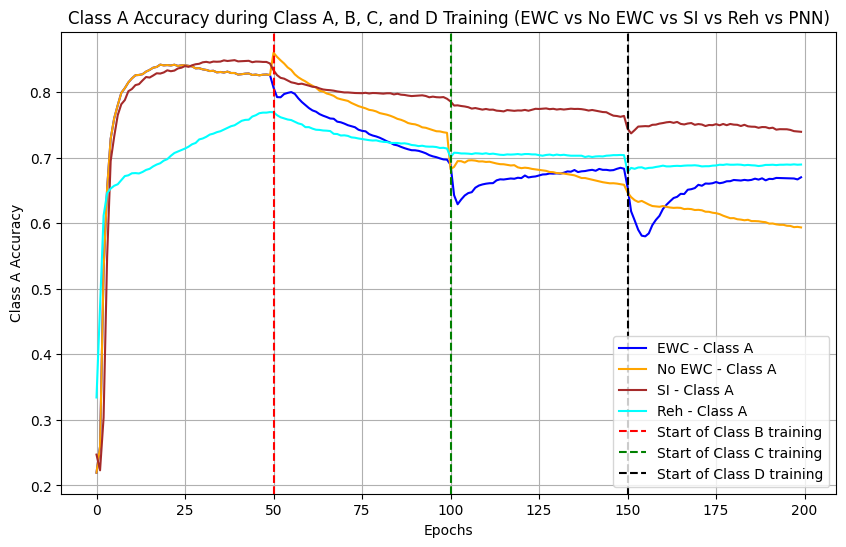

In [92]:
import matplotlib.pyplot as plt
import numpy as np
# Calculate the mean for Task A during Task A and Task B across all runs
ewc_initial_acc = np.mean(epoch_stats["ewc"]["A_during_A_val"], axis=0)  # Mean across runs
no_ewc_initial_acc = np.mean(epoch_stats["ewc"]["A_during_A_val"], axis=0)  # Same for No EWC
pnn_A_during_A = np.mean(epoch_stats_other["pnn"]["A_during_A_val"], axis=0) # Same for pnn
si_A_during_A = np.mean(epoch_stats_other["si"]["A_during_A_val"], axis=0) # Same for si
reh_A_during_A = np.mean(epoch_stats_other["reh"]["A_during_A_val"], axis=0) # Same for reh

# Now for Task A accuracy during Task B training
ewc_task_A_during_B = np.mean(epoch_stats["ewc"]["A_during_B_val"], axis=0)  # Average over runs
no_ewc_task_A_during_B = np.mean(epoch_stats_no_ewc["no_ewc"]["A_during_B_val"], axis=0)  # Same for No EWC
pnn_task_A_during_B = np.mean(epoch_stats_other["pnn"]["task_A_during_B"],axis=0) # Same for pnn
si_task_A_during_B = np.mean(epoch_stats_other["si"]["val_task_A_during_B"],axis=0) # Same for si
reh_task_A_during_B = np.mean(epoch_stats_other["reh"]["val_task_A_during_B"],axis=0) # Same for reh

# Now for Task A accuracy during Task C training
ewc_task_A_during_C = np.mean(epoch_stats["ewc"]["A_during_C_val"], axis=0)  # Average over runs
no_ewc_task_A_during_C = np.mean(epoch_stats_no_ewc["no_ewc"]["A_during_C_val"], axis=0)  # Same for No EWC
pnn_task_A_during_C = np.mean(epoch_stats_other["pnn"]["task_A_during_C"],axis=0) # Same for pnn
si_task_A_during_C = np.mean(epoch_stats_other["si"]["task_A_during_C"],axis=0) # Same for si
reh_task_A_during_C = np.mean(epoch_stats_other["reh"]["task_A_during_C"],axis=0) # Same for reh

# Now for Task A accuracy during Task D training
ewc_task_A_during_D = np.mean(epoch_stats["ewc"]["A_during_D_val"], axis=0)  # Average over runs
no_ewc_task_A_during_D = np.mean(epoch_stats_no_ewc["no_ewc"]["A_during_D_val"], axis=0)  # Same for No EWC
pnn_task_A_during_D = np.mean(epoch_stats_other["pnn"]["A_during_D_val"],axis=0) # Same for pnn
si_task_A_during_D = np.mean(epoch_stats_other["si"]["A_during_D_val"],axis=0) # Same for si
reh_task_A_during_D = np.mean(epoch_stats_other["reh"]["A_during_D_val"],axis=0) # Same for reh

# Concatenate the Class A accuracy during Class A and Task B phases
ewc_task_A_combined = np.concatenate([ewc_initial_acc, ewc_task_A_during_B,ewc_task_A_during_C,ewc_task_A_during_D])
no_ewc_task_A_combined = np.concatenate([no_ewc_initial_acc, no_ewc_task_A_during_B,no_ewc_task_A_during_C,no_ewc_task_A_during_D])
pnn_task_A_combined = np.concatenate([pnn_A_during_A, pnn_task_A_during_B,pnn_task_A_during_C,pnn_task_A_during_D])
si_task_A_combined = np.concatenate([si_A_during_A, si_task_A_during_B,si_task_A_during_C,si_task_A_during_D])
reh_task_A_combined = np.concatenate([reh_A_during_A, reh_task_A_during_B,reh_task_A_during_C,reh_task_A_during_D])

# X-axis: first half for Class A training, second half for Task B training
total_epochs = len(ewc_task_A_combined)
x_values = np.arange(total_epochs)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_values, ewc_task_A_combined, label='EWC - Class A', color='blue')
plt.plot(x_values, no_ewc_task_A_combined, label='No EWC - Class A', color='orange')
#plt.plot(x_values, pnn_task_A_combined, label='PNN - Class A', color='green')
plt.plot(x_values, si_task_A_combined, label='SI - Class A', color='brown')
plt.plot(x_values, reh_task_A_combined, label='Reh - Class A', color='cyan')

# Mark the point where Task B training begins
plt.axvline(x=len(ewc_initial_acc), color='red', linestyle='--', label='Start of Class B training')
plt.axvline(x=len(ewc_initial_acc) + len(ewc_task_A_during_B), color='green', linestyle='--', label='Start of Class C training')
plt.axvline(x=len(ewc_initial_acc) + len(ewc_task_A_during_B) + len(ewc_task_A_during_C), color='black', linestyle='--', label='Start of Class D training')


# Labels, title, and legend
plt.xlabel('Epochs')
plt.ylabel('Class A Accuracy')
plt.title('Class A Accuracy during Class A, B, C, and D Training (EWC vs No EWC vs SI vs Reh vs PNN)')
plt.legend()
plt.grid(True)

# Save and show the plot
#plt.savefig('cil_realworld_accuracy_plot_taskA.png')
plt.show()


In [49]:
epoch_stats_other["reh"]["B_during_A_val"]

[[0.23076923076923078,
  0.23076923076923078,
  0.23076923076923078,
  0.23076923076923078,
  0.23076923076923078,
  0.23076923076923078,
  0.23076923076923078,
  0.23076923076923078,
  0.23076923076923078,
  0.23076923076923078,
  0.23076923076923078,
  0.23076923076923078,
  0.23076923076923078,
  0.23076923076923078,
  0.23076923076923078,
  0.23076923076923078,
  0.23076923076923078,
  0.23076923076923078,
  0.23076923076923078,
  0.23076923076923078,
  0.23076923076923078,
  0.23076923076923078,
  0.23076923076923078,
  0.23076923076923078,
  0.23076923076923078,
  0.23076923076923078,
  0.23076923076923078,
  0.23076923076923078,
  0.23076923076923078,
  0.23076923076923078,
  0.2321187584345479,
  0.2321187584345479,
  0.2321187584345479,
  0.2321187584345479,
  0.2321187584345479,
  0.2321187584345479,
  0.2321187584345479,
  0.2321187584345479,
  0.2321187584345479,
  0.2321187584345479,
  0.2321187584345479,
  0.2321187584345479,
  0.2321187584345479,
  0.2321187584345479,
  

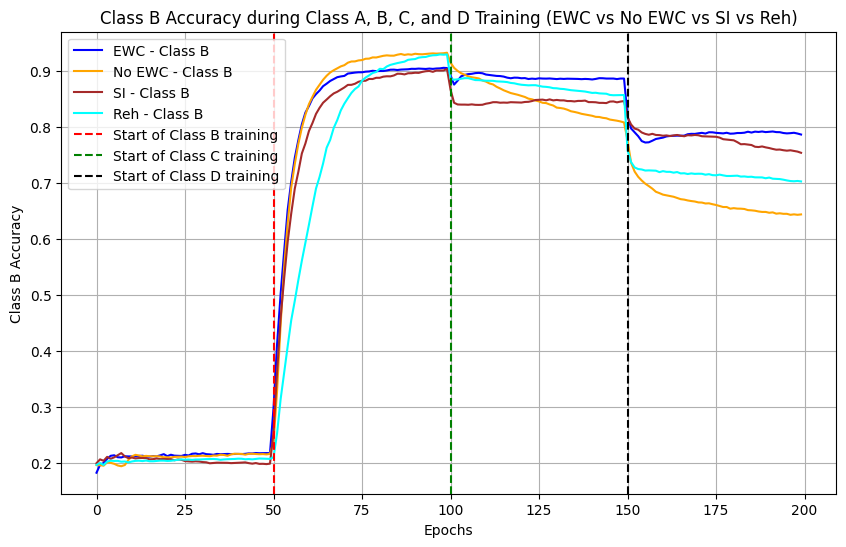

In [93]:
import matplotlib.pyplot as plt
import numpy as np
# Calculate the mean for Task A during Class B and Task B across all runs
ewc_B_during_A = np.mean(epoch_stats["ewc"]["B_during_A_val"], axis=0)  # Mean across runs
no_ewc_B_during_A = np.mean(epoch_stats_no_ewc["no_ewc"]["B_during_A_val"], axis=0)  # Same for No EWC
pnn_B_during_A = np.mean(epoch_stats_other["pnn"]["B_during_A_val"], axis=0) # Same for pnn
si_B_during_A = np.mean(epoch_stats_other["si"]["B_during_A_val"], axis=0) # Same for si
reh_B_during_A = np.mean(epoch_stats_other_reh["reh"]["B_during_A_val"], axis=0) # Same for reh

# Now Task B training
ewc_task_B = np.mean(epoch_stats["ewc"]["val_task_B"], axis=0)  # Average over runs
no_ewc_task_B = np.mean(epoch_stats_no_ewc["no_ewc"]["val_task_B"], axis=0)  # Same for No EWC
pnn_task_B = np.mean(epoch_stats_other["pnn"]["task_B"],axis=0) # Same for pnn
si_task_B = np.mean(epoch_stats_other["si"]["val_task_B"],axis=0) # Same for si
reh_task_B = np.mean(epoch_stats_other_reh["reh"]["val_task_B"],axis=0) # Same for reh

# Now for Class B accuracy during Task C training
ewc_task_B_during_C = np.mean(epoch_stats["ewc"]["B_during_C_val"], axis=0)  # Average over runs
no_ewc_task_B_during_C = np.mean(epoch_stats_no_ewc["no_ewc"]["B_during_C_val"], axis=0)  # Same for No EWC
pnn_task_B_during_C = np.mean(epoch_stats_other["pnn"]["task_B_during_C"],axis=0) # Same for pnn
si_task_B_during_C = np.mean(epoch_stats_other["si"]["val_task_B_during_C"],axis=0) # Same for si
reh_task_B_during_C = np.mean(epoch_stats_other_reh["reh"]["val_task_B_during_C"],axis=0) # Same for reh

# Now for Class B accuracy during Task D training
ewc_task_B_during_D = np.mean(epoch_stats["ewc"]["B_during_D_val"], axis=0)  # Average over runs
no_ewc_task_B_during_D = np.mean(epoch_stats_no_ewc["no_ewc"]["B_during_D_val"], axis=0)  # Same for No EWC
pnn_task_B_during_D = np.mean(epoch_stats_other["pnn"]["B_during_D_val"],axis=0) # Same for pnn
si_task_B_during_D = np.mean(epoch_stats_other["si"]["B_during_D_val"],axis=0) # Same for si
reh_task_B_during_D = np.mean(epoch_stats_other_reh["reh"]["B_during_D_val"],axis=0) # Same for reh

# Concatenate the Class B accuracy during Class B and Task B phases
ewc_task_A_combined_B = np.concatenate([ewc_B_during_A, ewc_task_B, ewc_task_B_during_C,ewc_task_B_during_D])
no_ewc_task_A_combined_B = np.concatenate([no_ewc_B_during_A,no_ewc_task_B, no_ewc_task_B_during_C,no_ewc_task_B_during_D])
pnn_task_A_combined_B = np.concatenate([pnn_B_during_A,pnn_task_B, pnn_task_B_during_C,pnn_task_B_during_D])
si_task_A_combined_B = np.concatenate([si_B_during_A,si_task_B, si_task_B_during_C,si_task_B_during_D])
reh_task_A_combined_B = np.concatenate([reh_B_during_A,reh_task_B, reh_task_B_during_C,reh_task_B_during_D])

# X-axis: first half for Class B training, second half for Task B training
total_epochs = len(ewc_task_A_combined_B)
x_values = np.arange(total_epochs)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_values, ewc_task_A_combined_B, label='EWC - Class B', color='blue')
plt.plot(x_values, no_ewc_task_A_combined_B, label='No EWC - Class B', color='orange')
#plt.plot(x_values, pnn_task_A_combined_B, label='PNN - Class B', color='green')
plt.plot(x_values, si_task_A_combined_B, label='SI - Class B', color='brown')
plt.plot(x_values, reh_task_A_combined_B, label='Reh - Class B', color='cyan')

# Mark the point where Task B training begins
plt.axvline(x=len(ewc_initial_acc), color='red', linestyle='--', label='Start of Class B training')
plt.axvline(x=len(ewc_initial_acc) + len(ewc_task_A_during_B), color='green', linestyle='--', label='Start of Class C training')
plt.axvline(x=len(ewc_initial_acc) + len(ewc_task_A_during_B) + len(ewc_task_A_during_C), color='black', linestyle='--', label='Start of Class D training')


# Labels, title, and legend
plt.xlabel('Epochs')
plt.ylabel('Class B Accuracy')
plt.title('Class B Accuracy during Class A, B, C, and D Training (EWC vs No EWC vs SI vs Reh)')
plt.legend()
plt.grid(True)

# Save and show the plot
#plt.savefig('cil_realworld_accuracy_plot_taskB.png')
plt.show()


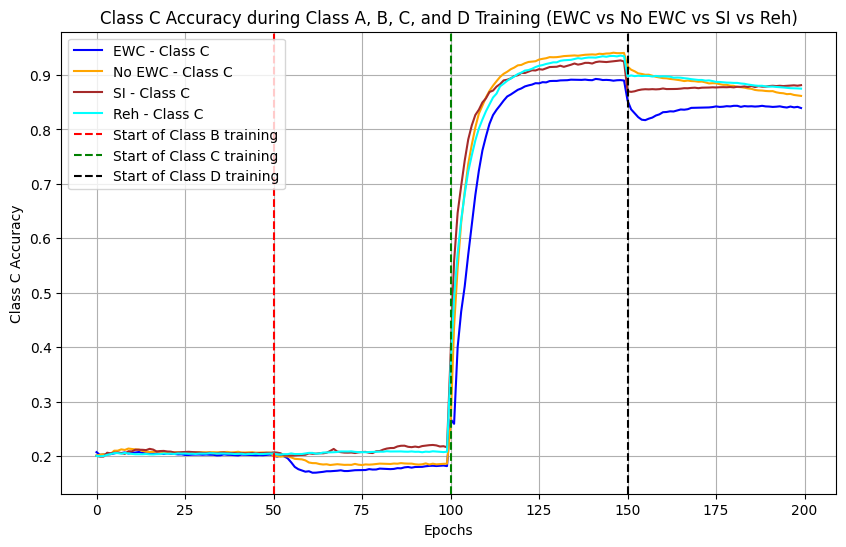

In [65]:
import matplotlib.pyplot as plt
# Calculate the mean for Task A during Task A and Task B across all runs
ewc_C_during_A = np.mean(epoch_stats["ewc"]["C_during_A_val"], axis=0)  # Mean across runs
no_ewc_C_during_A = np.mean(epoch_stats_no_ewc["no_ewc"]["C_during_A_val"], axis=0)  # Same for No EWC
pnn_C_during_A = np.mean(epoch_stats_other["pnn"]["C_during_A_val"], axis=0) # Same for pnn
si_C_during_A = np.mean(epoch_stats_other["si"]["C_during_A_val"], axis=0) # Same for si
reh_C_during_A = np.mean(epoch_stats_other_reh["reh"]["C_during_A_val"], axis=0) # Same for reh

# Now Task B training
ewc_task_C = np.mean(epoch_stats["ewc"]["val_task_C"], axis=0)  # Average over runs
no_ewc_task_C = np.mean(epoch_stats_no_ewc["no_ewc"]["val_task_C"], axis=0)  # Same for No EWC
pnn_task_C = np.mean(epoch_stats_other["pnn"]["val_task_C"],axis=0) # Same for pnn
si_task_C = np.mean(epoch_stats_other["si"]["val_task_C"],axis=0) # Same for si
reh_task_C = np.mean(epoch_stats_other_reh["reh"]["val_task_C"],axis=0) # Same for reh

# Now for Task A accuracy during Task C training
ewc_task_C_during_B = np.mean(epoch_stats["ewc"]["C_during_B_val"], axis=0)  # Average over runs
no_ewc_task_C_during_B = np.mean(epoch_stats_no_ewc["no_ewc"]["C_during_B_val"], axis=0)  # Same for No EWC
pnn_task_C_during_B = np.mean(epoch_stats_other["pnn"]["C_during_B_val"],axis=0) # Same for pnn
si_task_C_during_B = np.mean(epoch_stats_other["si"]["C_during_B_val"],axis=0) # Same for si
reh_task_C_during_B = np.mean(epoch_stats_other_reh["reh"]["C_during_B_val"],axis=0) # Same for reh

# Now for Task A accuracy during Task D training
ewc_task_C_during_D = np.mean(epoch_stats["ewc"]["C_during_D_val"], axis=0)  # Average over runs
no_ewc_task_C_during_D = np.mean(epoch_stats_no_ewc["no_ewc"]["C_during_D_val"], axis=0)  # Same for No EWC
pnn_task_C_during_D = np.mean(epoch_stats_other["pnn"]["C_during_D_val"],axis=0) # Same for pnn
si_task_C_during_D = np.mean(epoch_stats_other["si"]["C_during_D_val"],axis=0) # Same for si
reh_task_C_during_D = np.mean(epoch_stats_other_reh["reh"]["C_during_D_val"],axis=0) # Same for reh

# Concatenate the Task A accuracy during Task A and Task B phases
ewc_task_A_combined_C = np.concatenate([ewc_C_during_A, ewc_task_C_during_B, ewc_task_C,ewc_task_C_during_D])
no_ewc_task_A_combined_C = np.concatenate([no_ewc_C_during_A,no_ewc_task_C_during_B, no_ewc_task_C,no_ewc_task_C_during_D])
pnn_task_A_combined_C = np.concatenate([pnn_C_during_A,pnn_task_C_during_B, pnn_task_C,pnn_task_C_during_D])
si_task_A_combined_C = np.concatenate([si_C_during_A,si_task_C_during_B, si_task_C,si_task_C_during_D])
reh_task_A_combined_C = np.concatenate([reh_C_during_A,reh_task_C_during_B, reh_task_C,reh_task_C_during_D])

# X-axis: first half for Task A training, second half for Task B training
total_epochs = len(ewc_task_A_combined_C)
x_values = np.arange(total_epochs)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_values, ewc_task_A_combined_C, label='EWC - Class C', color='blue')
plt.plot(x_values, no_ewc_task_A_combined_C, label='No EWC - Class C', color='orange')
#plt.plot(x_values, pnn_task_A_combined_C, label='PNN - Class C', color='green')
plt.plot(x_values, si_task_A_combined_C, label='SI - Class C', color='brown')
plt.plot(x_values, reh_task_A_combined_C, label='Reh - Class C', color='cyan')

# Mark the point where Task B training begins
plt.axvline(x=len(ewc_initial_acc), color='red', linestyle='--', label='Start of Class B training')
plt.axvline(x=len(ewc_initial_acc) + len(ewc_task_A_during_B), color='green', linestyle='--', label='Start of Class C training')
plt.axvline(x=len(ewc_initial_acc) + len(ewc_task_A_during_B) + len(ewc_task_A_during_C), color='black', linestyle='--', label='Start of Class D training')


# Labels, title, and legend
plt.xlabel('Epochs')
plt.ylabel('Class C Accuracy')
plt.title('Class C Accuracy during Class A, B, C, and D Training (EWC vs No EWC vs SI vs Reh)')
plt.legend()
plt.grid(True)

# Save and show the plot
#plt.savefig('cil_realworld_accuracy_plot_taskC.png')
plt.show()


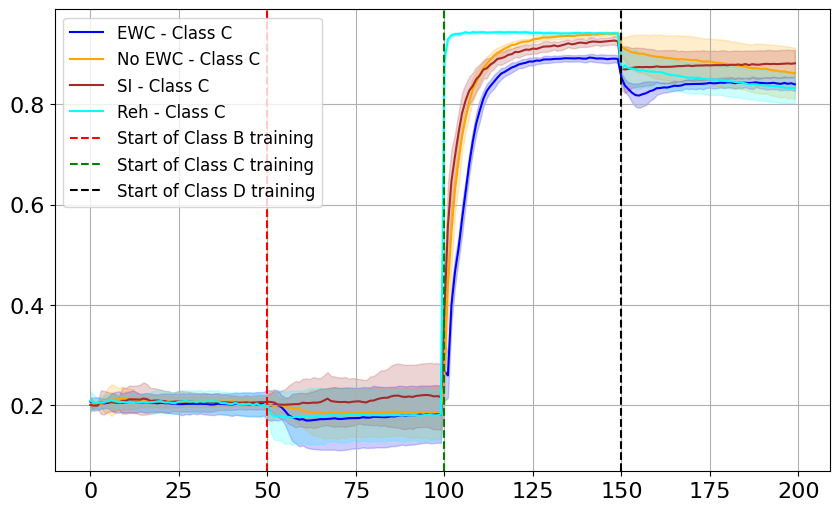

In [66]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the mean and standard deviation for Class C accuracy
ewc_C_during_A = np.mean(epoch_stats["ewc"]["C_during_A_val"], axis=0)
ewc_C_during_A_std = np.std(epoch_stats["ewc"]["C_during_A_val"], axis=0)

no_ewc_C_during_A = np.mean(epoch_stats_no_ewc["no_ewc"]["C_during_A_val"], axis=0)
no_ewc_C_during_A_std = np.std(epoch_stats_no_ewc["no_ewc"]["C_during_A_val"], axis=0)

pnn_C_during_A = np.mean(epoch_stats_other["pnn"]["C_during_A_val"], axis=0)
pnn_C_during_A_std = np.std(epoch_stats_other["pnn"]["C_during_A_val"], axis=0)

si_C_during_A = np.mean(epoch_stats_other["si"]["C_during_A_val"], axis=0)
si_C_during_A_std = np.std(epoch_stats_other["si"]["C_during_A_val"], axis=0)

reh_C_during_A = np.mean(epoch_stats_other["reh"]["C_during_A_val"], axis=0)
reh_C_during_A_std = np.std(epoch_stats_other["reh"]["C_during_A_val"], axis=0)

# Compute the mean and standard deviation for Task C training
ewc_task_C = np.mean(epoch_stats["ewc"]["val_task_C"], axis=0)
ewc_task_C_std = np.std(epoch_stats["ewc"]["val_task_C"], axis=0)

no_ewc_task_C = np.mean(epoch_stats_no_ewc["no_ewc"]["val_task_C"], axis=0)
no_ewc_task_C_std = np.std(epoch_stats_no_ewc["no_ewc"]["val_task_C"], axis=0)

pnn_task_C = np.mean(epoch_stats_other["pnn"]["val_task_C"], axis=0)
pnn_task_C_std = np.std(epoch_stats_other["pnn"]["val_task_C"], axis=0)

si_task_C = np.mean(epoch_stats_other["si"]["val_task_C"], axis=0)
si_task_C_std = np.std(epoch_stats_other["si"]["val_task_C"], axis=0)

reh_task_C = np.mean(epoch_stats_other["reh"]["val_task_C"], axis=0)
reh_task_C_std = np.std(epoch_stats_other["reh"]["val_task_C"], axis=0)

# Compute the mean and standard deviation for Class C accuracy during Class B training
ewc_task_C_during_B = np.mean(epoch_stats["ewc"]["C_during_B_val"], axis=0)
ewc_task_C_during_B_std = np.std(epoch_stats["ewc"]["C_during_B_val"], axis=0)

no_ewc_task_C_during_B = np.mean(epoch_stats_no_ewc["no_ewc"]["C_during_B_val"], axis=0)
no_ewc_task_C_during_B_std = np.std(epoch_stats_no_ewc["no_ewc"]["C_during_B_val"], axis=0)

pnn_task_C_during_B = np.mean(epoch_stats_other["pnn"]["C_during_B_val"], axis=0)
pnn_task_C_during_B_std = np.std(epoch_stats_other["pnn"]["C_during_B_val"], axis=0)

si_task_C_during_B = np.mean(epoch_stats_other["si"]["C_during_B_val"], axis=0)
si_task_C_during_B_std = np.std(epoch_stats_other["si"]["C_during_B_val"], axis=0)

reh_task_C_during_B = np.mean(epoch_stats_other["reh"]["C_during_B_val"], axis=0)
reh_task_C_during_B_std = np.std(epoch_stats_other["reh"]["C_during_B_val"], axis=0)

# Compute the mean and standard deviation for Class C accuracy during Class D training
ewc_task_C_during_D = np.mean(epoch_stats["ewc"]["C_during_D_val"], axis=0)
ewc_task_C_during_D_std = np.std(epoch_stats["ewc"]["C_during_D_val"], axis=0)

no_ewc_task_C_during_D = np.mean(epoch_stats_no_ewc["no_ewc"]["C_during_D_val"], axis=0)
no_ewc_task_C_during_D_std = np.std(epoch_stats_no_ewc["no_ewc"]["C_during_D_val"], axis=0)

pnn_task_C_during_D = np.mean(epoch_stats_other["pnn"]["C_during_D_val"], axis=0)
pnn_task_C_during_D_std = np.std(epoch_stats_other["pnn"]["C_during_D_val"], axis=0)

si_task_C_during_D = np.mean(epoch_stats_other["si"]["C_during_D_val"], axis=0)
si_task_C_during_D_std = np.std(epoch_stats_other["si"]["C_during_D_val"], axis=0)

reh_task_C_during_D = np.mean(epoch_stats_other["reh"]["C_during_D_val"], axis=0)
reh_task_C_during_D_std = np.std(epoch_stats_other["reh"]["C_during_D_val"], axis=0)

# Concatenate mean and standard deviation for all phases
ewc_task_A_combined_C = np.concatenate([ewc_C_during_A, ewc_task_C_during_B, ewc_task_C, ewc_task_C_during_D])
ewc_task_A_combined_C_std = np.concatenate([ewc_C_during_A_std, ewc_task_C_during_B_std, ewc_task_C_std, ewc_task_C_during_D_std])

no_ewc_task_A_combined_C = np.concatenate([no_ewc_C_during_A, no_ewc_task_C_during_B, no_ewc_task_C, no_ewc_task_C_during_D])
no_ewc_task_A_combined_C_std = np.concatenate([no_ewc_C_during_A_std, no_ewc_task_C_during_B_std, no_ewc_task_C_std, no_ewc_task_C_during_D_std])

pnn_task_A_combined_C = np.concatenate([pnn_C_during_A, pnn_task_C_during_B, pnn_task_C, pnn_task_C_during_D])
pnn_task_A_combined_C_std = np.concatenate([pnn_C_during_A_std, pnn_task_C_during_B_std, pnn_task_C_std, pnn_task_C_during_D_std])

si_task_A_combined_C = np.concatenate([si_C_during_A, si_task_C_during_B, si_task_C, si_task_C_during_D])
si_task_A_combined_C_std = np.concatenate([si_C_during_A_std, si_task_C_during_B_std, si_task_C_std, si_task_C_during_D_std])

reh_task_A_combined_C = np.concatenate([reh_C_during_A, reh_task_C_during_B, reh_task_C, reh_task_C_during_D])
reh_task_A_combined_C_std = np.concatenate([reh_C_during_A_std, reh_task_C_during_B_std, reh_task_C_std, reh_task_C_during_D_std])

# Define x-axis
total_epochs = len(ewc_task_A_combined_C)
x_values = np.arange(total_epochs)

# Plot with variance bands
plt.figure(figsize=(10, 6))

plt.plot(x_values, ewc_task_A_combined_C, label='EWC - Class C', color='blue')
plt.fill_between(x_values, ewc_task_A_combined_C - ewc_task_A_combined_C_std, ewc_task_A_combined_C + ewc_task_A_combined_C_std, color='blue', alpha=0.2)

plt.plot(x_values, no_ewc_task_A_combined_C, label='No EWC - Class C', color='orange')
plt.fill_between(x_values, no_ewc_task_A_combined_C - no_ewc_task_A_combined_C_std, no_ewc_task_A_combined_C + no_ewc_task_A_combined_C_std, color='orange', alpha=0.2)

plt.plot(x_values, si_task_A_combined_C, label='SI - Class C', color='brown')
plt.fill_between(x_values, si_task_A_combined_C - si_task_A_combined_C_std, si_task_A_combined_C + si_task_A_combined_C_std, color='brown', alpha=0.2)

plt.plot(x_values, reh_task_A_combined_C, label='Reh - Class C', color='cyan')
plt.fill_between(x_values, reh_task_A_combined_C - reh_task_A_combined_C_std, reh_task_A_combined_C + reh_task_A_combined_C_std, color='cyan', alpha=0.2)

plt.axvline(x=len(ewc_C_during_A), color='red', linestyle='--', label='Start of Class B training')
plt.axvline(x=len(ewc_C_during_A) + len(ewc_task_C_during_B), color='green', linestyle='--', label='Start of Class C training')
plt.axvline(x=len(ewc_C_during_A) + len(ewc_task_C_during_B) + len(ewc_task_C), color='black', linestyle='--', label='Start of Class D training')

plt.xticks(fontsize=16)                 # Font size for x-axis ticks
plt.yticks(fontsize=16) 
plt.legend(loc='upper left',fontsize=12)
plt.grid(True)

#plt.savefig('cil_realworld_accuracy_plot_taskC_with_variance_bigger.png')
plt.show()


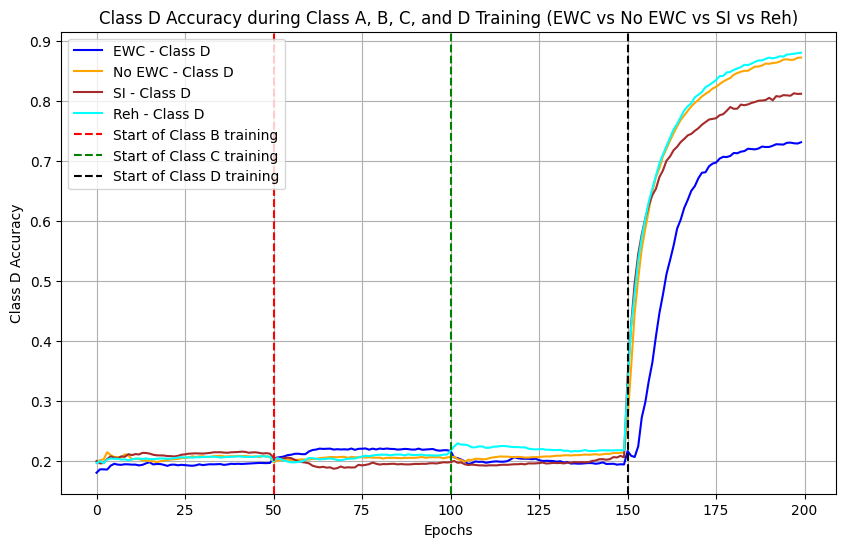

In [67]:
import matplotlib.pyplot as plt
# Calculate the mean for Task A during Task A and Task B across all runs
ewc_D_during_A = np.mean(epoch_stats["ewc"]["D_during_A_val"], axis=0)  # Mean across runs
no_ewc_D_during_A = np.mean(epoch_stats_no_ewc["no_ewc"]["D_during_A_val"], axis=0)  # Same for No EWC
pnn_D_during_A = np.mean(epoch_stats_other["pnn"]["D_during_A_val"], axis=0) # Same for pnn
si_D_during_A = np.mean(epoch_stats_other["si"]["D_during_A_val"], axis=0) # Same for si
reh_D_during_A = np.mean(epoch_stats_other_reh["reh"]["D_during_A_val"], axis=0) # Same for reh

# Now Task B training
ewc_task_D = np.mean(epoch_stats["ewc"]["val_task_D"], axis=0)  # Average over runs
no_ewc_task_D = np.mean(epoch_stats_no_ewc["no_ewc"]["val_task_D"], axis=0)  # Same for No EWC
pnn_task_D = np.mean(epoch_stats_other["pnn"]["val_task_D"],axis=0) # Same for pnn
si_task_D = np.mean(epoch_stats_other["si"]["val_task_D"],axis=0) # Same for si
reh_task_D = np.mean(epoch_stats_other_reh["reh"]["val_task_D"],axis=0) # Same for reh

# Now for Task A accuracy during Task C training
ewc_task_D_during_B = np.mean(epoch_stats["ewc"]["D_during_B_val"], axis=0)  # Average over runs
no_ewc_task_D_during_B = np.mean(epoch_stats_no_ewc["no_ewc"]["D_during_B_val"], axis=0)  # Same for No EWC
pnn_task_D_during_B = np.mean(epoch_stats_other["pnn"]["D_during_B_val"],axis=0) # Same for pnn
si_task_D_during_B = np.mean(epoch_stats_other["si"]["D_during_B_val"],axis=0) # Same for si
reh_task_D_during_B = np.mean(epoch_stats_other_reh["reh"]["D_during_B_val"],axis=0) # Same for reh

# Now for Task A accuracy during Task D training
ewc_task_D_during_C = np.mean(epoch_stats["ewc"]["D_during_C_val"], axis=0)  # Average over runs
no_ewc_task_D_during_C = np.mean(epoch_stats_no_ewc["no_ewc"]["D_during_C_val"], axis=0)  # Same for No EWC
pnn_task_D_during_C = np.mean(epoch_stats_other["pnn"]["D_during_C_val"],axis=0) # Same for pnn
si_task_D_during_C = np.mean(epoch_stats_other["si"]["D_during_C_val"],axis=0) # Same for si
reh_task_D_during_C = np.mean(epoch_stats_other_reh["reh"]["D_during_C_val"],axis=0) # Same for reh

# Concatenate the Task A accuracy during Task A and Task B phases
ewc_task_A_combined_D = np.concatenate([ewc_D_during_A, ewc_task_D_during_B, ewc_task_D_during_C,ewc_task_D])
no_ewc_task_A_combined_D = np.concatenate([no_ewc_D_during_A,no_ewc_task_D_during_B, no_ewc_task_D_during_C,no_ewc_task_D])
pnn_task_A_combined_D = np.concatenate([pnn_D_during_A,pnn_task_D_during_B, pnn_task_D_during_C,pnn_task_D])
si_task_A_combined_D = np.concatenate([si_D_during_A,si_task_D_during_B, si_task_D_during_C,si_task_D])
reh_task_A_combined_D = np.concatenate([reh_D_during_A,reh_task_D_during_B, reh_task_D_during_C,reh_task_D])

# X-axis: first half for Task A training, second half for Task B training
total_epochs = len(ewc_task_A_combined_D)
x_values = np.arange(total_epochs)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_values, ewc_task_A_combined_D, label='EWC - Class D', color='blue')
plt.plot(x_values, no_ewc_task_A_combined_D, label='No EWC - Class D', color='orange')
#plt.plot(x_values, pnn_task_A_combined_D, label='PNN - Class D', color='green')
plt.plot(x_values, si_task_A_combined_D, label='SI - Class D', color='brown')
plt.plot(x_values, reh_task_A_combined_D, label='Reh - Class D', color='cyan')

# Mark the point where Task B training begins
plt.axvline(x=len(ewc_initial_acc), color='red', linestyle='--', label='Start of Class B training')
plt.axvline(x=len(ewc_initial_acc) + len(ewc_task_A_during_B), color='green', linestyle='--', label='Start of Class C training')
plt.axvline(x=len(ewc_initial_acc) + len(ewc_task_A_during_B) + len(ewc_task_A_during_C), color='black', linestyle='--', label='Start of Class D training')


# Labels, title, and legend
plt.xlabel('Epochs')
plt.ylabel('Class D Accuracy')
plt.title('Class D Accuracy during Class A, B, C, and D Training (EWC vs No EWC vs SI vs Reh)')
plt.legend()
plt.grid(True)

# Save and show the plot
#plt.savefig('cil_realworld_accuracy_plot_taskD.png')
plt.show()


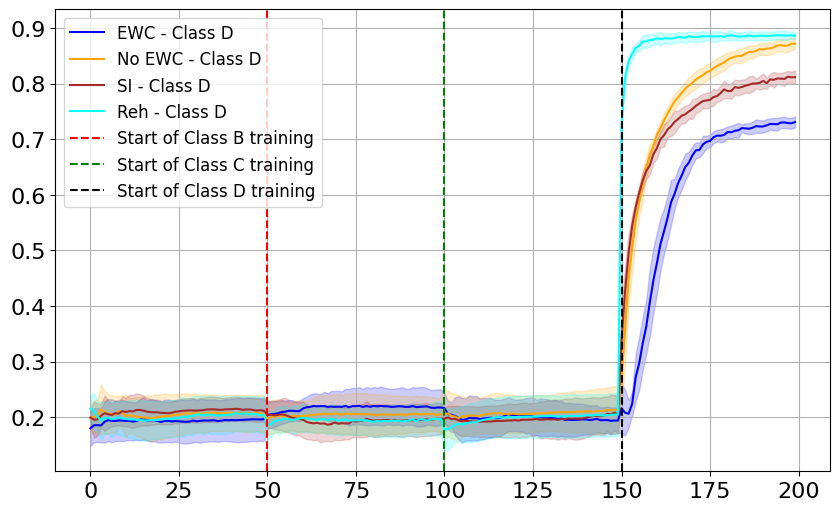

In [68]:
import matplotlib.pyplot as plt
import numpy as np

# Compute the mean and standard deviation for Class D accuracy
ewc_D_during_A = np.mean(epoch_stats["ewc"]["D_during_A_val"], axis=0)
ewc_D_during_A_std = np.std(epoch_stats["ewc"]["D_during_A_val"], axis=0)

no_ewc_D_during_A = np.mean(epoch_stats_no_ewc["no_ewc"]["D_during_A_val"], axis=0)
no_ewc_D_during_A_std = np.std(epoch_stats_no_ewc["no_ewc"]["D_during_A_val"], axis=0)

pnn_D_during_A = np.mean(epoch_stats_other["pnn"]["D_during_A_val"], axis=0)
pnn_D_during_A_std = np.std(epoch_stats_other["pnn"]["D_during_A_val"], axis=0)

si_D_during_A = np.mean(epoch_stats_other["si"]["D_during_A_val"], axis=0)
si_D_during_A_std = np.std(epoch_stats_other["si"]["D_during_A_val"], axis=0)

reh_D_during_A = np.mean(epoch_stats_other["reh"]["D_during_A_val"], axis=0)
reh_D_during_A_std = np.std(epoch_stats_other["reh"]["D_during_A_val"], axis=0)

# Compute the mean and standard deviation for Task D training
ewc_task_D = np.mean(epoch_stats["ewc"]["val_task_D"], axis=0)
ewc_task_D_std = np.std(epoch_stats["ewc"]["val_task_D"], axis=0)

no_ewc_task_D = np.mean(epoch_stats_no_ewc["no_ewc"]["val_task_D"], axis=0)
no_ewc_task_D_std = np.std(epoch_stats_no_ewc["no_ewc"]["val_task_D"], axis=0)

pnn_task_D = np.mean(epoch_stats_other["pnn"]["val_task_D"], axis=0)
pnn_task_D_std = np.std(epoch_stats_other["pnn"]["val_task_D"], axis=0)

si_task_D = np.mean(epoch_stats_other["si"]["val_task_D"], axis=0)
si_task_D_std = np.std(epoch_stats_other["si"]["val_task_D"], axis=0)

reh_task_D = np.mean(epoch_stats_other["reh"]["val_task_D"], axis=0)
reh_task_D_std = np.std(epoch_stats_other["reh"]["val_task_D"], axis=0)

# Compute the mean and standard deviation for Class D accuracy during Class B training
ewc_task_D_during_B = np.mean(epoch_stats["ewc"]["D_during_B_val"], axis=0)
ewc_task_D_during_B_std = np.std(epoch_stats["ewc"]["D_during_B_val"], axis=0)

no_ewc_task_D_during_B = np.mean(epoch_stats_no_ewc["no_ewc"]["D_during_B_val"], axis=0)
no_ewc_task_D_during_B_std = np.std(epoch_stats_no_ewc["no_ewc"]["D_during_B_val"], axis=0)

pnn_task_D_during_B = np.mean(epoch_stats_other["pnn"]["D_during_B_val"], axis=0)
pnn_task_D_during_B_std = np.std(epoch_stats_other["pnn"]["D_during_B_val"], axis=0)

si_task_D_during_B = np.mean(epoch_stats_other["si"]["D_during_B_val"], axis=0)
si_task_D_during_B_std = np.std(epoch_stats_other["si"]["D_during_B_val"], axis=0)

reh_task_D_during_B = np.mean(epoch_stats_other["reh"]["D_during_B_val"], axis=0)
reh_task_D_during_B_std = np.std(epoch_stats_other["reh"]["D_during_B_val"], axis=0)

# Compute the mean and standard deviation for Class D accuracy during Class C training
ewc_task_D_during_C = np.mean(epoch_stats["ewc"]["D_during_C_val"], axis=0)
ewc_task_D_during_C_std = np.std(epoch_stats["ewc"]["D_during_C_val"], axis=0)

no_ewc_task_D_during_C = np.mean(epoch_stats_no_ewc["no_ewc"]["D_during_C_val"], axis=0)
no_ewc_task_D_during_C_std = np.std(epoch_stats_no_ewc["no_ewc"]["D_during_C_val"], axis=0)

pnn_task_D_during_C = np.mean(epoch_stats_other["pnn"]["D_during_C_val"], axis=0)
pnn_task_D_during_C_std = np.std(epoch_stats_other["pnn"]["D_during_C_val"], axis=0)

si_task_D_during_C = np.mean(epoch_stats_other["si"]["D_during_C_val"], axis=0)
si_task_D_during_C_std = np.std(epoch_stats_other["si"]["D_during_C_val"], axis=0)

reh_task_D_during_C = np.mean(epoch_stats_other["reh"]["D_during_C_val"], axis=0)
reh_task_D_during_C_std = np.std(epoch_stats_other["reh"]["D_during_C_val"], axis=0)

# Concatenate mean and standard deviation for all phases
ewc_task_A_combined_D = np.concatenate([ewc_D_during_A, ewc_task_D_during_B, ewc_task_D_during_C, ewc_task_D])
ewc_task_A_combined_D_std = np.concatenate([ewc_D_during_A_std, ewc_task_D_during_B_std, ewc_task_D_during_C_std, ewc_task_D_std])

no_ewc_task_A_combined_D = np.concatenate([no_ewc_D_during_A, no_ewc_task_D_during_B, no_ewc_task_D_during_C, no_ewc_task_D])
no_ewc_task_A_combined_D_std = np.concatenate([no_ewc_D_during_A_std, no_ewc_task_D_during_B_std, no_ewc_task_D_during_C_std, no_ewc_task_D_std])

pnn_task_A_combined_D = np.concatenate([pnn_D_during_A, pnn_task_D_during_B, pnn_task_D_during_C, pnn_task_D])
pnn_task_A_combined_D_std = np.concatenate([pnn_D_during_A_std, pnn_task_D_during_B_std, pnn_task_D_during_C_std, pnn_task_D_std])

si_task_A_combined_D = np.concatenate([si_D_during_A, si_task_D_during_B, si_task_D_during_C, si_task_D])
si_task_A_combined_D_std = np.concatenate([si_D_during_A_std, si_task_D_during_B_std, si_task_D_during_C_std, si_task_D_std])

reh_task_A_combined_D = np.concatenate([reh_D_during_A, reh_task_D_during_B, reh_task_D_during_C, reh_task_D])
reh_task_A_combined_D_std = np.concatenate([reh_D_during_A_std, reh_task_D_during_B_std, reh_task_D_during_C_std, reh_task_D_std])

# Define x-axis
total_epochs = len(ewc_task_A_combined_D)
x_values = np.arange(total_epochs)

# Plot with variance bands
plt.figure(figsize=(10, 6))

plt.plot(x_values, ewc_task_A_combined_D, label='EWC - Class D', color='blue')
plt.fill_between(x_values, ewc_task_A_combined_D - ewc_task_A_combined_D_std, ewc_task_A_combined_D + ewc_task_A_combined_D_std, color='blue', alpha=0.2)

plt.plot(x_values, no_ewc_task_A_combined_D, label='No EWC - Class D', color='orange')
plt.fill_between(x_values, no_ewc_task_A_combined_D - no_ewc_task_A_combined_D_std, no_ewc_task_A_combined_D + no_ewc_task_A_combined_D_std, color='orange', alpha=0.2)

plt.plot(x_values, si_task_A_combined_D, label='SI - Class D', color='brown')
plt.fill_between(x_values, si_task_A_combined_D - si_task_A_combined_D_std, si_task_A_combined_D + si_task_A_combined_D_std, color='brown', alpha=0.2)

plt.plot(x_values, reh_task_A_combined_D, label='Reh - Class D', color='cyan')
plt.fill_between(x_values, reh_task_A_combined_D - reh_task_A_combined_D_std, reh_task_A_combined_D + reh_task_A_combined_D_std, color='cyan', alpha=0.2)

plt.axvline(x=len(ewc_D_during_A), color='red', linestyle='--', label='Start of Class B training')
plt.axvline(x=len(ewc_D_during_A) + len(ewc_task_D_during_B), color='green', linestyle='--', label='Start of Class C training')
plt.axvline(x=len(ewc_D_during_A) + len(ewc_task_D_during_B) + len(ewc_task_D_during_C), color='black', linestyle='--', label='Start of Class D training')

plt.xticks(fontsize=16)                 # Font size for x-axis ticks
plt.yticks(fontsize=16) 
plt.legend(loc='upper left',fontsize=12)
plt.grid(True)

#plt.savefig('cil_realworld_accuracy_plot_taskD_with_variance_bigger.png')
plt.show()


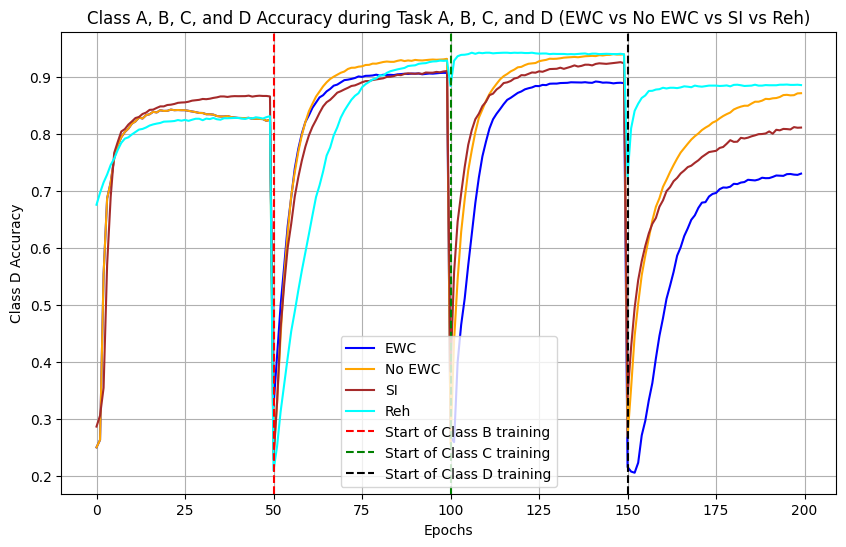

In [69]:
# Concatenate the Task A accuracy during Task A and Task B phases
ewc_task_A_combined_all = np.concatenate([ewc_initial_acc, ewc_task_B, ewc_task_C,ewc_task_D])
no_ewc_task_A_combined_all = np.concatenate([no_ewc_initial_acc, no_ewc_task_B, no_ewc_task_C,no_ewc_task_D])
pnn_task_A_combined_all = np.concatenate([pnn_A_during_A, pnn_task_B, pnn_task_C,pnn_task_D])
si_task_A_combined_all = np.concatenate([si_A_during_A, si_task_B, si_task_C,si_task_D])
reh_task_A_combined_all = np.concatenate([reh_A_during_A, reh_task_B, reh_task_C,reh_task_D])

# X-axis: first half for Task A training, second half for Task B training
total_epochs = len(ewc_task_A_combined_all)
x_values = np.arange(total_epochs)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_values, ewc_task_A_combined_all, label='EWC', color='blue')
plt.plot(x_values, no_ewc_task_A_combined_all, label='No EWC', color='orange')
#plt.plot(x_values, pnn_task_A_combined_all, label='PNN', color='green')
plt.plot(x_values, si_task_A_combined_all, label='SI', color='brown')
plt.plot(x_values, reh_task_A_combined_all, label='Reh', color='cyan')

# Mark the point where Task B training begins
plt.axvline(x=len(ewc_initial_acc), color='red', linestyle='--', label='Start of Class B training')
plt.axvline(x=len(ewc_initial_acc) + len(ewc_task_A_during_B), color='green', linestyle='--', label='Start of Class C training')
plt.axvline(x=len(ewc_initial_acc) + len(ewc_task_A_during_B) + len(ewc_task_A_during_C), color='black', linestyle='--', label='Start of Class D training')


# Labels, title, and legend
plt.xlabel('Epochs')
plt.ylabel('Class D Accuracy')
plt.title('Class A, B, C, and D Accuracy during Task A, B, C, and D (EWC vs No EWC vs SI vs Reh)')
plt.legend()
plt.grid(True)

# Save and show the plot
#plt.savefig('cil_realworld_accuracy_plot_AllTask.png')
plt.show()

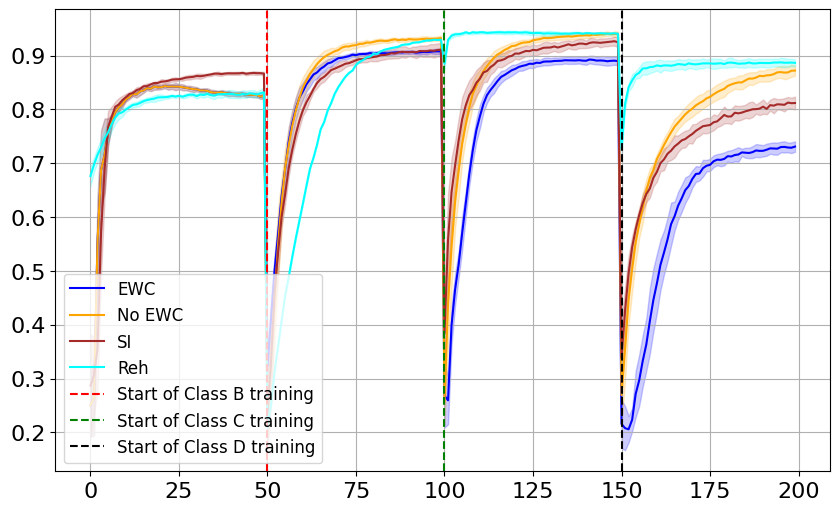

In [70]:
import matplotlib.pyplot as plt
import numpy as np

# Compute the mean and standard deviation for all phases
ewc_task_A_combined_all = np.concatenate([ewc_initial_acc, ewc_task_B, ewc_task_C, ewc_task_D])
ewc_task_A_combined_all_std = np.concatenate([ewc_initial_std, ewc_task_B_std, ewc_task_C_std, ewc_task_D_std])

no_ewc_task_A_combined_all = np.concatenate([no_ewc_initial_acc, no_ewc_task_B, no_ewc_task_C, no_ewc_task_D])
no_ewc_task_A_combined_all_std = np.concatenate([no_ewc_initial_std, no_ewc_task_B_std, no_ewc_task_C_std, no_ewc_task_D_std])

si_task_A_combined_all = np.concatenate([si_A_during_A, si_task_B, si_task_C, si_task_D])
si_task_A_combined_all_std = np.concatenate([si_A_during_A_std, si_task_B_std, si_task_C_std, si_task_D_std])

reh_task_A_combined_all = np.concatenate([reh_A_during_A, reh_task_B, reh_task_C, reh_task_D])
reh_task_A_combined_all_std = np.concatenate([reh_A_during_A_std, reh_task_B_std, reh_task_C_std, reh_task_D_std])

# Define x-axis
total_epochs = len(ewc_task_A_combined_all)
x_values = np.arange(total_epochs)

# Plot with variance bands
plt.figure(figsize=(10, 6))

# Plot EWC with variance band
plt.plot(x_values, ewc_task_A_combined_all, label='EWC', color='blue')
plt.fill_between(x_values, ewc_task_A_combined_all - ewc_task_A_combined_all_std, ewc_task_A_combined_all + ewc_task_A_combined_all_std, color='blue', alpha=0.2)

# Plot No EWC with variance band
plt.plot(x_values, no_ewc_task_A_combined_all, label='No EWC', color='orange')
plt.fill_between(x_values, no_ewc_task_A_combined_all - no_ewc_task_A_combined_all_std, no_ewc_task_A_combined_all + no_ewc_task_A_combined_all_std, color='orange', alpha=0.2)

# Plot SI with variance band
plt.plot(x_values, si_task_A_combined_all, label='SI', color='brown')
plt.fill_between(x_values, si_task_A_combined_all - si_task_A_combined_all_std, si_task_A_combined_all + si_task_A_combined_all_std, color='brown', alpha=0.2)

# Plot Rehearsal with variance band
plt.plot(x_values, reh_task_A_combined_all, label='Reh', color='cyan')
plt.fill_between(x_values, reh_task_A_combined_all - reh_task_A_combined_all_std, reh_task_A_combined_all + reh_task_A_combined_all_std, color='cyan', alpha=0.2)

# Mark the transition points
plt.axvline(x=len(ewc_initial_acc), color='red', linestyle='--', label='Start of Class B training')
plt.axvline(x=len(ewc_initial_acc) + len(ewc_task_B), color='green', linestyle='--', label='Start of Class C training')
plt.axvline(x=len(ewc_initial_acc) + len(ewc_task_B) + len(ewc_task_C), color='black', linestyle='--', label='Start of Class D training')

# Labels, title, and legend
plt.xticks(fontsize=16)                 # Font size for x-axis ticks
plt.yticks(fontsize=16) 
plt.legend(loc='lower left',fontsize=12)
plt.grid(True)

# Save and show the plot
#plt.savefig('cil_realworld_accuracy_plot_AllTask_with_variance_bigger.png')
plt.show()


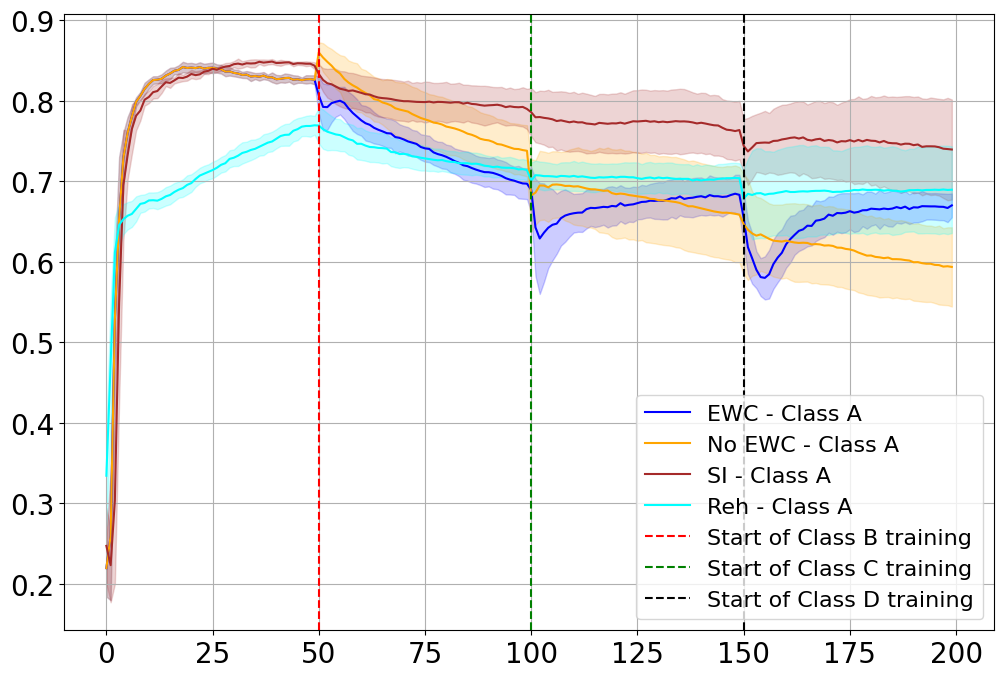

In [95]:
# Calculate mean and standard deviation for Task A during Task A, B, C, and D
ewc_initial_mean = np.mean(epoch_stats["ewc"]["A_during_A_val"], axis=0)
ewc_initial_std = np.std(epoch_stats["ewc"]["A_during_A_val"], axis=0)

no_ewc_initial_mean = np.mean(epoch_stats["ewc"]["A_during_A_val"], axis=0)
no_ewc_initial_std = np.std(epoch_stats["ewc"]["A_during_A_val"], axis=0)

pnn_A_during_A_mean = np.mean(epoch_stats_other["pnn"]["A_during_A_val"], axis=0)
pnn_A_during_A_std = np.std(epoch_stats_other["pnn"]["A_during_A_val"], axis=0)

si_A_during_A_mean = np.mean(epoch_stats_other["si"]["A_during_A_val"], axis=0)
si_A_during_A_std = np.std(epoch_stats_other["si"]["A_during_A_val"], axis=0)

reh_A_during_A_mean = np.mean(epoch_stats_other["reh"]["A_during_A_val"], axis=0)
reh_A_during_A_std = np.std(epoch_stats_other["reh"]["A_during_A_val"], axis=0)

# Concatenate means and standard deviations for all phases
ewc_task_A_combined_mean = np.concatenate([ewc_initial_mean, ewc_task_A_during_B, ewc_task_A_during_C, ewc_task_A_during_D])
ewc_task_A_combined_std = np.concatenate([ewc_initial_std, np.std(epoch_stats["ewc"]["A_during_B_val"], axis=0), 
                                          np.std(epoch_stats["ewc"]["A_during_C_val"], axis=0), 
                                          np.std(epoch_stats["ewc"]["A_during_D_val"], axis=0)])

no_ewc_task_A_combined_mean = np.concatenate([no_ewc_initial_mean, no_ewc_task_A_during_B, no_ewc_task_A_during_C, no_ewc_task_A_during_D])
no_ewc_task_A_combined_std = np.concatenate([no_ewc_initial_std, np.std(epoch_stats_no_ewc["no_ewc"]["A_during_B_val"], axis=0),
                                             np.std(epoch_stats_no_ewc["no_ewc"]["A_during_C_val"], axis=0),
                                             np.std(epoch_stats_no_ewc["no_ewc"]["A_during_D_val"], axis=0)])

si_task_A_combined_mean = np.concatenate([si_A_during_A_mean, si_task_A_during_B, si_task_A_during_C, si_task_A_during_D])
si_task_A_combined_std = np.concatenate([si_A_during_A_std, np.std(epoch_stats_other["si"]["val_task_A_during_B"], axis=0),
                                         np.std(epoch_stats_other["si"]["val_task_A_during_C"], axis=0),
                                         np.std(epoch_stats_other["si"]["A_during_D_val"], axis=0)])

reh_task_A_combined_mean = np.concatenate([reh_A_during_A_mean, reh_task_A_during_B, reh_task_A_during_C, reh_task_A_during_D])
reh_task_A_combined_std = np.concatenate([reh_A_during_A_std, np.std(epoch_stats_other_reh["reh"]["val_task_A_during_B"], axis=0),
                                          np.std(epoch_stats_other_reh["reh"]["val_task_A_during_C"], axis=0),
                                          np.std(epoch_stats_other_reh["reh"]["A_during_D_val"], axis=0)])

# X-axis: first half for Task A training, second half for other tasks
x_values = np.arange(len(ewc_task_A_combined_mean))

# Plotting with variance
plt.figure(figsize=(12, 8))

# EWC
plt.plot(x_values, ewc_task_A_combined_mean, label='EWC - Class A', color='blue')
plt.fill_between(x_values, 
                 ewc_task_A_combined_mean - ewc_task_A_combined_std, 
                 ewc_task_A_combined_mean + ewc_task_A_combined_std, 
                 color='blue', alpha=0.2)

# No EWC
plt.plot(x_values, no_ewc_task_A_combined_mean, label='No EWC - Class A', color='orange')
plt.fill_between(x_values, 
                 no_ewc_task_A_combined_mean - no_ewc_task_A_combined_std, 
                 no_ewc_task_A_combined_mean + no_ewc_task_A_combined_std, 
                 color='orange', alpha=0.2)

# SI
plt.plot(x_values, si_task_A_combined_mean, label='SI - Class A', color='brown')
plt.fill_between(x_values, 
                 si_task_A_combined_mean - si_task_A_combined_std, 
                 si_task_A_combined_mean + si_task_A_combined_std, 
                 color='brown', alpha=0.2)

# Reh
plt.plot(x_values, reh_task_A_combined_mean, label='Reh - Class A', color='cyan')
plt.fill_between(x_values, 
                 reh_task_A_combined_mean - reh_task_A_combined_std, 
                 reh_task_A_combined_mean + reh_task_A_combined_std, 
                 color='cyan', alpha=0.2)

# Task Training Phase Lines
plt.axvline(x=len(ewc_initial_acc), color='red', linestyle='--', label='Start of Class B training')
plt.axvline(x=len(ewc_initial_acc) + len(ewc_task_A_during_B), color='green', linestyle='--', label='Start of Class C training')
plt.axvline(x=len(ewc_initial_acc) + len(ewc_task_A_during_B) + len(ewc_task_A_during_C), color='black', linestyle='--', label='Start of Class D training')

# Labels, title, and legend
plt.xticks(fontsize=20)                 # Font size for x-axis ticks
plt.yticks(fontsize=20) 
plt.legend(fontsize=16)
plt.grid(True)

# Save and Show
#plt.savefig('cil_realworld_accuracy_plot_taskA_with_variance_bigger.png')
plt.show()


In [59]:
si_task_A_during_B

array([0.80339943, 0.79830028, 0.79815864, 0.79745042, 0.79660057,
       0.79475921, 0.79447592, 0.79334278, 0.79376771, 0.79390935,
       0.79461756, 0.7927762 , 0.79022663, 0.78796034, 0.78838527,
       0.7878187 , 0.78640227, 0.78640227, 0.78597734, 0.78441926,
       0.78541076, 0.78569405, 0.78456091, 0.78371105, 0.78498584,
       0.78371105, 0.78441926, 0.78385269, 0.78314448, 0.7815864 ,
       0.78101983, 0.77988669, 0.77932011, 0.7805949 , 0.77903683,
       0.78116147, 0.78087819, 0.78144476, 0.78130312, 0.78045326,
       0.77974504, 0.78031161, 0.7796034 , 0.78031161, 0.7805949 ,
       0.78101983, 0.77917847, 0.77932011, 0.7805949 , 0.77903683])

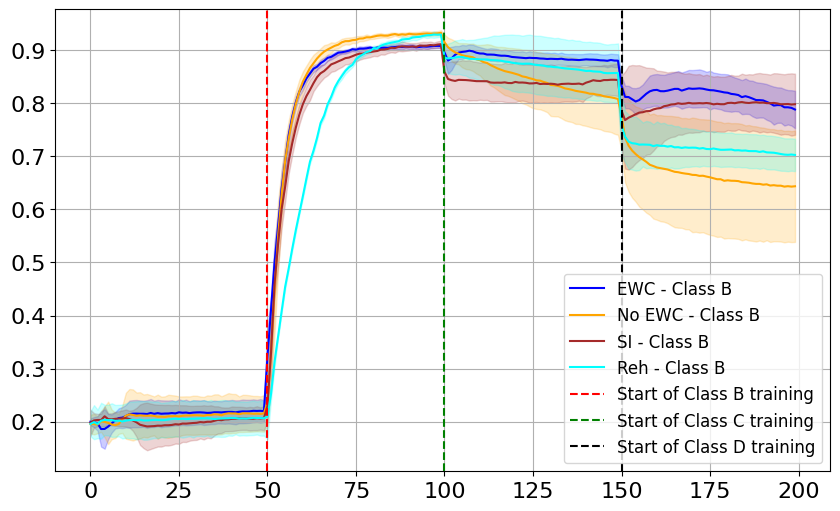

In [72]:
# Calculate standard deviations for variance bands
ewc_B_during_A_std = np.std(epoch_stats["ewc"]["B_during_A_val"], axis=0)
no_ewc_B_during_A_std = np.std(epoch_stats_no_ewc["no_ewc"]["B_during_A_val"], axis=0)
si_B_during_A_std = np.std(epoch_stats_other["si"]["B_during_A_val"], axis=0)
reh_B_during_A_std = np.std(epoch_stats_other["reh"]["B_during_A_val"], axis=0)

ewc_task_B_std = np.std(epoch_stats["ewc"]["val_task_B"], axis=0)
no_ewc_task_B_std = np.std(epoch_stats_no_ewc["no_ewc"]["val_task_B"], axis=0)
si_task_B_std = np.std(epoch_stats_other["si"]["val_task_B"], axis=0)
reh_task_B_std = np.std(epoch_stats_other["reh"]["val_task_B"], axis=0)

ewc_task_B_during_C_std = np.std(epoch_stats["ewc"]["B_during_C_val"], axis=0)
no_ewc_task_B_during_C_std = np.std(epoch_stats_no_ewc["no_ewc"]["B_during_C_val"], axis=0)
si_task_B_during_C_std = np.std(epoch_stats_other["si"]["task_B_during_C"], axis=0)
reh_task_B_during_C_std = np.std(epoch_stats_other_reh["reh"]["task_B_during_C"], axis=0)

ewc_task_B_during_D_std = np.std(epoch_stats["ewc"]["B_during_D_val"], axis=0)
no_ewc_task_B_during_D_std = np.std(epoch_stats_no_ewc["no_ewc"]["B_during_D_val"], axis=0)
si_task_B_during_D_std = np.std(epoch_stats_other["si"]["B_during_D_val"], axis=0)
reh_task_B_during_D_std = np.std(epoch_stats_other["reh"]["B_during_D_val"], axis=0)

# Combine mean and std into final arrays for plotting
ewc_task_A_combined_std = np.concatenate([ewc_B_during_A_std, ewc_task_B_std, ewc_task_B_during_C_std, ewc_task_B_during_D_std])
no_ewc_task_A_combined_std = np.concatenate([no_ewc_B_during_A_std, no_ewc_task_B_std, no_ewc_task_B_during_C_std, no_ewc_task_B_during_D_std])
si_task_A_combined_std = np.concatenate([si_B_during_A_std, si_task_B_std, si_task_B_during_C_std, si_task_B_during_D_std])
reh_task_A_combined_std = np.concatenate([reh_B_during_A_std, reh_task_B_std, reh_task_B_during_C_std, reh_task_B_during_D_std])

# Plot with variance bands
plt.figure(figsize=(10, 6))
plt.plot(x_values, ewc_task_A_combined_B, label='EWC - Class B', color='blue')
plt.fill_between(x_values, ewc_task_A_combined_B - ewc_task_A_combined_std, ewc_task_A_combined_B + ewc_task_A_combined_std, color='blue', alpha=0.2)

plt.plot(x_values, no_ewc_task_A_combined_B, label='No EWC - Class B', color='orange')
plt.fill_between(x_values, no_ewc_task_A_combined_B - no_ewc_task_A_combined_std, no_ewc_task_A_combined_B + no_ewc_task_A_combined_std, color='orange', alpha=0.2)

plt.plot(x_values, si_task_A_combined_B, label='SI - Class B', color='brown')
plt.fill_between(x_values, si_task_A_combined_B - si_task_A_combined_std, si_task_A_combined_B + si_task_A_combined_std, color='brown', alpha=0.2)

plt.plot(x_values, reh_task_A_combined_B, label='Reh - Class B', color='cyan')
plt.fill_between(x_values, reh_task_A_combined_B - reh_task_A_combined_std, reh_task_A_combined_B + reh_task_A_combined_std, color='cyan', alpha=0.2)

# Mark phase changes
plt.axvline(x=len(ewc_B_during_A), color='red', linestyle='--', label='Start of Class B training')
plt.axvline(x=len(ewc_B_during_A) + len(ewc_task_B), color='green', linestyle='--', label='Start of Class C training')
plt.axvline(x=len(ewc_B_during_A) + len(ewc_task_B) + len(ewc_task_B_during_C), color='black', linestyle='--', label='Start of Class D training')

# Labels, title, and legend
plt.xticks(fontsize=16)                 # Font size for x-axis ticks
plt.yticks(fontsize=16) 
plt.legend(fontsize=12)
plt.grid(True)

# Save and show the plot
#plt.savefig('cil_realworld_accuracy_plot_taskB_with_variance_bigger.png')
plt.show()


In [80]:
reh_stats_B

(0.7710638297872341,
 0.7773049645390071,
 0.7588652482269503,
 0.7847985457440116,
 0.7573291138304565)

In [94]:
# Extract data directly from dictionaries without modifying their original structure
import pandas as pd
# Helper function to calculate max, min, and mean for final epoch from a dictionary
def calculate_final_epoch_stats_from_dict(data_dict, key):
    data = np.array(data_dict[key])  # Convert to NumPy array
    max_final = np.max(data[:, -1])  # Max of the final epoch
    min_final = np.min(data[:, -1])  # Min of the final epoch
    mean_final = np.mean(data[:, -1])  # Mean of the final epoch
    return max_final, min_final, mean_final

# epoch_stats
# epoch_stats_other
# epoch_stats_other_reh
# epoch_stats_no_ewc

# Average of the final epoch for Task A during Task A training
avg_final_epoch_task_A_A_ewc = np.mean(np.array(epoch_stats["ewc"]["A_during_A_val"])[:, -1])
avg_final_epoch_task_A_A = np.mean(np.array(epoch_stats["ewc"]["A_during_A_val"])[:, -1])
avg_final_epoch_task_A_A_si = np.mean(np.array(epoch_stats_other["si"]["A_during_A_val"])[:, -1])
avg_final_epoch_task_A_A_reh = np.mean(np.array(epoch_stats_other["reh"]["A_during_A_val"])[:, -1])

# Enhancing the helper function to include 2 standard deviations for statistical boundaries
def calculate_final_epoch_stats_with_bounds(data_dict, key):
    data = np.array(data_dict[key])  # Convert to NumPy array
    final_epoch_data = data[:, -1]  # Extract the last column (final epoch values)
    
    mean_final = np.mean(final_epoch_data)  # Mean of the final epoch
    max_final = np.max(final_epoch_data)  # Max of the final epoch
    min_final = np.min(final_epoch_data)  # Min of the final epoch
    std_final = np.std(final_epoch_data)  # Standard deviation
    upper_bound = mean_final + 2 * std_final  # 2 standard deviations above mean
    lower_bound = mean_final - 2 * std_final  # 2 standard deviations below mean
    
    return mean_final, max_final, min_final, upper_bound, lower_bound

# Calculating statistics with bounds for A after B, C, and D
ewc_stats_B = calculate_final_epoch_stats_with_bounds(epoch_stats["ewc"], "A_during_B_val")
no_ewc_stats_B = calculate_final_epoch_stats_with_bounds(epoch_stats_no_ewc["no_ewc"], "A_during_B_val")
si_stats_B = calculate_final_epoch_stats_with_bounds(epoch_stats_other["si"], "val_task_A_during_B")
reh_stats_B = calculate_final_epoch_stats_with_bounds(epoch_stats_other["reh"], "val_task_A_during_B")

ewc_stats_C = calculate_final_epoch_stats_with_bounds(epoch_stats["ewc"], "A_during_C_val")
no_ewc_stats_C = calculate_final_epoch_stats_with_bounds(epoch_stats_no_ewc["no_ewc"], "A_during_C_val")
si_stats_C = calculate_final_epoch_stats_with_bounds(epoch_stats_other["si"], "val_task_A_during_C")
reh_stats_C = calculate_final_epoch_stats_with_bounds(epoch_stats_other["reh"], "val_task_A_during_C")

ewc_stats_D = calculate_final_epoch_stats_with_bounds(epoch_stats["ewc"], "A_during_D_val")
no_ewc_stats_D = calculate_final_epoch_stats_with_bounds(epoch_stats_no_ewc["no_ewc"], "A_during_D_val")
si_stats_D = calculate_final_epoch_stats_with_bounds(epoch_stats_other["si"], "A_during_D_val")
reh_stats_D = calculate_final_epoch_stats_with_bounds(epoch_stats_other["reh"], "A_during_D_val")

# Create a summary table for Task A during Task B training
final_epoch_summary = pd.DataFrame({
    "Method": ["EWC", "No EWC", "SI", "Rehearsal"],
    "After A": [avg_final_epoch_task_A_A_ewc, avg_final_epoch_task_A_A_ewc, avg_final_epoch_task_A_A_si, avg_final_epoch_task_A_A_reh],
    "Mean After B": [ewc_stats_B[0], no_ewc_stats_B[0], si_stats_B[0], reh_stats_B[0]],
    "Max After B": [ewc_stats_B[1], no_ewc_stats_B[1], si_stats_B[1], reh_stats_B[1]],
    "Min After B": [ewc_stats_B[2], no_ewc_stats_B[2], si_stats_B[2], reh_stats_B[2]],
    "Upper Bound (Mean + 2SD)": [ewc_stats_B[3], no_ewc_stats_B[3], si_stats_B[3], reh_stats_B[3]],
    "Lower Bound (Mean - 2SD)": [ewc_stats_B[4], no_ewc_stats_B[4], si_stats_B[4], reh_stats_B[4]]
})

final_epoch_summary_after_C = pd.DataFrame({
    "Method": ["EWC", "No EWC", "SI", "Rehearsal"],
    "After A": [avg_final_epoch_task_A_A_ewc, avg_final_epoch_task_A_A_ewc, avg_final_epoch_task_A_A_si, avg_final_epoch_task_A_A_reh],
    "Mean After C": [ewc_stats_C[0], no_ewc_stats_C[0], si_stats_C[0], reh_stats_C[0]],
    "Max After C": [ewc_stats_C[1], no_ewc_stats_C[1], si_stats_C[1], reh_stats_C[1]],
    "Min After C": [ewc_stats_C[2], no_ewc_stats_C[2], si_stats_C[2], reh_stats_C[2]],
    "Upper Bound (Mean + 2SD)": [ewc_stats_C[3], no_ewc_stats_C[3], si_stats_C[3], reh_stats_C[3]],
    "Lower Bound (Mean - 2SD)": [ewc_stats_C[4], no_ewc_stats_C[4], si_stats_C[4], reh_stats_C[4]]
})

final_epoch_summary_after_D = pd.DataFrame({
    "Method": ["EWC", "No EWC", "SI", "Rehearsal"],
    "After A": [avg_final_epoch_task_A_A_ewc, avg_final_epoch_task_A_A_ewc, avg_final_epoch_task_A_A_si, avg_final_epoch_task_A_A_reh],
    "Mean After D": [ewc_stats_D[0], no_ewc_stats_D[0], si_stats_D[0], reh_stats_D[0]],
    "Max After D": [ewc_stats_D[1], no_ewc_stats_D[1], si_stats_D[1], reh_stats_D[1]],
    "Min After D": [ewc_stats_D[2], no_ewc_stats_D[2], si_stats_D[2], reh_stats_D[2]],
    "Upper Bound (Mean + 2SD)": [ewc_stats_D[3], no_ewc_stats_D[3], si_stats_D[3], reh_stats_D[3]],
    "Lower Bound (Mean - 2SD)": [ewc_stats_D[4], no_ewc_stats_D[4], si_stats_D[4], reh_stats_D[4]]
})

# Display results
# Display results using print for both tables


print("Class A Performance After Training on Class A and After Class B")
print(final_epoch_summary)

print("\nClass A Performance After Training on Class A, B and C")
print(final_epoch_summary_after_C)

print("\nClass A Performance After Training on Class A, B, C, and D")
print(final_epoch_summary_after_D)





Class A Performance After Training on Class A and After Class B
      Method   After A  Mean After B  Max After B  Min After B  \
0        EWC  0.825816      0.696879     0.730496     0.662411   
1     No EWC  0.825816      0.737730     0.780142     0.683688   
2         SI  0.843404      0.789645     0.811348     0.746099   
3  Rehearsal  0.769362      0.713759     0.739007     0.680851   

   Upper Bound (Mean + 2SD)  Lower Bound (Mean - 2SD)  
0                  0.735215                  0.658544  
1                  0.801196                  0.674265  
2                  0.839562                  0.739728  
3                  0.757832                  0.669686  

Class A Performance After Training on Class A, B and C
      Method   After A  Mean After C  Max After C  Min After C  \
0        EWC  0.825816      0.682979     0.719149     0.643972   
1     No EWC  0.825816      0.658440     0.764539     0.588652   
2         SI  0.843404      0.774043     0.812766     0.692199   
3  Re

(0.8242553191489362,
 0.8595744680851064,
 0.7787234042553192,
 0.8647233818824469,
 0.7837872564154256)

In [96]:
# Extract data directly from dictionaries without modifying their original structure
import pandas as pd
# Helper function to calculate max, min, and mean for final epoch from a dictionary
def calculate_final_epoch_stats_from_dict(data_dict, key):
    data = np.array(data_dict[key])  # Convert to NumPy array
    max_final = np.max(data[:, -1])  # Max of the final epoch
    min_final = np.min(data[:, -1])  # Min of the final epoch
    mean_final = np.mean(data[:, -1])  # Mean of the final epoch
    return max_final, min_final, mean_final

# epoch_stats
# epoch_stats_other
# epoch_stats_other_reh
# epoch_stats_no_ewc

# Average of the final epoch for Task A during Task A training
avg_final_epoch_task_B_ewc = np.mean(np.array(epoch_stats["ewc"]["val_task_B"])[:, -1])
avg_final_epoch_task_B = np.mean(np.array(epoch_stats_no_ewc["no_ewc"]["val_task_B"])[:, -1])
avg_final_epoch_task_B_si = np.mean(np.array(epoch_stats_other["si"]["val_task_B"])[:, -1])
avg_final_epoch_task_B_reh = np.mean(np.array(epoch_stats_other["reh"]["val_task_B"])[:, -1])

import pandas as pd
import numpy as np

# Helper function to calculate mean, max, min, and bounds
def calculate_final_epoch_stats_with_bounds(data_dict, key):
    data = np.array(data_dict[key])  # Convert to NumPy array
    mean_final = np.mean(data[:, -1])  # Mean of the final epoch
    max_final = np.max(data[:, -1])  # Max of the final epoch
    min_final = np.min(data[:, -1])  # Min of the final epoch
    std_final = np.std(data[:, -1])  # Standard deviation of the final epoch
    upper_bound = mean_final + 2 * std_final
    lower_bound = mean_final - 2 * std_final
    return mean_final, max_final, min_final, upper_bound, lower_bound

# Calculate stats for B after C
ewc_mean_B_after_C, ewc_max_B_after_C, ewc_min_B_after_C, ewc_upper_B_after_C, ewc_lower_B_after_C = calculate_final_epoch_stats_with_bounds(epoch_stats["ewc"], "B_during_C_val")
no_ewc_mean_B_after_C, no_ewc_max_B_after_C, no_ewc_min_B_after_C, no_ewc_upper_B_after_C, no_ewc_lower_B_after_C = calculate_final_epoch_stats_with_bounds(epoch_stats_no_ewc["no_ewc"], "B_during_C_val")
si_mean_B_after_C, si_max_B_after_C, si_min_B_after_C, si_upper_B_after_C, si_lower_B_after_C = calculate_final_epoch_stats_with_bounds(epoch_stats_other["si"], "val_task_B_during_C")
reh_mean_B_after_C, reh_max_B_after_C, reh_min_B_after_C, reh_upper_B_after_C, reh_lower_B_after_C = calculate_final_epoch_stats_with_bounds(epoch_stats_other_reh["reh"], "val_task_B_during_C")

# Calculate stats for B after D
ewc_mean_B_after_D, ewc_max_B_after_D, ewc_min_B_after_D, ewc_upper_B_after_D, ewc_lower_B_after_D = calculate_final_epoch_stats_with_bounds(epoch_stats["ewc"], "B_during_D_val")
no_ewc_mean_B_after_D, no_ewc_max_B_after_D, no_ewc_min_B_after_D, no_ewc_upper_B_after_D, no_ewc_lower_B_after_D = calculate_final_epoch_stats_with_bounds(epoch_stats_no_ewc["no_ewc"], "B_during_D_val")
si_mean_B_after_D, si_max_B_after_D, si_min_B_after_D, si_upper_B_after_D, si_lower_B_after_D = calculate_final_epoch_stats_with_bounds(epoch_stats_other["si"], "B_during_D_val")
reh_mean_B_after_D, reh_max_B_after_D, reh_min_B_after_D, reh_upper_B_after_D, reh_lower_B_after_D = calculate_final_epoch_stats_with_bounds(epoch_stats_other_reh["reh"], "B_during_D_val")

# Create DataFrames for summaries
final_epoch_summary_B_after_C = pd.DataFrame({
    "Method": ["EWC", "No EWC", "SI", "Rehearsal"],
    "After B": [avg_final_epoch_task_B_ewc, avg_final_epoch_task_B, avg_final_epoch_task_B_si, avg_final_epoch_task_B_reh],
    "Mean After C": [ewc_mean_B_after_C, no_ewc_mean_B_after_C, si_mean_B_after_C, reh_mean_B_after_C],
    "Max After C": [ewc_max_B_after_C, no_ewc_max_B_after_C, si_max_B_after_C, reh_max_B_after_C],
    "Min After C": [ewc_min_B_after_C, no_ewc_min_B_after_C, si_min_B_after_C, reh_min_B_after_C],
    "Upper Bound (Mean + 2SD)": [ewc_upper_B_after_C, no_ewc_upper_B_after_C, si_upper_B_after_C, reh_upper_B_after_C],
    "Lower Bound (Mean - 2SD)": [ewc_lower_B_after_C, no_ewc_lower_B_after_C, si_lower_B_after_C, reh_lower_B_after_C]
})

final_epoch_summary_B_after_D = pd.DataFrame({
    "Method": ["EWC", "No EWC", "SI", "Rehearsal"],
    "After B": [avg_final_epoch_task_B_ewc, avg_final_epoch_task_B, avg_final_epoch_task_B_si, avg_final_epoch_task_B_reh],
    "Mean After C": [ewc_mean_B_after_C, no_ewc_mean_B_after_C, si_mean_B_after_C, reh_mean_B_after_C],
    "Mean After D": [ewc_mean_B_after_D, no_ewc_mean_B_after_D, si_mean_B_after_D, reh_mean_B_after_D],
    "Max After D": [ewc_max_B_after_D, no_ewc_max_B_after_D, si_max_B_after_D, reh_max_B_after_D],
    "Min After D": [ewc_min_B_after_D, no_ewc_min_B_after_D, si_min_B_after_D, reh_min_B_after_D],
    "Upper Bound (Mean + 2SD)": [ewc_upper_B_after_D, no_ewc_upper_B_after_D, si_upper_B_after_D, reh_upper_B_after_D],
    "Lower Bound (Mean - 2SD)": [ewc_lower_B_after_D, no_ewc_lower_B_after_D, si_lower_B_after_D, reh_lower_B_after_D]
})

# Display results
# Display results using print for both tables


print("Class B Performance After Training on Class B and After Class C")
print(final_epoch_summary_B_after_C)

print("\nClass B Performance After Training on Class B, C, and D")
print(final_epoch_summary_B_after_D)




Class B Performance After Training on Class B and After Class C
      Method   After B  Mean After C  Max After C  Min After C  \
0        EWC  0.904993      0.886235     0.901484     0.873144   
1     No EWC  0.932389      0.807827     0.910931     0.678812   
2         SI  0.903239      0.846019     0.905533     0.735493   
3  Rehearsal  0.922537      0.856815     0.905533     0.716599   

   Upper Bound (Mean + 2SD)  Lower Bound (Mean - 2SD)  
0                  0.905436                  0.867034  
1                  0.942657                  0.672998  
2                  0.944165                  0.747872  
3                  0.959446                  0.754184  

Class B Performance After Training on Class B, C, and D
      Method   After B  Mean After C  Mean After D  Max After D  Min After D  \
0        EWC  0.904993      0.886235      0.786235     0.856950     0.711201   
1     No EWC  0.932389      0.807827      0.643455     0.832659     0.479082   
2         SI  0.903239      

In [136]:
reh_mean_final_B_after_C

0.7692307692307693

In [21]:
# Extract data directly from dictionaries without modifying their original structure
import pandas as pd
# Helper function to calculate max, min, and mean for final epoch from a dictionary
def calculate_final_epoch_stats_from_dict(data_dict, key):
    data = np.array(data_dict[key])  # Convert to NumPy array
    max_final = np.max(data[:, -1])  # Max of the final epoch
    min_final = np.min(data[:, -1])  # Min of the final epoch
    mean_final = np.mean(data[:, -1])  # Mean of the final epoch
    return max_final, min_final, mean_final

# epoch_stats
# epoch_stats_other
# epoch_stats_other_reh
# epoch_stats_no_ewc

# Average of the final epoch for Task A during Task A training
avg_final_epoch_task_C_ewc = np.mean(np.array(epoch_stats["ewc"]["val_task_C"])[:, -1])
avg_final_epoch_task_C = np.mean(np.array(epoch_stats_no_ewc["no_ewc"]["val_task_C"])[:, -1])
avg_final_epoch_task_C_si = np.mean(np.array(epoch_stats_other["si"]["val_task_C"])[:, -1])
avg_final_epoch_task_C_reh = np.mean(np.array(epoch_stats_other_reh["reh"]["val_task_C"])[:, -1])

# Updated Helper function to include bounds calculation
def calculate_final_epoch_stats_with_bounds(data_dict, key):
    data = np.array(data_dict[key])  # Convert to NumPy array
    mean_final = np.mean(data[:, -1])  # Mean of the final epoch
    max_final = np.max(data[:, -1])  # Max of the final epoch
    min_final = np.min(data[:, -1])  # Min of the final epoch
    std_final = np.std(data[:, -1])  # Standard deviation of the final epoch
    upper_bound = mean_final + 2 * std_final  # Upper bound
    lower_bound = mean_final - 2 * std_final  # Lower bound
    return max_final, min_final, mean_final, upper_bound, lower_bound

# Calculate statistics for Class C After Training on Class B and After Class D
ewc_max_C_after_D, ewc_min_C_after_D, ewc_mean_C_after_D, ewc_upper_C_after_D, ewc_lower_C_after_D = calculate_final_epoch_stats_with_bounds(epoch_stats["ewc"], "C_during_D_val")
no_ewc_max_C_after_D, no_ewc_min_C_after_D, no_ewc_mean_C_after_D, no_ewc_upper_C_after_D, no_ewc_lower_C_after_D = calculate_final_epoch_stats_with_bounds(epoch_stats_no_ewc["no_ewc"], "C_during_D_val")
si_max_C_after_D, si_min_C_after_D, si_mean_C_after_D, si_upper_C_after_D, si_lower_C_after_D = calculate_final_epoch_stats_with_bounds(epoch_stats_other["si"], "C_during_D_val")
reh_max_C_after_D, reh_min_C_after_D, reh_mean_C_after_D, reh_upper_C_after_D, reh_lower_C_after_D = calculate_final_epoch_stats_with_bounds(epoch_stats_other_reh["reh"], "C_during_D_val")

# Create a summary table for Class C Performance After Class B and Class D
final_epoch_summary_C_after_D = pd.DataFrame({
    "Method": ["EWC", "No EWC", "SI", "Rehearsal"],
    "After C": [avg_final_epoch_task_C_ewc, avg_final_epoch_task_C, avg_final_epoch_task_C_si, avg_final_epoch_task_C_reh],
    "Mean After D": [ewc_mean_C_after_D, no_ewc_mean_C_after_D, si_mean_C_after_D, reh_mean_C_after_D],
    "Max After D": [ewc_max_C_after_D, no_ewc_max_C_after_D, si_max_C_after_D, reh_max_C_after_D],
    "Min After D": [ewc_min_C_after_D, no_ewc_min_C_after_D, si_min_C_after_D, reh_min_C_after_D],
    "Upper Bound (Mean + 2SD)": [ewc_upper_C_after_D, no_ewc_upper_C_after_D, si_upper_C_after_D, reh_upper_C_after_D],
    "Lower Bound (Mean - 2SD)": [ewc_lower_C_after_D, no_ewc_lower_C_after_D, si_lower_C_after_D, reh_lower_C_after_D]
})

# Display results
print("Class C Performance After Training on Class C and After Class D")
print(final_epoch_summary_C_after_D)






Class C Performance After Training on Class C and After Class D
      Method   After C  Mean After D  Max After D  Min After D  \
0        EWC  0.905526      0.864151     0.881402     0.832884   
1     No EWC  0.940296      0.861456     0.911051     0.742588   
2         SI  0.922911      0.880323     0.920485     0.842318   
3  Rehearsal  0.943396      0.885445     0.885445     0.885445   

   Upper Bound (Mean + 2SD)  Lower Bound (Mean - 2SD)  
0                  0.891501                  0.836801  
1                  0.962932                  0.759979  
2                  0.941132                  0.819514  
3                  0.885445                  0.885445  


In [22]:
# Calculate statistics for the final epoch of Task B during Task B training

# Helper function to calculate mean, max, and min for the final epoch
def calculate_final_epoch_stats_class_D(data_dict, key):
    data = np.array(data_dict[key])  # Convert to NumPy array
    mean_final = np.mean(data[:, -1])  # Mean of the final epoch
    max_final = np.max(data[:, -1])  # Max of the final epoch
    min_final = np.min(data[:, -1])  # Min of the final epoch
    return mean_final, max_final, min_final

# Helper function to calculate mean, max, min, and standard deviation for the final epoch
def calculate_final_epoch_stats_class_D(data_dict, key):
    data = np.array(data_dict[key])  # Convert to NumPy array
    mean_final = np.mean(data[:, -1])  # Mean of the final epoch
    max_final = np.max(data[:, -1])  # Max of the final epoch
    min_final = np.min(data[:, -1])  # Min of the final epoch
    std_final = np.std(data[:, -1])  # Standard deviation of the final epoch
    return mean_final, max_final, min_final, std_final

# Calculate stats for each method
class_D_ewc_mean, class_D_ewc_max, class_D_ewc_min, class_D_ewc_std = calculate_final_epoch_stats_class_D(epoch_stats["ewc"], "val_task_D")
class_D_no_ewc_mean, class_D_no_ewc_max, class_D_no_ewc_min, class_D_no_ewc_std = calculate_final_epoch_stats_class_D(epoch_stats_no_ewc["no_ewc"], "val_task_D")
class_D_si_mean, class_D_si_max, class_D_si_min, class_D_si_std = calculate_final_epoch_stats_class_D(epoch_stats_other["si"], "val_task_D")
class_D_reh_mean, class_D_reh_max, class_D_reh_min, class_D_reh_std = calculate_final_epoch_stats_class_D(epoch_stats_other["reh"], "val_task_D")

# Compute bounds (Mean ± 2*SD)
class_D_ewc_upper = class_D_ewc_mean + 2 * class_D_ewc_std
class_D_ewc_lower = class_D_ewc_mean - 2 * class_D_ewc_std

class_D_no_ewc_upper = class_D_no_ewc_mean + 2 * class_D_no_ewc_std
class_D_no_ewc_lower = class_D_no_ewc_mean - 2 * class_D_no_ewc_std

class_D_si_upper = class_D_si_mean + 2 * class_D_si_std
class_D_si_lower = class_D_si_mean - 2 * class_D_si_std

class_D_reh_upper = class_D_reh_mean + 2 * class_D_reh_std
class_D_reh_lower = class_D_reh_mean - 2 * class_D_reh_std

# Create a summary table for Class D
final_epoch_task_D_summary = pd.DataFrame({
    "Method": ["EWC", "No EWC", "SI", "Rehearsal"],
    "Mean Final Acc": [class_D_ewc_mean, class_D_no_ewc_mean, class_D_si_mean, class_D_reh_mean],
    "Max Final Acc": [class_D_ewc_max, class_D_no_ewc_max, class_D_si_max, class_D_reh_max],
    "Min Final Acc": [class_D_ewc_min, class_D_no_ewc_min, class_D_si_min, class_D_reh_min],
    "Upper Bound": [class_D_ewc_upper, class_D_no_ewc_upper, class_D_si_upper, class_D_reh_upper],
    "Lower Bound": [class_D_ewc_lower, class_D_no_ewc_lower, class_D_si_lower, class_D_reh_lower]
})

# Display results for Task B
print("Final Accuracy for Class D")
print(final_epoch_task_D_summary)


Final Accuracy for Class D
      Method  Mean Final Acc  Max Final Acc  Min Final Acc  Upper Bound  \
0        EWC        0.744270       0.756672       0.726845     0.763391   
1     No EWC        0.872057       0.885400       0.857143     0.891219   
2         SI        0.815385       0.830455       0.803768     0.834286   
3  Rehearsal        0.866562       0.866562       0.866562     0.866562   

   Lower Bound  
0     0.725149  
1     0.852894  
2     0.796484  
3     0.866562  


In [143]:
# Summary statistics
si_mean_std = np.mean(si_task_A_combined_std)
ewc_mean_std = np.mean(ewc_task_A_combined_std)
reh_mean_std = np.mean(reh_task_A_combined_std)

si_max_std = np.max(si_task_A_combined_std)
ewc_max_std = np.max(ewc_task_A_combined_std)
reh_max_std = np.max(reh_task_A_combined_std)

si_min_std = np.max(si_task_A_combined_std)
ewc_min_std = np.max(ewc_task_A_combined_std)
reh_min_std = np.max(reh_task_A_combined_std)

print(f"SI - Mean Std: {si_mean_std:.4f}, Max Std: {si_max_std:.4f}")
print(f"EWC - Mean Std: {ewc_mean_std:.4f}, Max Std: {ewc_max_std:.4f}")
print(f"Reh - Mean Std: {reh_mean_std:.4f}, Max Std: {reh_max_std:.4f}")


SI - Mean Std: 0.0484, Max Std: 0.1181
EWC - Mean Std: 0.0267, Max Std: 0.0799
Reh - Mean Std: 0.0309, Max Std: 0.0558


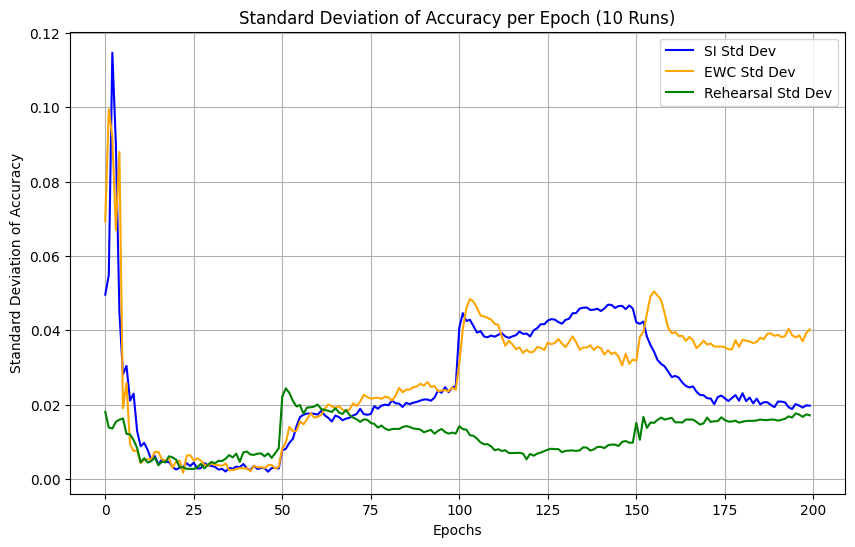

In [146]:
import matplotlib.pyplot as plt

ewc_task_A_combined_std = np.concatenate([ewc_initial_std, np.std(epoch_stats["ewc"]["A_during_B_val"], axis=0), 
                                          np.std(epoch_stats["ewc"]["A_during_C_val"], axis=0), 
                                          np.std(epoch_stats["ewc"]["A_during_D_val"], axis=0)])

no_ewc_task_A_combined_std = np.concatenate([no_ewc_initial_std, np.std(epoch_stats_no_ewc["no_ewc"]["A_during_B_val"], axis=0),
                                             np.std(epoch_stats_no_ewc["no_ewc"]["A_during_C_val"], axis=0),
                                             np.std(epoch_stats_no_ewc["no_ewc"]["A_during_D_val"], axis=0)])

si_task_A_combined_std = np.concatenate([si_A_during_A_std, np.std(epoch_stats_other["si"]["val_task_A_during_B"], axis=0),
                                         np.std(epoch_stats_other["si"]["val_task_A_during_C"], axis=0),
                                         np.std(epoch_stats_other["si"]["A_during_D_val"], axis=0)])

reh_task_A_combined_std = np.concatenate([reh_A_during_A_std, np.std(epoch_stats_other_reh["reh"]["val_task_A_during_B"], axis=0),
                                          np.std(epoch_stats_other["reh"]["val_task_A_during_C"], axis=0),
                                          np.std(epoch_stats_other["reh"]["A_during_D_val"], axis=0)])

# Create x-values for epochs
epochs = np.arange(len(si_task_A_combined_std))

# Plot standard deviations
plt.figure(figsize=(10, 6))
plt.plot(epochs, si_task_A_combined_std, label='SI Std Dev', color='blue')
plt.plot(epochs, ewc_task_A_combined_std, label='EWC Std Dev', color='orange')
plt.plot(epochs, reh_task_A_combined_std, label='Rehearsal Std Dev', color='green')

# Add labels, title, and legend
plt.xlabel('Epochs')
plt.ylabel('Standard Deviation of Accuracy')
plt.title('Standard Deviation of Accuracy per Epoch (10 Runs)')
plt.legend()
plt.grid(True)

# Save and display the plot
plt.savefig('std_dev_comparison.png')
plt.show()


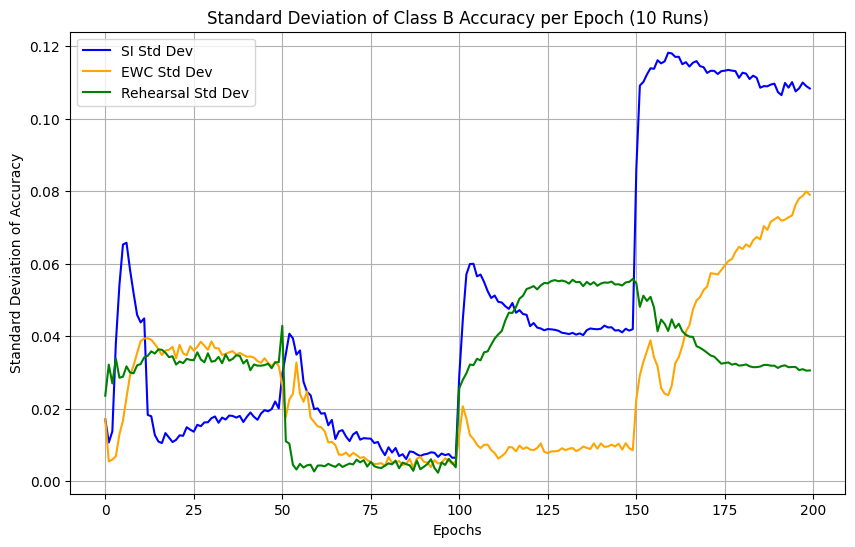

In [147]:
import matplotlib.pyplot as plt

ewc_task_B_combined_std = np.concatenate([ewc_B_during_A_std, ewc_task_B_std, ewc_task_B_during_C_std, ewc_task_B_during_D_std])
no_ewc_task_B_combined_std = np.concatenate([no_ewc_B_during_A_std, no_ewc_task_B_std, no_ewc_task_B_during_C_std, no_ewc_task_B_during_D_std])
si_task_B_combined_std = np.concatenate([si_B_during_A_std, si_task_B_std, si_task_B_during_C_std, si_task_B_during_D_std])
reh_task_B_combined_std = np.concatenate([reh_B_during_A_std, reh_task_B_std, reh_task_B_during_C_std, reh_task_B_during_D_std])

# Create x-values for epochs
epochs = np.arange(len(si_task_B_combined_std))

# Plot standard deviations
plt.figure(figsize=(10, 6))
plt.plot(epochs, si_task_B_combined_std, label='SI Std Dev', color='blue')
plt.plot(epochs, ewc_task_B_combined_std, label='EWC Std Dev', color='orange')
plt.plot(epochs, reh_task_B_combined_std, label='Rehearsal Std Dev', color='green')

# Add labels, title, and legend
plt.xlabel('Epochs')
plt.ylabel('Standard Deviation of Accuracy')
plt.title('Standard Deviation of Class B Accuracy per Epoch (10 Runs)')
plt.legend()
plt.grid(True)

# Save and display the plot
#plt.savefig('std_dev_comparison.png')
plt.show()


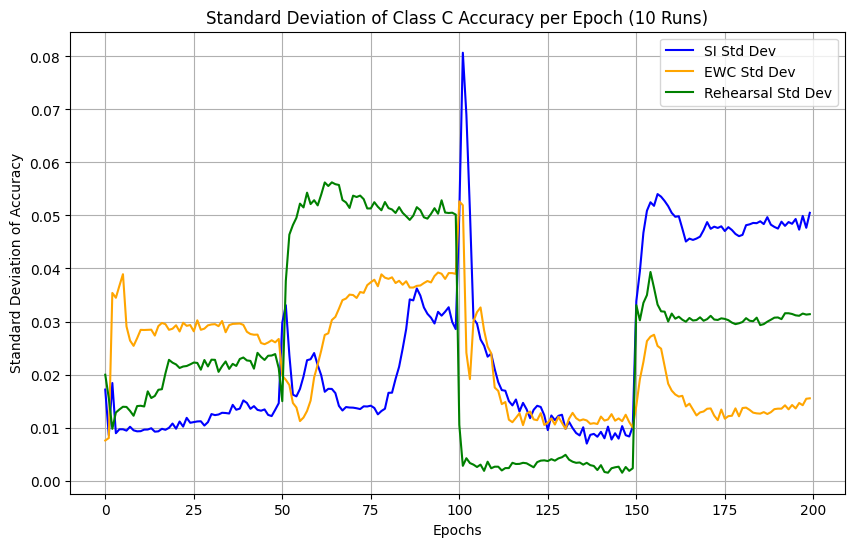

In [149]:
import matplotlib.pyplot as plt

ewc_task_A_combined_C_std = np.concatenate([ewc_C_during_A_std, ewc_task_C_during_B_std, ewc_task_C_std, ewc_task_C_during_D_std])
no_ewc_task_A_combined_C_std = np.concatenate([no_ewc_C_during_A_std, no_ewc_task_C_during_B_std, no_ewc_task_C_std, no_ewc_task_C_during_D_std])
pnn_task_A_combined_C_std = np.concatenate([pnn_C_during_A_std, pnn_task_C_during_B_std, pnn_task_C_std, pnn_task_C_during_D_std])
si_task_A_combined_C_std = np.concatenate([si_C_during_A_std, si_task_C_during_B_std, si_task_C_std, si_task_C_during_D_std])
reh_task_A_combined_C_std = np.concatenate([reh_C_during_A_std, reh_task_C_during_B_std, reh_task_C_std, reh_task_C_during_D_std])

# Create x-values for epochs
epochs = np.arange(len(si_task_B_combined_std))

# Plot standard deviations
plt.figure(figsize=(10, 6))
plt.plot(epochs, si_task_A_combined_C_std, label='SI Std Dev', color='blue')
plt.plot(epochs, ewc_task_A_combined_C_std, label='EWC Std Dev', color='orange')
plt.plot(epochs, reh_task_A_combined_C_std, label='Rehearsal Std Dev', color='green')

# Add labels, title, and legend
plt.xlabel('Epochs')
plt.ylabel('Standard Deviation of Accuracy')
plt.title('Standard Deviation of Class C Accuracy per Epoch (10 Runs)')
plt.legend()
plt.grid(True)

# Save and display the plot
#plt.savefig('std_dev_comparison.png')
plt.show()


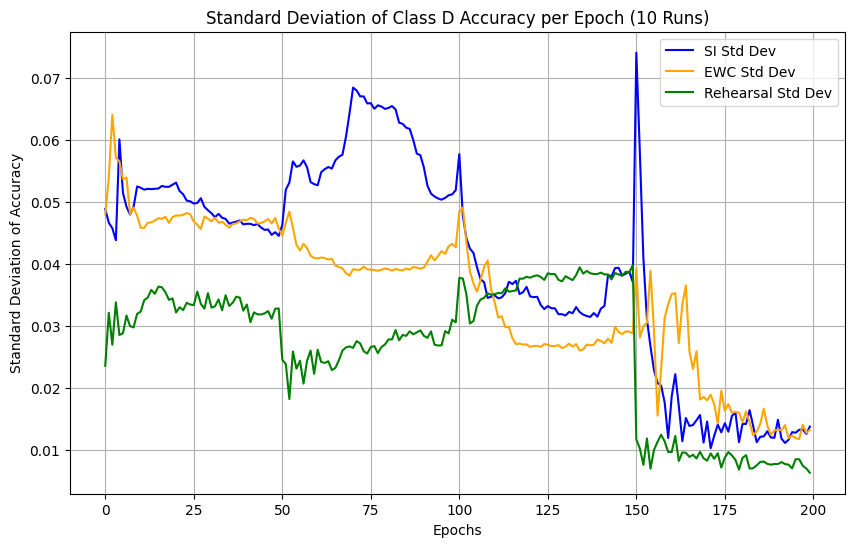

In [150]:
import matplotlib.pyplot as plt

ewc_task_A_combined_D_std = np.concatenate([ewc_D_during_A_std, ewc_task_D_during_B_std, ewc_task_D_during_C_std, ewc_task_D_std])
no_ewc_task_A_combined_D_std = np.concatenate([no_ewc_D_during_A_std, no_ewc_task_D_during_B_std, no_ewc_task_D_during_C_std, no_ewc_task_D_std])
pnn_task_A_combined_D_std = np.concatenate([pnn_D_during_A_std, pnn_task_D_during_B_std, pnn_task_D_during_C_std, pnn_task_D_std])
si_task_A_combined_D_std = np.concatenate([si_D_during_A_std, si_task_D_during_B_std, si_task_D_during_C_std, si_task_D_std])
reh_task_A_combined_D_std = np.concatenate([reh_D_during_A_std, reh_task_D_during_B_std, reh_task_D_during_C_std, reh_task_D_std])

# Create x-values for epochs
epochs = np.arange(len(si_task_B_combined_std))

# Plot standard deviations
plt.figure(figsize=(10, 6))
plt.plot(epochs, si_task_A_combined_D_std, label='SI Std Dev', color='blue')
plt.plot(epochs, ewc_task_A_combined_D_std, label='EWC Std Dev', color='orange')
plt.plot(epochs, reh_task_A_combined_D_std, label='Rehearsal Std Dev', color='green')

# Add labels, title, and legend
plt.xlabel('Epochs')
plt.ylabel('Standard Deviation of Accuracy')
plt.title('Standard Deviation of Class D Accuracy per Epoch (10 Runs)')
plt.legend()
plt.grid(True)

# Save and display the plot
#plt.savefig('std_dev_comparison.png')
plt.show()


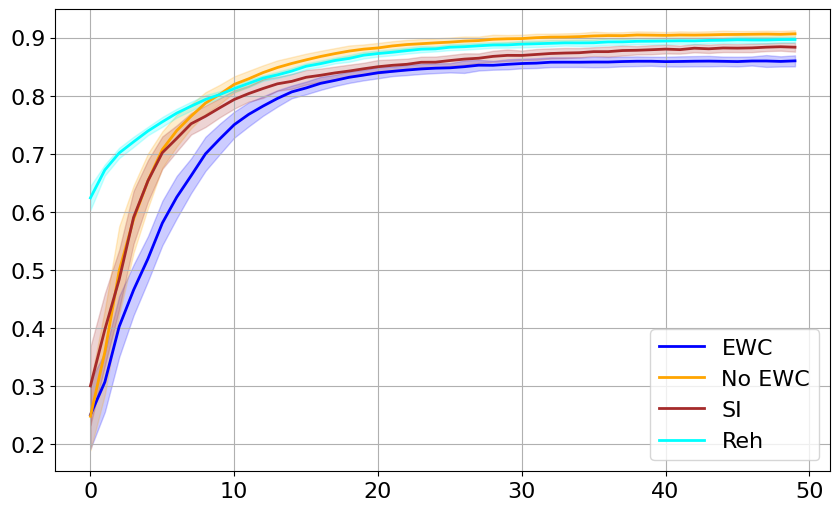

In [101]:
# Compute per-epoch average accuracy across all classes
avg_ewc = np.mean([ewc_initial_acc, ewc_task_B, ewc_task_C, ewc_task_D], axis=0)
avg_no_ewc = np.mean([no_ewc_initial_acc, no_ewc_task_B, no_ewc_task_C, no_ewc_task_D], axis=0)
avg_si = np.mean([si_A_during_A, si_task_B, si_task_C, si_task_D], axis=0)
avg_reh = np.mean([reh_A_during_A, reh_task_B, reh_task_C, reh_task_D], axis=0)

# Compute per-epoch average standard deviation across all classes
avg_ewc_std = np.mean([ewc_initial_std, ewc_task_B_std, ewc_task_C_std, ewc_task_D_std], axis=0)
avg_no_ewc_std = np.mean([no_ewc_initial_std, no_ewc_task_B_std, no_ewc_task_C_std, no_ewc_task_D_std], axis=0)
avg_si_std = np.mean([si_A_during_A_std, si_task_B_std, si_task_C_std, si_task_D_std], axis=0)
avg_reh_std = np.mean([reh_A_during_A_std, reh_task_B_std, reh_task_C_std, reh_task_D_std], axis=0)


# X-axis: 50 epochs
epochs = np.arange(len(avg_ewc))

# Plot
plt.figure(figsize=(10, 6))
# Plot EWC with variance band
plt.plot(epochs, avg_ewc, label='EWC', color='blue', linewidth=2)
plt.fill_between(epochs, avg_ewc - avg_ewc_std, avg_ewc + avg_ewc_std, color='blue', alpha=0.2)

# Plot No EWC with variance band
plt.plot(epochs, avg_no_ewc, label='No EWC', color='orange', linewidth=2)
plt.fill_between(epochs, avg_no_ewc - avg_no_ewc_std, avg_no_ewc + avg_no_ewc_std, color='orange', alpha=0.2)

# Plot SI with variance band
plt.plot(epochs, avg_si, label='SI', color='brown', linewidth=2)
plt.fill_between(epochs, avg_si - avg_si_std, avg_si + avg_si_std, color='brown', alpha=0.2)

# Plot Rehearsal with variance band
plt.plot(epochs, avg_reh, label='Reh', color='cyan', linewidth=2)
plt.fill_between(epochs, avg_reh - avg_reh_std, avg_reh + avg_reh_std, color='cyan', alpha=0.2)


# Labels, title, and legend
plt.xticks(fontsize=16)                 # Font size for x-axis ticks
plt.yticks(fontsize=16) 
plt.legend(fontsize=16)
plt.grid(True)

# Save and show the plot
plt.savefig('cil_realworld_avg_accuracy_plot.png')
plt.show()
